# Active Learning

The goal is to determine the informativeness of each of the datapoints in a set, and then limit the dataset to those points prior to any calculations. More information tends to be better, so we need to work out the best way to argue that shrinking the dataset is a useful endeavour. Active learning tends to be a prospective technique, in which there is a large sample of unlabelled points, whereas in our case we're arguing that we do in fact have a large number of labelled points, and are instead trying to infer the maximally informative subset of these points.

We want to shrink the dataset as effectively as possible to benefit poorly scaling machine learning methods. We want to seed the system with a clustering based approach, and we want to 

Any active learning strategy is intrinsically coupled to both the representation of the dataset, and the predictor that is used to estimate the uncertainty across the points. Determining the most informative points in a more absolute sense requires decoupling the informativeness measure from both the representation and the predictor. In practice this is impossible, however, this process can be approximated by forming an ensemble of both predictors and representations. This can be seen as an extension of query by committee, in which a committee of models is formed and used as an estimator for the underlying uncertainty of each datapoint. 

Saying how informative a datapoint is individually is a non-sensical proposition. Rather, informativeness is best defined as the deterioration in model performance that would result from omission of this datapoint. This is naturally aligned with the Shapley interpretation of significance. The underlying concept is that a dataset is a coalition of datapoints. The reward for this coalition is the performance of a model trained on the data. This performance needs to be distributed in an equiatable manner, and Shapley values were introduced to overcome this problem. The idea is to create all possible combinations of the data and record the underlying performance. The Shapley value is then the average contribution that this feature makes in the coalitions it is present in. Intuitively, datapoints with the highest Shapley values, or informativeness, contribute more to the model's performance. 

This precise method was recently introduced by Ghorbani and Zhou, in which Monte Carlo estimates were used to determine the importance of each point in the dataset.

In [1]:
%matplotlib widget
%matplotlib notebook
%matplotlib inline

In [16]:
import os
import tqdm
import numpy as np 
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import array_to_latex as a2l
import matplotlib as mpl
from sklearn.decomposition import PCA
from functools import reduce, partial 
from sklearn.datasets import make_blobs
import importlib, sys


# Preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

from utils.utils import flatten, save

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

dataset_dir = "Dataset_24_08_21"#"Dataset_12-07-21"

def set_numpy_decimal_places(places, width=0):
    set_np = '{0:' + str(width) + '.' + str(places) + 'f}'
    np.set_printoptions(formatter={'float': lambda x: set_np.format(x)})
set_numpy_decimal_places(3)


## Setting Random State

In [3]:
# Set random seed for numpy
state = 10
np.random.seed(state)

## Figure Plotting Settings

In [73]:
darkmode = {"lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"}

lightmode = {"lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"}

mpl.rcParams.update(lightmode)

p = plt.rcParams

# former facecolor = #f9f9f9

p["figure.facecolor"] = "#ffffff"

p["axes.linewidth"] = 1
p["axes.facecolor"] = "#f9f9f9"
p["axes.ymargin"] = 0.1
p["axes.spines.bottom"] = True
p["axes.spines.left"] = True
p["axes.spines.right"] = False
p["axes.spines.top"] = False
p["font.sans-serif"] = ["Fira Sans Condensed"]

p["axes.grid"] = False
p["grid.color"] = "black"
p["grid.linewidth"] = 0.1

p["xtick.bottom"] = True
p["xtick.top"] = False
p["xtick.direction"] = "out"
p["xtick.major.size"] = 5
p["xtick.major.width"] = 1
p["xtick.minor.size"] = 3
p["xtick.minor.width"] = 0.5
p["xtick.minor.visible"] = True
p["xtick.labelsize"] = 24

p["ytick.left"] = True
p["ytick.right"] = False
p["ytick.direction"] = "out"
p["ytick.major.size"] = 5
p["ytick.major.width"] = 1
p["ytick.minor.size"] = 3
p["ytick.minor.width"] = 0.5
p["ytick.minor.visible"] = True
p["ytick.labelsize"] = 24

p["lines.linewidth"] = 2
p["lines.marker"] = None
p["lines.markeredgewidth"] = 1.5
p["lines.markeredgecolor"] = "auto"
p["lines.markerfacecolor"] = "white"
p["lines.markersize"] = 6


# TODO Before Final

- [x] Do PCA properly and only grab the necessary number of dimensions for each sample.
- [x] Ensure that it is valid to use PCA prior to ML training.
- [ ] Ensure that every seed is set correctly for reproducability.
- [x] Find bug with point 134 and why it is not selected, or if it is, why the performance is precisely 0.

# Dataset Loading

Dataset loading for interaction energies

## Dataset Loading

This section loads each of the six subsets of interest and extracts the values into a new dataframe.

In [5]:
# Goes on to store the xyz files for each dataset.
dsets = {"2IPs" : [],
         "3B69" : [],
         "IL85" : [],
         "S66"  : []}
         #"4IPs" : [],
         #"X23"  : []}

legend = {x : dset for x,dset in zip(range(len(dsets)),dsets.keys())}
colors = {0 : "orange", 1:"blue", 2:"green", 3:"purple", 4:"red", 5:"yellow"}
legend_index = {dset : x for x,dset in zip(range(len(dsets)),dsets.keys())}

methods = {"blyp"  : "blyp_vtz",
           "b3lyp" : "b3lyp_vtz",
           "m062x" : "m062x_vtz",
           "pbe"   : "pbe_vtz"}

datasets = {method : {dset : pd.read_csv(f"{dataset_dir}/{method.lower()}/{dset}_{method_string}.csv") for dset in dsets.keys()} for method,method_string in methods.items()}

blyp  = datasets["blyp"]
b3lyp = datasets["b3lyp"]
m062x = datasets["m062x"]
pbe   = datasets['pbe']

# This section needs to be removed once new data is incorporated.
pbe["IL85"] = pbe["IL85"].drop([34,52,53,56],axis=0)
b3lyp["2IPs"] = b3lyp["2IPs"].drop(3,axis=0)
b3lyp["IL85"] = b3lyp["IL85"].drop([3,25,30,37,55,56,59],axis=0)
m062x["IL85"] = m062x["IL85"].drop([34,52,53,56],axis=0)

## Constructing full dataset

In [6]:
dataframes = [blyp,b3lyp]#,m062x,pbe]
headers = ["dINT_BLYP_ref_cp",
           "dINT_B3LYP_ref_cp"]

df = pd.DataFrame({
        "Complex"     : np.concatenate([blyp[dset]["complex"] for dset in dsets.keys()]),
        "dINT_BLYP_ref_cp"  : np.concatenate([blyp[dset]["dINT_BLYP_ref_cp"] for dset in dsets.keys()]),
        "dINT_B3LYP_ref_cp" : np.concatenate([b3lyp[dset]["dINT_B3LYP_ref_cp"] for dset in dsets.keys()]),
        "dINT_M062X_ref_cp" : np.concatenate([m062x[dset]["dINT_M062X_ref_cp"] for dset in dsets.keys()]),
        "dINT_PBE_ref_cp" : np.concatenate([pbe[dset]["dINT_PBE_ref_cp"] for dset in dsets.keys()]),
        "Dataset" : flatten([[name for x in range(len(dset))] for name, dset in blyp.items()])
    
})

df

Complex  dINT_BLYP_ref_cp  dINT_B3LYP_ref_cp  \
0         c4mim-ac-2-p2             -65.2              -43.6   
1         c4mim-ac-2-p4             -63.9              -49.8   
2         c4mim-ac-2-p7             -83.5              -58.8   
3         c4mim-ac-3-p4            -156.0             -119.9   
4         c4mim-ac-4-p2            -143.9              -87.5   
..                  ...               ...                ...   
261    62_Pentane-AcNH2             -24.5              -19.9   
262     63_Benzene-AcOH             -23.6              -19.2   
263   64_Peptide-Ethene             -16.2              -12.7   
264  65_Pyridine-Ethyne              -5.6               -3.7   
265   66_MeNH2-Pyridine             -17.7              -14.5   

     dINT_M062X_ref_cp  dINT_PBE_ref_cp Dataset  
0            20.267909       -18.044256    2IPs  
1            10.850084       -27.240597    2IPs  
2            20.934319       -30.089175    2IPs  
3            13.806976       -91.104089    2IPs  
4             9.343976       -82.055240    2IPs  
..                 ...              ...     ...  
261          -1.059632       -13.700000     S66  
262          -0.445806       -14.000000     S66  
263          -0.725776        -8.600000     S66  
264          -1.959910        -1.600000     S66  
265          -1.451535        -9.900000     S66  

[266 rows x 6 columns]

# Creating Molecular Representations

In [7]:
import ase
import dscribe
import sklearn
from dscribe.descriptors import SOAP,CoulombMatrix, MBTR
from dscribe.kernels import REMatchKernel
from ase.build import molecule
from ase.io import read
from ase import Atoms
from sklearn.preprocessing import normalize
from dscribe.descriptors import SOAP

if not os.path.exists("Representations"):
    os.mkdir("Representations")

# QM9_setup 

species = ["H", "C", "O", "N","F","P","S","B","Cl"]
rcut = 6.0
nmax = 8
lmax = 6

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
)

average_soap = SOAP(
    species=species,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
    average="inner",
    sparse=False
)

# Setting up the CM descriptor
cm = CoulombMatrix(
    n_atoms_max=104,
)

# Setting up the MBTR descriptor
mbtr = MBTR(
    species=species,
    k1={
        "geometry": {"function": "atomic_number"},
        "grid": {"min": 0, "max": 17, "n": 100, "sigma": 0.1},
    },
    k2={
        "geometry": {"function": "inverse_distance"},
        "grid": {"min": 0, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    k3={
        "geometry": {"function": "cosine"},
        "grid": {"min": -1, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    periodic=False,
    normalization="l2_each",
)

In [8]:
mols = []

# Reads all of the mol xyz files by iterating over the complex and constructing the xyz file locations from the complex and dataset information.
for i,mol in enumerate(df["Complex"]):
    mols.append(read("xyz/"+df.iloc[i]["Dataset"]+"/"+mol+".xyz"))
    
cm_mols = np.array([cm.create(mol) for mol in tqdm.tqdm(mols,position=0, leave=True)])
soap_mols = [soap.create(mol) for mol in tqdm.tqdm(mols, position=0, leave=True)]
avsoap_mols = np.array([average_soap.create(mol) for mol in tqdm.tqdm(mols, position=0, leave=True)])
mbtr_mols = np.array([mbtr.create(mol) for mol in tqdm.tqdm(mols, position=0, leave=True)])

100%|█████████████████████████████████████████| 266/266 [00:21<00:00, 12.14it/s]


## Dataset Splitting

This step removes the 10% of the data for testing purposes only, and then all subsequent testing is done with the remaining 80% of the data.

The cell below will break if run twice because it overwrites the steps above to do my best to ensure that I don't run into problems down the line.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
   
le = LabelEncoder()
le.fit(df["Dataset"].to_numpy())
df["Categorical"] = le.transform(df.Dataset)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=state)
for trn_index, tst_index in sss.split(cm_mols, df["Categorical"]):
    inner_mols, outer_mols = np.sort(trn_index), np.sort(tst_index)

Y = df["dINT_BLYP_ref_cp"].to_numpy()

# inner_mols - The molecules used for the inner cross validation loop.
# outer_mols - The molecules held aside for testing purposes only.

## Representations for visualisation

In [12]:
from chemdataval.chemdataval.preprocessing import *

small_cm, _ = preprocess(cm_mols, Y, np.arange(266), n_components=2)
small_soap, _ = preprocess(avsoap_mols, Y, np.arange(266), n_components=2)
small_mbtr, _ = preprocess(mbtr_mols, Y, np.arange(266),n_components=2)

small_representations = {"CM" :small_cm,
                         "AvSOAP" : small_soap,
                         "MBTR" : small_mbtr}

# Functions

## Query Strategies

In [13]:
from chemdataval.chemdataval.query_strategy import *

## Visualisation Functions

In [14]:
import chemdataval.chemdataval.visualisation as vis

## Utility Functions

In [17]:
import pickle
import scipy.stats as st

import chemdataval.chemdataval.utils as utils
importlib.reload(sys.modules['chemdataval.chemdataval.utils'])
import chemdataval.chemdataval.utils as utils

## Seeding Functions

In [18]:
def kmean_seed(X, seed_size, train_index, random_state=0):
    """
    X should only be the training data
    """
    kmean_centroid_in_train = KMeans(n_clusters=seed_size, random_state=random_state).fit(X[train_index]).cluster_centers_
    # Only allow it to select the nearest points from the training data.
    sub_query = vq(kmean_centroid_in_train, X[train_index])[0]
    kmean_seed_ = train_index[sub_query]
    i = 1
    
    # This loop is to ensure that the kmean seed does not contain any duplicates
    while len(np.unique(kmean_seed_)) < seed_size:
        kmean_centroid_in_train = KMeans(n_clusters=seed_size+i, random_state=idx).fit(X).cluster_centers_
        sub_query = vq(kmean_centroid_in_train, X[train_index])[0]
        kmean_seed_ = train_index[sub_query]
        i += 1
        
    return np.unique(kmean_seed_)[:30]

## Testing Functions

In [19]:
import chemdataval.chemdataval.testing_functions as test_funcs
importlib.reload(sys.modules['chemdataval.chemdataval.testing_functions'])
import chemdataval.chemdataval.testing_functions as test_funcs


## Informativeness Scoring

In [20]:
import chemdataval.chemdataval.informativeness as inform_funcs
importlib.reload(sys.modules['chemdataval.chemdataval.informativeness'])
import chemdataval.chemdataval.informativeness as inform_funcs

## Intelligent Sampling

In [24]:
import chemdataval.chemdataval.intelligent_sampling as intel
importlib.reload(sys.modules['chemdataval.chemdataval.intelligent_sampling'])
import chemdataval.chemdataval.intelligent_sampling as intel

## Reload

In [1019]:
import importlib, sys, warnings

import chemdataval.chemdataval.preprocessing as pre
importlib.reload(sys.modules['chemdataval.chemdataval.preprocessing'])
import chemdataval.chemdataval.preprocessing as pre

import chemdataval.chemdataval.monte_carlo as mc
importlib.reload(sys.modules['chemdataval.chemdataval.monte_carlo'])
import chemdataval.chemdataval.monte_carlo as mc

import chemdataval.chemdataval.utils as utils
importlib.reload(sys.modules['chemdataval.chemdataval.utils'])
import chemdataval.chemdataval.utils as utils

import chemdataval.chemdataval.informativeness as inform_funcs
importlib.reload(sys.modules['chemdataval.chemdataval.informativeness'])
import chemdataval.chemdataval.informativeness as inform_funcs

import chemdataval.chemdataval.intelligent_sampling_funcs as intelli
importlib.reload(sys.modules['chemdataval.chemdataval.intelligent_sampling_funcs'])
import chemdataval.chemdataval.intelligent_sampling_funcs as intelli

import chemdataval.chemdataval.testing_functions as test_funcs
importlib.reload(sys.modules['chemdataval.chemdataval.testing_functions'])
import chemdataval.chemdataval.testing_functions as test_funcs

import chemdataval.chemdataval.dft_parameterisation as dft_params
importlib.reload(sys.modules['chemdataval.chemdataval.dft_parameterisation'])
import chemdataval.chemdataval.dft_parameterisation as dft_params

import chemdataval.chemdataval.visualisation as vis
importlib.reload(sys.modules['chemdataval.chemdataval.visualisation'])
import chemdataval.chemdataval.visualisation as vis

import chemdataval.chemdataval.explicit_shapley as exp_shap
importlib.reload(sys.modules['chemdataval.chemdataval.explicit_shapley'])
import chemdataval.chemdataval.explicit_shapley as exp_shap


# Representations Preprocessing

In [594]:
representations = {"CM" : cm_mols, 
                   "AvSOAP" : avsoap_mols, 
                   "MBTR" : mbtr_mols}

big_rep = 100
Y = df["dINT_BLYP_ref_cp"].to_numpy()

processed_representations = {rep : pre.preprocess(representations[rep], Y, inner_mols, n_components=0.99) for rep in representations}
processed_representations_big = {rep : pre.preprocess(representations[rep], Y, inner_mols, n_components=big_rep) for rep in representations}


# Active Learning Testing

## Representation results testing

## Cross Validation Testing

In [595]:
import warnings
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

strategies = {"Uncertainty"  : partial(test_funcs.active_test,β=0, query=GP_regression_std),
              "Information Density" : partial(test_funcs.active_test,β=1.0, query=GP_regression_std),
              "Random"  : test_funcs.random_test,}

density_arrays = {"REMatch" : np.zeros((len(trn_index),len(trn_index)))}

kernel = RBF(1) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-20, 100000.0))

n_splits = 5
categorical = df.iloc[inner_mols]["Categorical"].to_numpy()
active_learning_runs = 250
active_learning_runs_big = 1

kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=state) # Using this split so that the dataset classes are balanced.
#kf = KFold(n_splits=n_splits, shuffle=True, random_state=state)

seed_sizes = {"CM" : 131, 
              "AvSOAP" : 9,
              "MBTR" : 32}

seed_sizes_big = {"CM" : big_rep, 
                  "AvSOAP" : big_rep,
                  "MBTR" : big_rep}


In [598]:
kf_results_big = {}

for name, (X, Y) in processed_representations_big.items():
    kf_results_big[name] = test_funcs.fold_testing(X[inner_mols], 
                                                    Y[inner_mols], 
                                                    strategies=strategies, 
                                                    categorical=categorical, 
                                                    kf=kf, 
                                                    random_runs=active_learning_runs_big, 
                                                    kernel=kernel, 
                                                    seed_size="variable", 
                                                    n_components=big_rep,
                                                    preprocessing=False,
                                                    debug=True)
    
    utils.save_obj(kf_results, f'kf_results_final_{big_rep}')

Running fold 1
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.41s/it]


Running fold 2
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.61s/it]


Running fold 3
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.14s/it]


Running fold 4
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.47s/it]


Running fold 5
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.29s/it]


File Saved Successfully
Running fold 1
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.19s/it]


Running fold 2
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.09s/it]


Running fold 3
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.92s/it]


Running fold 4
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.93s/it]


Running fold 5
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.11s/it]


File Saved Successfully
Running fold 1
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.54s/it]


Running fold 2
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.46s/it]


Running fold 3
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.56s/it]


Running fold 4
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.96s/it]


Running fold 5
False (239, 100)
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 91


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.49s/it]

File Saved Successfully


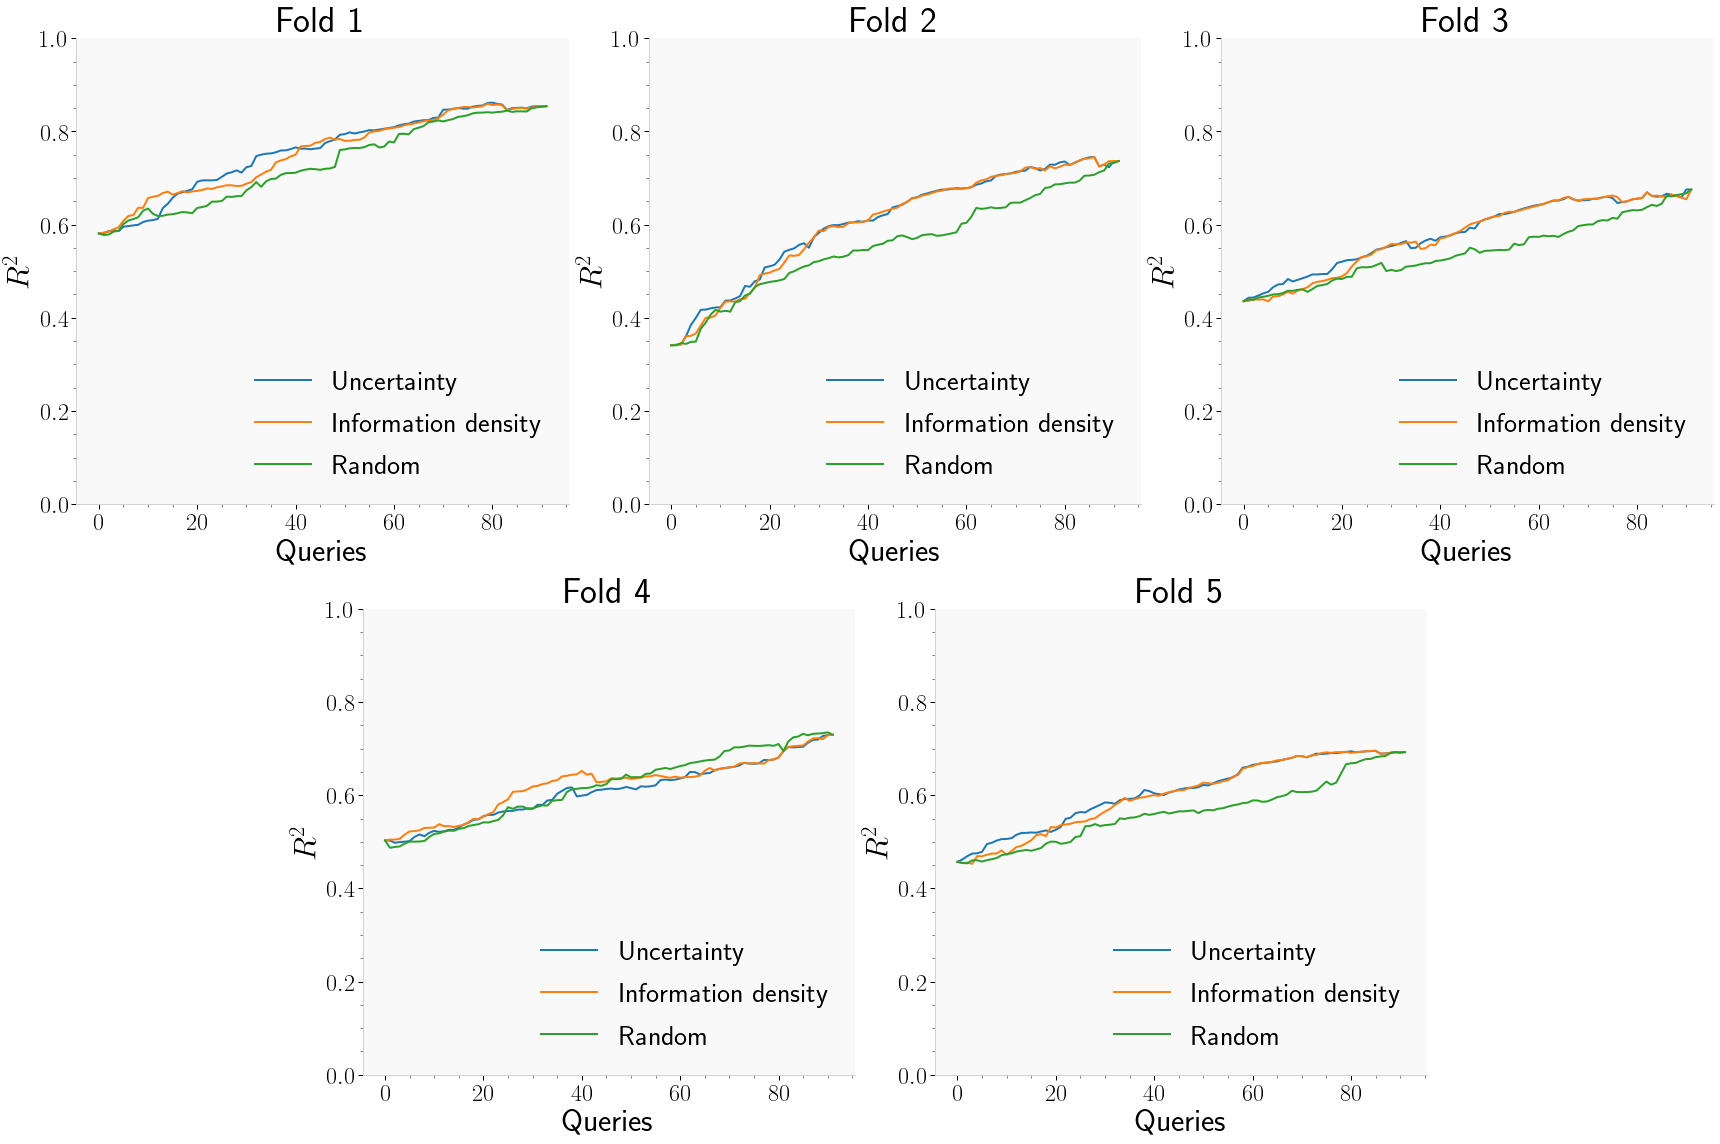

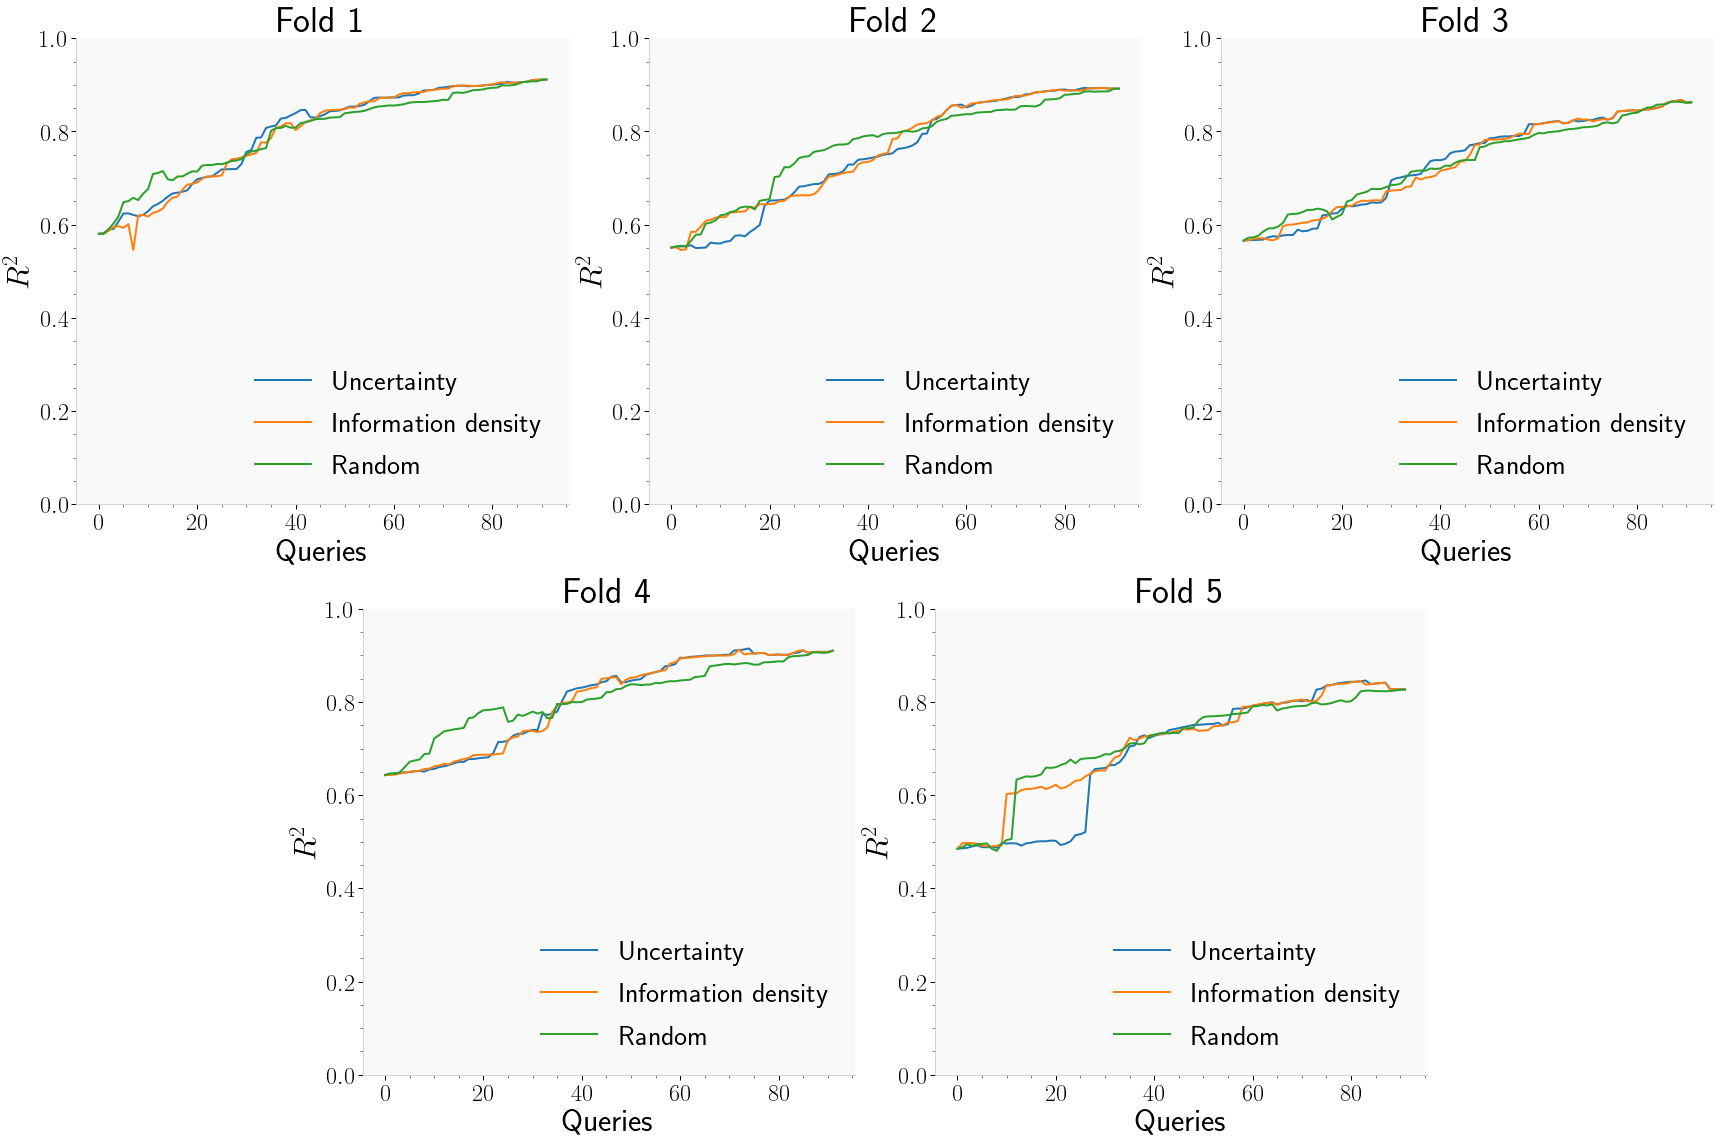

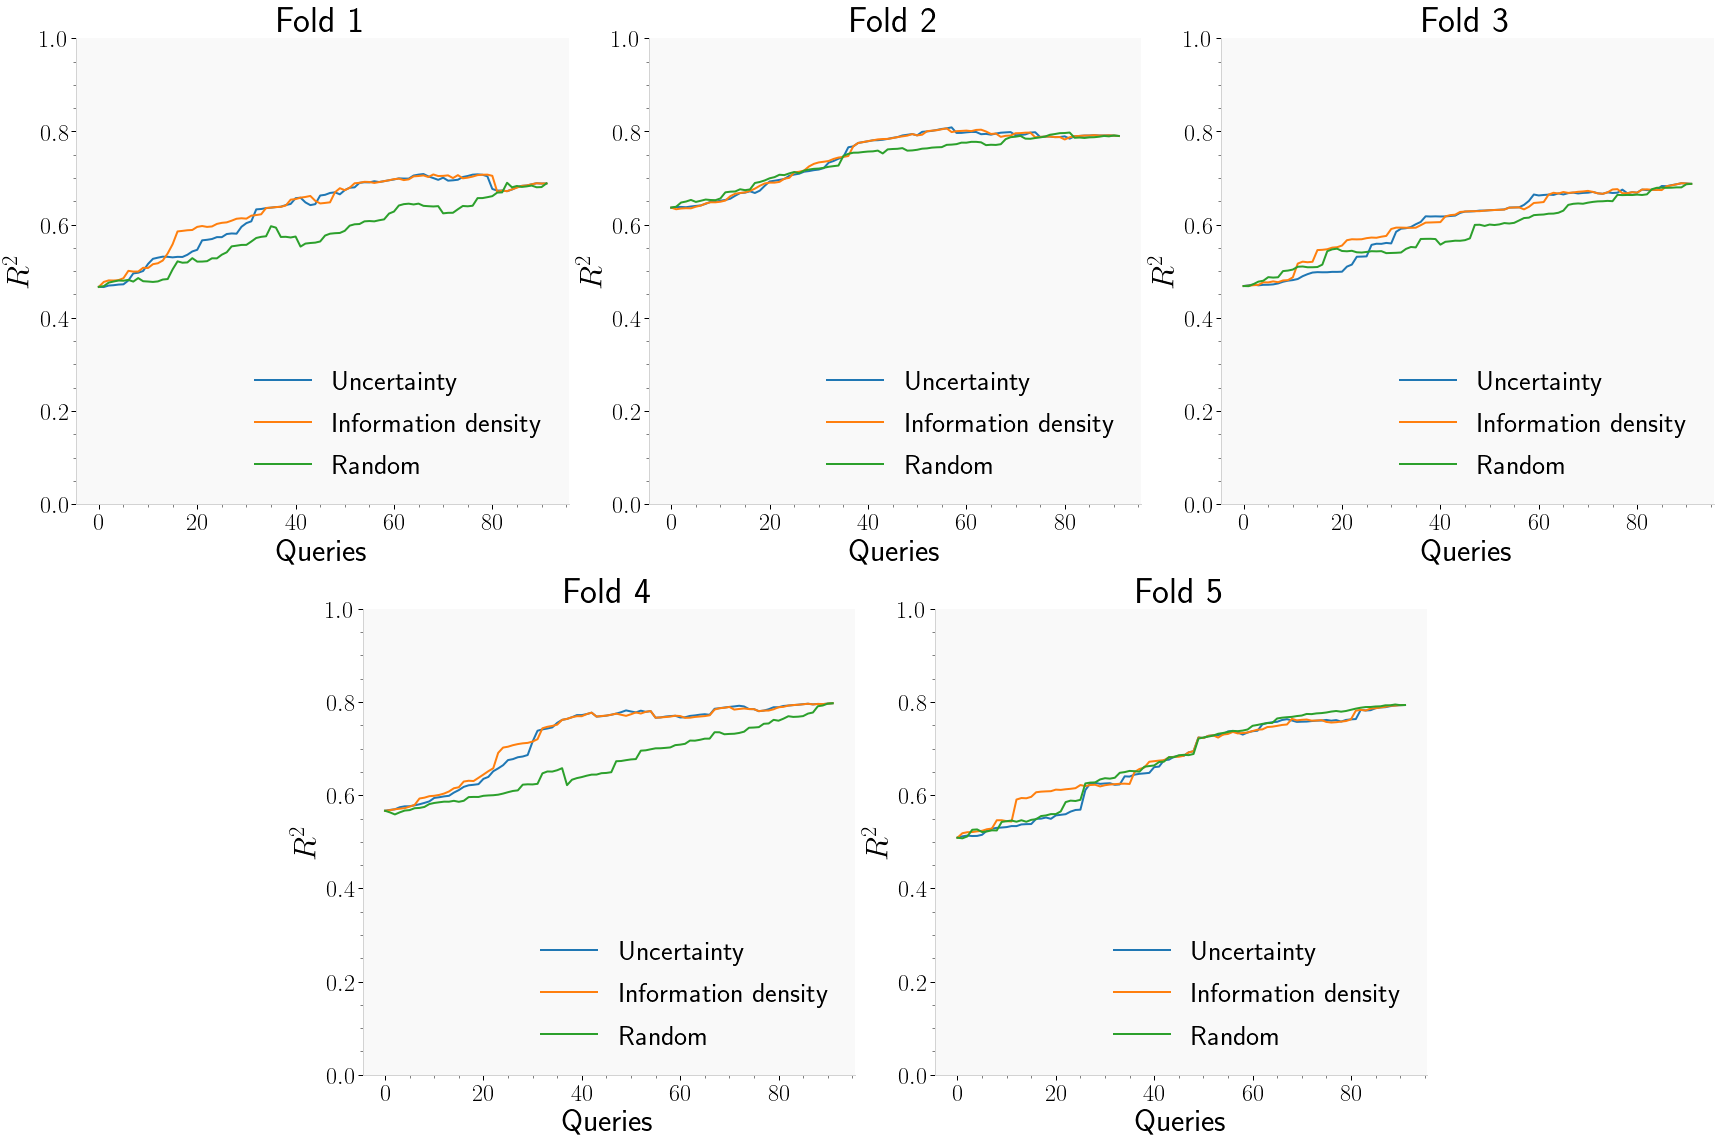

In [599]:
#ylims = [(0,1.), (0.2,1.0), (0.4,1)]
for i, (name, results) in enumerate(kf_results_big.items()):
    fg = vis.visualise_kf(results)
    #plt.savefig(f"Images/{name}_Different_active_learning_methods.svg",bbox_inches="tight")
    #plt.savefig(f"Images/{name}_Different_active_learning_methods.pdf",bbox_inches="tight")
    plt.show()

In [24]:
#if os.path.exists('kf_results_big.pkl'):
#    kf_results = load_obj('kf_results_big')
#else:
#    save_obj(kf_results, 'kf_results_big')

File Loaded Successfully


## Rep Visualisation

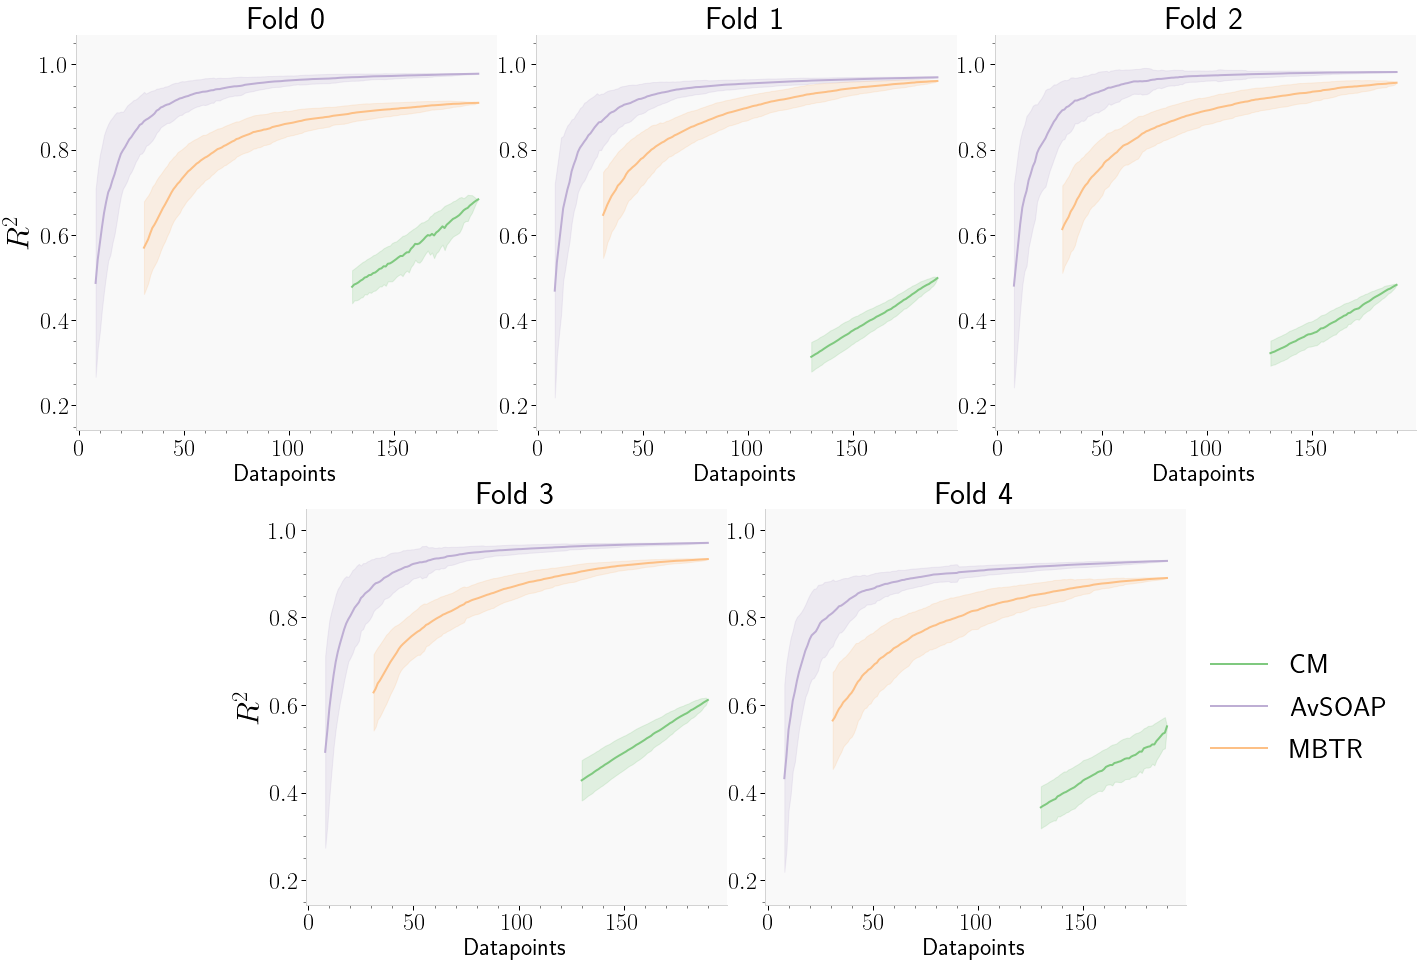

In [551]:
fig, axs = vis.fivefigs(shareaxes=True, yaxis_label="$R^2$")

rep_colors = dict(zip(representations.keys(), ['#7fc97f','#beaed4','#fdc086']))

for ax,fold in zip(axs,range(5)):
    for i,rep in enumerate(restructured_kf.keys()):
        rep_data = restructured_kf[rep]["Random"]['scores'][fold * active_learning_runs : fold * active_learning_runs + active_learning_runs]
        if fold == 4:
            vis.plot_multiple_runs(range(191-rep_data.shape[1], 191), rep_data.T, ax=ax, color=rep_colors[rep],label=rep)
        else:
            vis.plot_multiple_runs(range(191-rep_data.shape[1], 191), rep_data.T, ax=ax, color=rep_colors[rep])
    if fold == 4:
        ax.legend(frameon=False, fontsize=28, bbox_to_anchor=(1,0.5), loc="center left")
    ax.set_xlabel("Datapoints", fontsize=24)
    ax.set_title(f"Fold {fold}", fontsize=32)
 
plt.savefig("Images/Representation_testing.pdf", bbox_inches="tight")
plt.savefig("Images/Representation_testing.svg", bbox_inches="tight")

In [509]:
#kf_results = utils.load_obj('kf_results_final')

File Loaded Successfully


(1250, 61)

In [2254]:
#save_obj(kf_results, 'kf_results_big_proper')

File Saved Successfully


## Run Visualisation

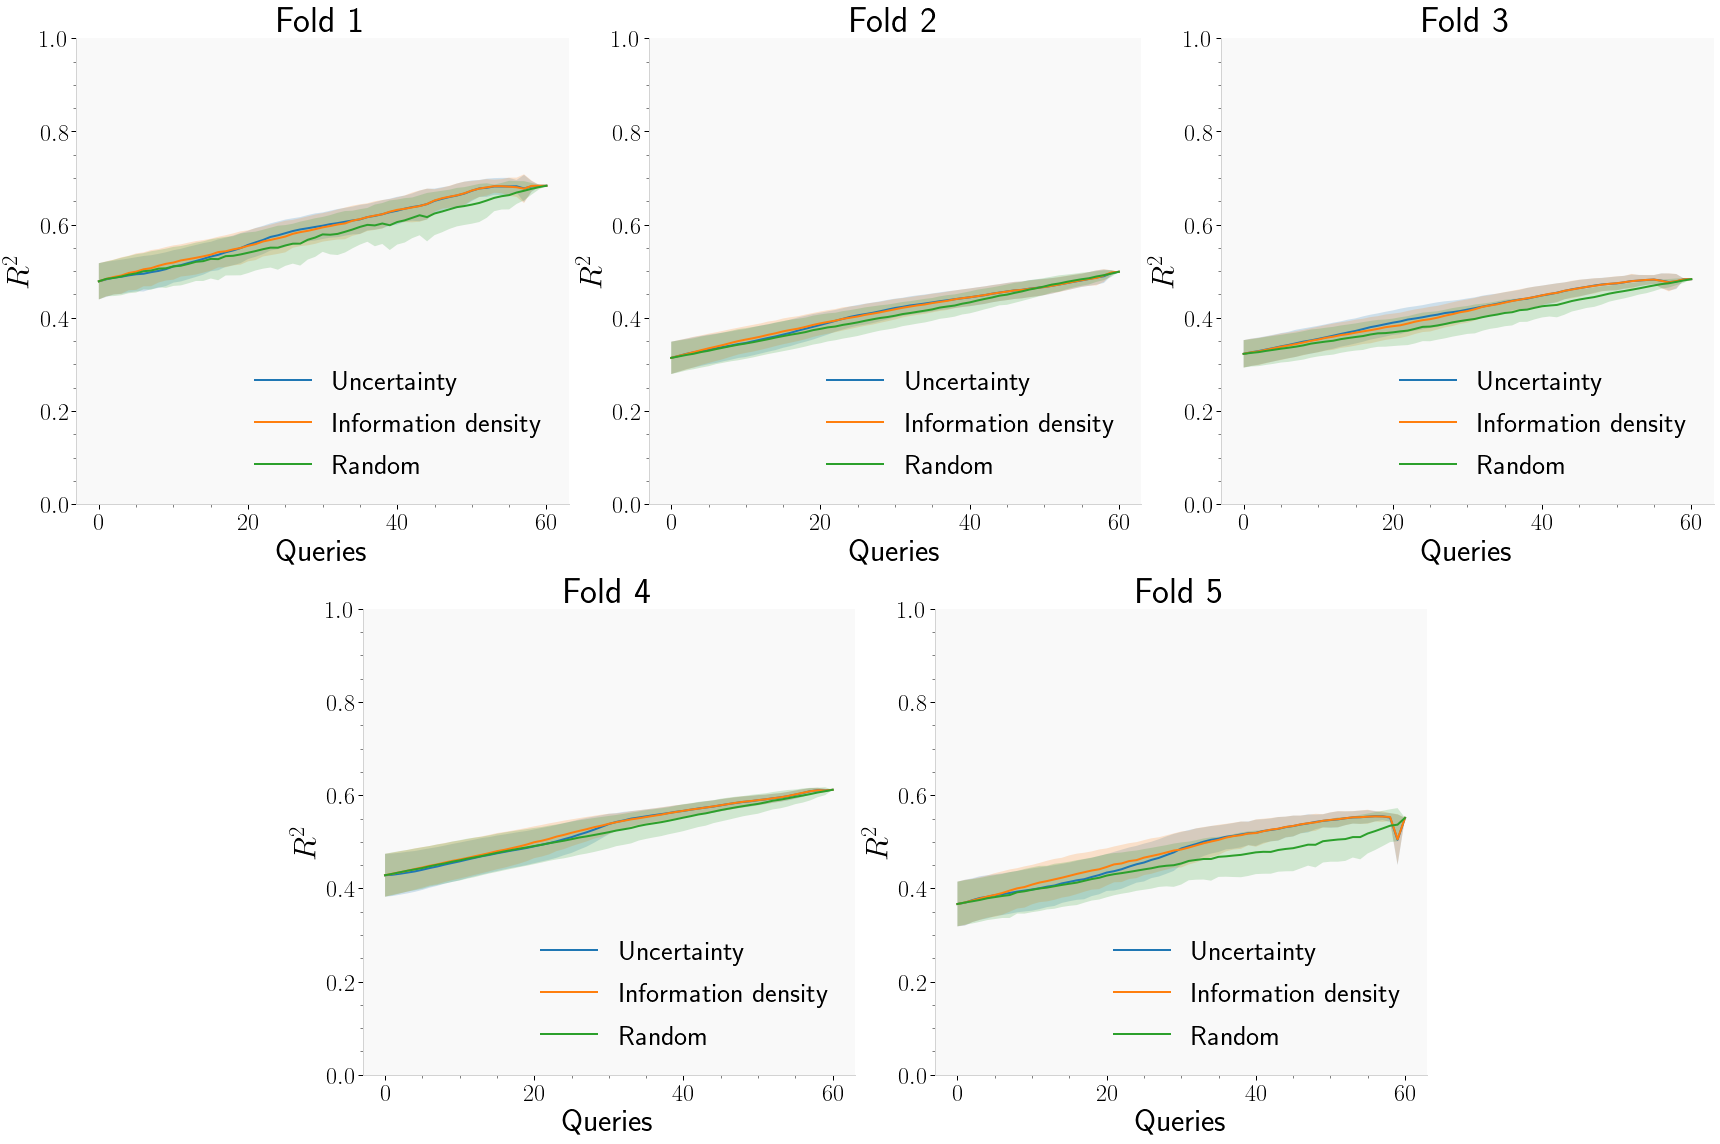

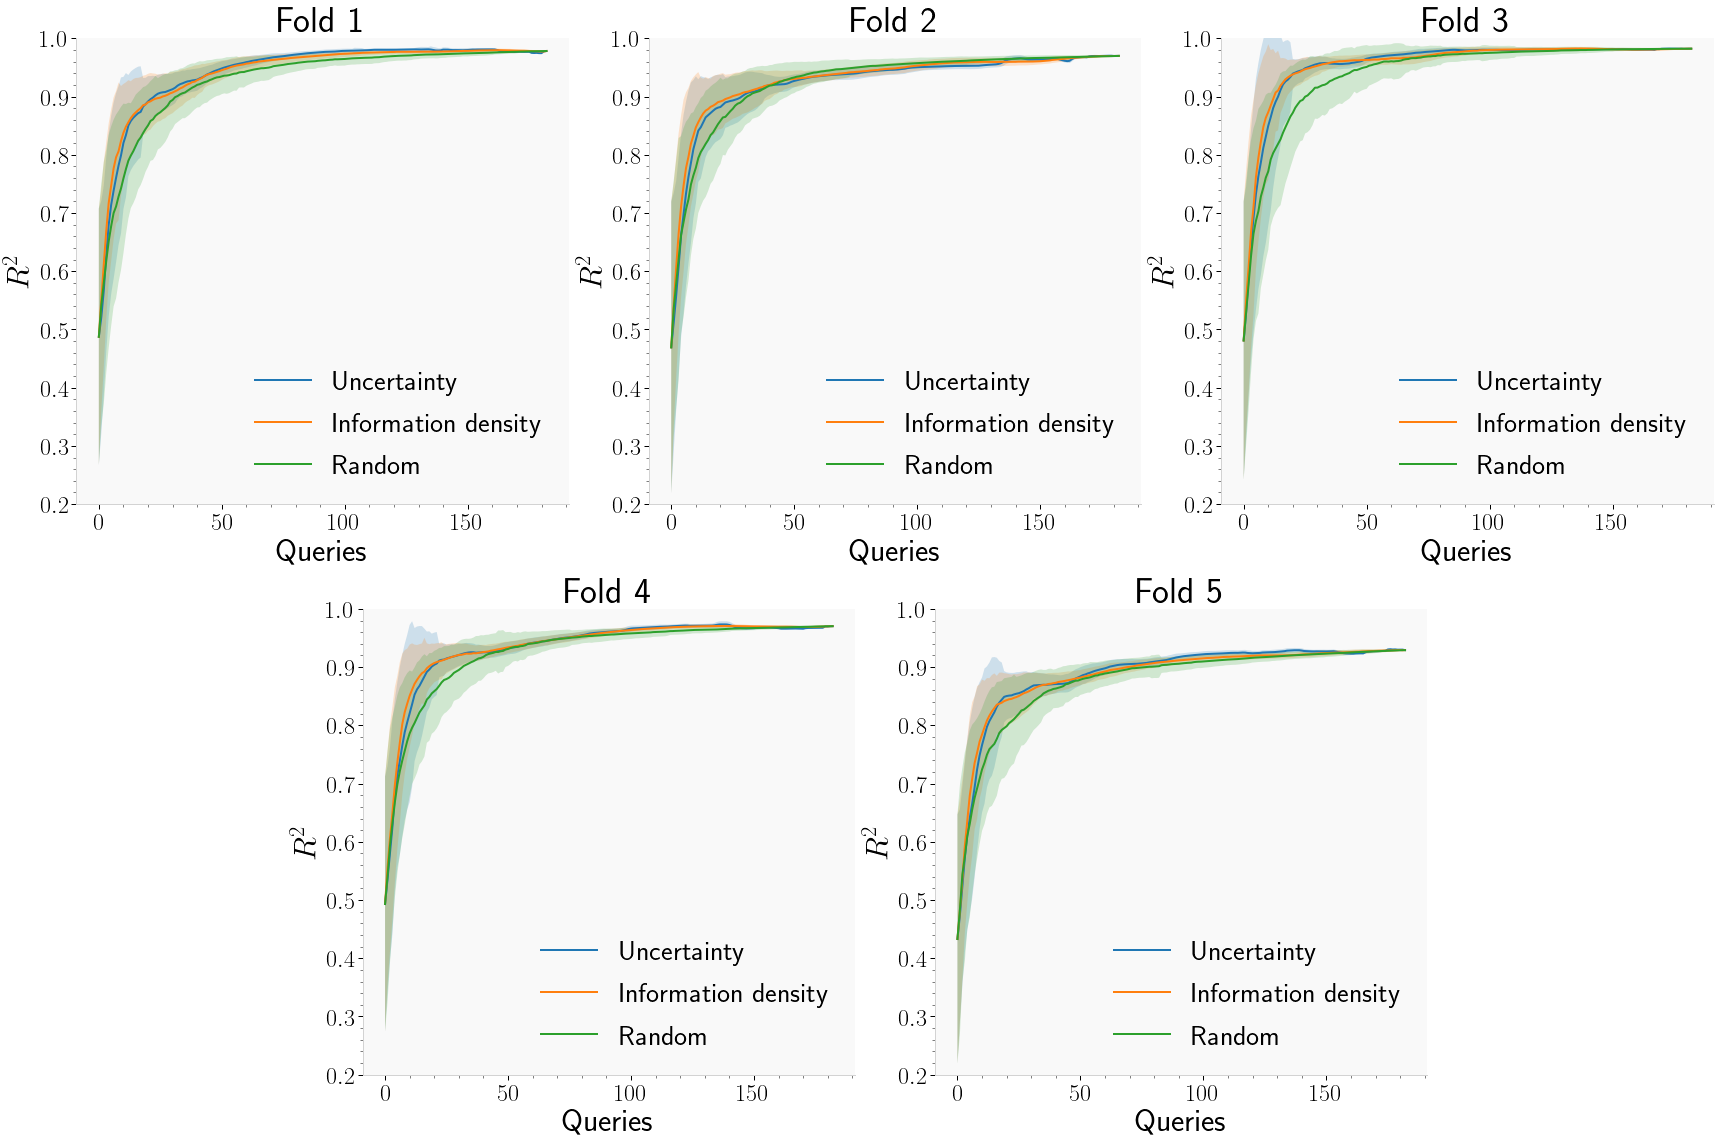

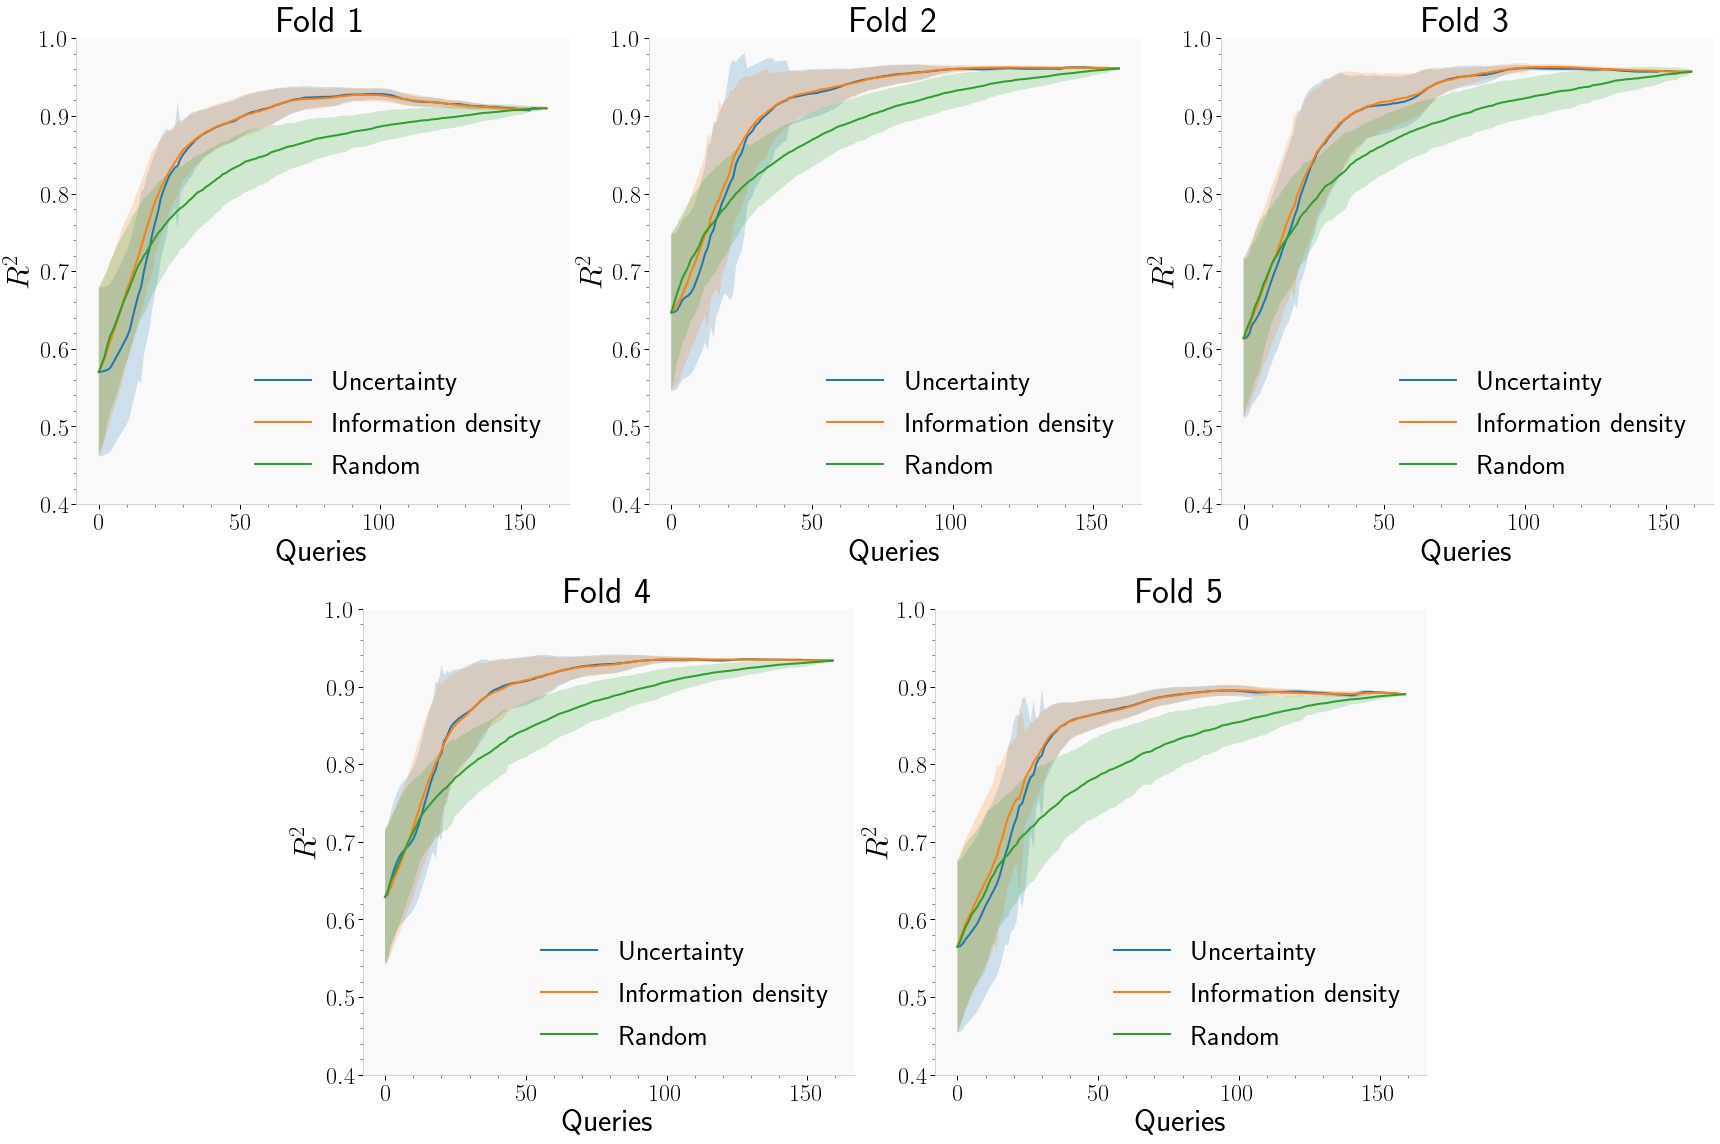

In [557]:
ylims = [(0,1.), (0.2,1.0), (0.4,1)]
for i, (name, results) in enumerate(kf_results.items()):
    fg = vis.visualise_kf(results, ylim=ylims[i])
    plt.savefig(f"Images/{name}_Different_active_learning_methods.svg",bbox_inches="tight")
    plt.savefig(f"Images/{name}_Different_active_learning_methods.pdf",bbox_inches="tight")
    plt.show()

### 134 Bug

134 in the inner mols set is actually molecule index 121 in the main dataset. For some reason, this point is never selected. The reason for this is that in kf.split, it always places 121 in the validation set, and, as a result, the point is never found in the training set. This means that it is never added to the data pool and causes the situation observed in which it is not observed to have any influence on training.

In [32]:
rep_colors = dict(zip(representations.keys(), ['#7fc97f','#beaed4','#fdc086']))
dataset_colours = {x : y for x, y in zip(["2IPs","3B69", "IL85", "S66"], ['#66c2a5','#fc8d62','#8da0cb','#e78ac3']) }

## Informativeness Scatterplot

/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


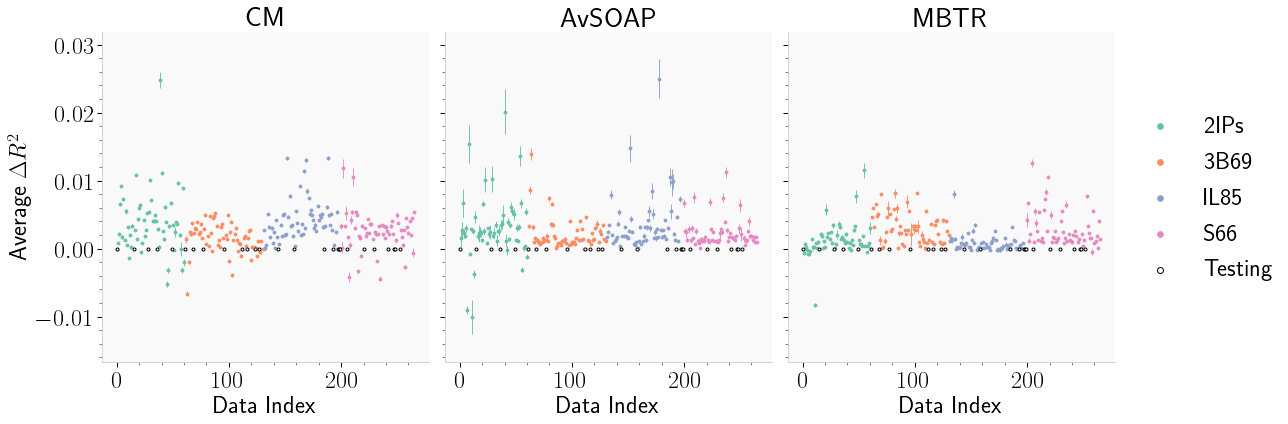

In [634]:
restructured_kf = utils.transform_fold_dict(kf_results)

fig, axs = plt.subplots(1,3,figsize=(18,6), sharey=True)

for ax,rep in zip(axs,representations.keys()):
    dset_size = 266
    inform = inform_funcs.strategy_informativeness(restructured_kf, strategies, rep=rep, runs=3, folds=5, scaler=None, seed_size=seed_sizes[rep], dset_size=dset_size, subset_idxs=inner_mols)


    for dset in datasets["blyp"].keys():
        idxs = df["Dataset"] == dset
        ax.errorbar(np.arange(dset_size)[idxs], np.mean(inform,axis=0)[idxs], yerr=np.var(inform, axis=0)[idxs], linewidth=0.9, ls='none', c=dataset_colours[dset], markersize=5)
        ax.scatter(np.arange(dset_size)[idxs], np.mean(inform,axis=0)[idxs], s=8, marker="o", color=str(dataset_colours[dset]), label=dset)
    
    ax.scatter(np.arange(dset_size)[outer_mols], np.zeros(len(outer_mols)), s=9, marker="o", color="w", edgecolor="k", label="Testing")
    ax.set_title(f"{rep}", fontsize=28)
    if rep == "CM":
        ax.set_ylabel("Average $\Delta R^2$", fontsize=24) #(x $10^{-3}$)
    #this = ax.get_yticks()
    #ax.set_yticklabels(np.arange(-7.5,12.5,2.5))
    ax.set_xlabel("Data Index", fontsize=24)

ax.legend(frameon=False, markerscale=2, fontsize=24, loc="center left", bbox_to_anchor=[1,0.5])

#ax.scatter(range(266), np.mean(inform,axis=0), s=5, marker="o")
#informativeness_scoring(kf_results["MBTR"]["Fold 1"]["Active"], seed_size=31)
plt.tight_layout()
plt.savefig("Images/Averaged Data Valuation AvSOAP New.svg", bbox_inches="tight")
plt.show()

## Informativeness Convergence

Need a way to determine how rapidly the informativeness is converging for points, and then need to set a threshold which, once passed, stops the system from running new calculations.

/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


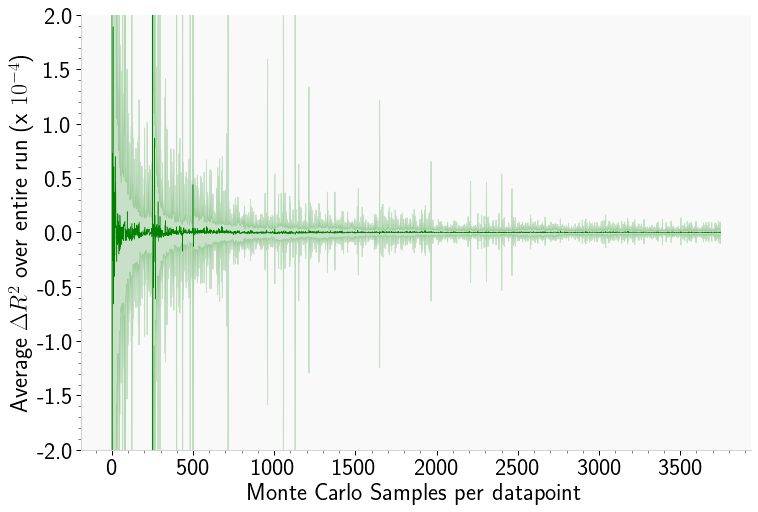

In [635]:
def plot_convergence(inform, ax=None, color="green"):

    means = np.mean(np.diff([inform[:x,inner_mols].mean(axis=0) for x in range(inform.shape[0])],axis=0), axis=1)
    variances = np.sqrt(np.var(np.diff([inform[:x,inner_mols].mean(axis=0) for x in range(inform.shape[0])],axis=0), axis=1))

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12,8))

    ax.plot(range(inform.shape[0]-1),means,  linewidth=0.5, color=color)
    ax.fill_between(range(inform.shape[0]-1), means - variances, means + variances, alpha=0.2, color=color)

plot_convergence(inform)
ax = plt.gca()
ax.set_ylim(-0.0002,0.0002)

ax.set_xlabel("Monte Carlo Samples per datapoint", fontsize=24)
ax.set_ylabel("Average $\Delta R^2$ over entire run (x $10^{-4}$)", fontsize=24)

this = ax.get_yticks()
ax.set_yticklabels([f"{x:.1f}" for x in np.array(this) * 10000])
this2 = ax.get_xticks()
ax.set_xticklabels([int(x) for x in this2])

plt.savefig("Images/Convergence_of_informativeness_New.svg", bbox_inches="tight")

## Informativeness Correlation

In [51]:

inform_funcs.fold_informativeness(restructured_kf["AvSOAP"], strategy="Random", runs=100, folds=5, dset_size=266, seed_size=9)

masked_array(
  data=[[--, 0.041631780808179863, -0.00013430112038137487, ..., --, --,
         --],
        [--, -0.0006128401157228236, 0.0002112991128467856, ..., --, --,
         --],
        [--, 0.0017864479582175852, 0.0003396647042422929, ..., --, --,
         --],
        ...,
        [--, --, 0.00018615122779053195, ..., --, --, --],
        [--, --, 0.01069015229609116, ..., --, --, --],
        [--, --, 0.0003682877103722282, ..., --, --, --]],
  mask=[[ True, False, False, ...,  True,  True,  True],
        [ True, False, False, ...,  True,  True,  True],
        [ True, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True, False, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True]],
  fill_value=0.0)

/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


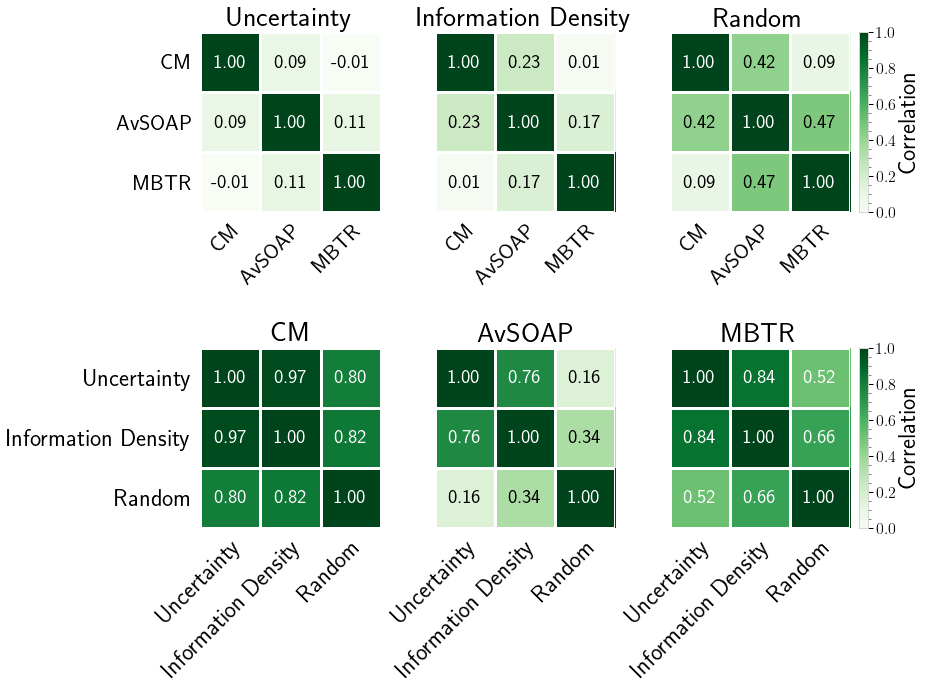

In [636]:
import chemdataval.chemdataval.informativeness as inform_funcs
importlib.reload(sys.modules['chemdataval.chemdataval.informativeness'])
import chemdataval.chemdataval.informativeness as inform_funcs


# FIX THIS
fig, axes = plt.subplots(2,3, figsize=(12,10), sharey='row')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

####################

axs = axes[0]

for i, (strat,ax) in enumerate(zip(strategies.keys(), axs)):
    corrs = inform_funcs.correlation_matrix(restructured_kf, dset_size=266, subset_idxs=inner_mols, strategy=strat, seed_size_dict=seed_sizes)
    im = ax.imshow(corrs, cmap="Greens", vmin=0,vmax=1)
    ax.set_xticks(np.arange(len(representations)))
    ax.set_xticklabels(labels=list(representations.keys()), rotation=45, ha="right",rotation_mode="anchor", fontsize=22)
    ax.set_yticks(np.arange(len(representations)))
    ax.set_yticklabels(labels=list(representations.keys()), fontsize=22)
    ax.set_title(strat, fontsize=28)
    ax.set_xticks(np.arange(len(strategies)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(strategies)+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    [ax.spines[key].set_visible(False) for key in ax.spines.keys()]
    ax.tick_params(which="both", left=False, bottom=False)

    text = vis.annotate_heatmap(im, data=corrs, fontsize=20)


axins = inset_axes(ax, width = "5%", height = "100%", loc = 'lower left',
                   bbox_to_anchor = (1.05, 0., 1, 1), bbox_transform = ax.transAxes,
                   borderpad = 0)

cbar = fig.colorbar(im, cax = axins, label="Correlation")
cbar.ax.set_ylabel("Correlation", rotation=90, va="bottom", fontsize=24, labelpad=25)
cbar.ax.tick_params(labelsize=16) 

#########################
axs2 = axes[1]

for rep,ax in zip(representations.keys(), axs2):
    corrs = inform_funcs.correlation_matrix_rep(restructured_kf[rep], strategies, dset_size=266, subset_idxs=inner_mols, seed_size=seed_sizes[rep])
    im = ax.imshow(corrs, cmap="Greens", vmin=0,vmax=1)
    ax.set_xticks(np.arange(len(strategies)))
    ax.set_xticklabels(labels=list(strategies.keys()), rotation=45, ha="right",rotation_mode="anchor", fontsize=24)
    ax.set_yticks(np.arange(len(strategies)))
    ax.set_yticklabels(labels=list(strategies.keys()), fontsize=24)
    ax.set_title(rep, fontsize=28)
    ax.set_xticks(np.arange(len(representations)+1)-.5, minor=True)
    ax.set_yticks(np.arange(len(representations)+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    [ax.spines[key].set_visible(False) for key in ax.spines.keys()]
    ax.tick_params(which="both", left=False, bottom=False)
    
    text = vis.annotate_heatmap(im, data=corrs, fontsize=20)

    
axins = inset_axes(ax, width = "5%", height = "100%", loc = 'lower left',
                   bbox_to_anchor = (1.05, 0., 1, 1), bbox_transform = ax.transAxes,
                   borderpad = 0)

cbar = fig.colorbar(im, cax = axins, label="Correlation")
cbar.ax.set_ylabel("Correlation", rotation=90, va="bottom", fontsize=24, labelpad=25)
cbar.ax.tick_params(labelsize=16) 

#########################

plt.tight_layout()
plt.savefig("Images/Combined_Correlation_Matrices_New.svg",bbox_inches="tight")
plt.show()

## β Value Testing

In [87]:
import warnings

X, Y = preprocess(avsoap_mols, df['dINT_BLYP_ref_cp'].to_numpy(), inner_mols)

βs = np.linspace(0.0,2,11)

strategies = {"Uncertainty"  : partial(active_test,β=0, query=GP_regression_std),
              "Information Density" : partial(active_test,β=1.0, query=GP_regression_std),
              "Information Density 2.0" : partial(active_test,β=2.0, query=GP_regression_std),
              #"Information Density 1.0" : partial(active_test,β=1.0, query=GP_regression_std),
              #"Information Density 1.5" : partial(active_test,β=1.5, query=GP_regression_std),
              #"Information Density 2.0" : partial(active_test,β=2.0, query=GP_regression_std),
              "Random"  : random_test}#,
              #"KMean"   : active_test,
              #"REMatch" : active_test}

with warnings.catch_warnings():
    seed = np.random.choice(inner_mols, size=(30,), replace=False)
    # Remove the convergence and nearing bound warnings that fill up the output section
    warnings.simplefilter("ignore")
    β_results = {}
    density_arr= 1/(1+cdist(X,X,metric="euclidean"))
    density_vector = np.mean(density_arr[inner_mols,:][:,inner_mols],axis=1)
    for β in tqdm.tqdm(βs):
        β_results[β] = active_test(seed, X, Y, inner_mols, (X[outer_mols], Y[outer_mols]), β=β, density_vector=density_vector, queries=None)


  0%|                                                    | 0/11 [00:00<?, ?it/s]


KeyboardInterrupt: 

β value testing must be done over the five inner folds to avoid data leakage from the testing set into the system.

In [64]:
β_results = {}
n_splits = 5
categorical = df.iloc[inner_mols]["Categorical"].to_numpy()

kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=state) # Using this split so that the dataset classes are balanced.
#kf = KFold(n_splits=n_splits, shuffle=True, random_state=state)

for name, X in representations.items():
    if name == "CM" or name == "MBTR":
        continue
    print(f"Running {name}")
    β_results[name] = fold_testing(X[inner_mols], Y[inner_mols], strategies=strategies, 
                                    categorical=categorical, 
                                    kf=kf, 
                                    random_runs=3, 
                                    kernel=kernel, 
                                    seed_size=50, 
                                    debug=True)

Running AvSOAP
Running fold 1
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Information Density 2.0
	Random
Queries: 141


  0%|                                                     | 0/3 [00:00<?, ?it/s]

[0.060 0.090 0.103 0.144 0.157 0.109 0.140 0.189 0.125 0.157 0.237 0.206
 0.254 0.163 0.096 0.165 0.003 0.175 0.149 0.113 0.000 0.116 0.004 0.063
 0.202 0.116 0.151 0.130 0.150 0.236 0.207 0.218 0.219 0.220 0.253 0.223
 0.133 0.217 0.233 0.151 0.165 0.151 0.179 0.185 0.084 0.149 0.065 0.244
 0.190 0.195 0.155 0.123 0.090 0.213 0.198 0.189 0.125 0.188 0.258 0.144
 0.097 0.136 0.230 0.153 0.195 0.171 0.215 0.202 0.245 0.177 0.057 0.146
 0.179 0.235 0.139 0.164 0.219 0.178 0.213 0.245]
[0.006 0.009 0.011 0.013 0.016 0.011 0.014 0.018 0.012 0.017 0.023 0.020
 0.016 0.010 0.019 0.000 0.018 0.014 0.011 0.000 0.025 0.016 0.007 0.021
 0.017 0.013 0.017 0.014 0.017 0.025 0.020 0.023 0.025 0.021 0.026 0.019
 0.014 0.022 0.027 0.018 0.018 0.017 0.022 0.018 0.010 0.015 0.006 0.025
 0.019 0.021 0.019 0.012 0.010 0.024 0.023 0.020 0.012 0.019 0.028 0.016
 0.011 0.016 0.025 0.016 0.022 0.020 0.022 0.021 0.026 0.017 0.006 0.016
 0.019 0.026 0.015 0.019 0.023 0.019 0.023 0.027]
[0.001 0.001 0.001 0.002

 33%|███████████████                              | 1/3 [00:14<00:29, 14.99s/it]

[0.254 0.220 0.212 0.298 0.245 0.257 0.344 0.287 0.292 0.259 0.304 0.278
 0.339 0.307 0.262 0.299 0.239 0.234 0.294 0.283 0.278 0.236 0.244 0.221
 0.278 0.287 0.236 0.282 0.345 0.330 0.316 0.353 0.321 0.310 0.271 0.332
 0.346 0.314 0.246 0.255 0.357 0.292 0.281 0.287 0.296 0.300 0.276 0.269
 0.310 0.322 0.281 0.276 0.237 0.272 0.306 0.231 0.309 0.305 0.278 0.242
 0.330 0.360 0.289 0.296 0.322 0.280 0.327 0.305 0.260 0.223 0.326 0.298
 0.293 0.353 0.276 0.271 0.285 0.318 0.326 0.305]
[0.026 0.021 0.023 0.035 0.030 0.027 0.026 0.035 0.034 0.029 0.023 0.030
 0.028 0.034 0.024 0.032 0.023 0.023 0.031 0.028 0.031 0.025 0.024 0.023
 0.028 0.033 0.026 0.037 0.037 0.037 0.034 0.030 0.036 0.032 0.040 0.032
 0.036 0.034 0.025 0.029 0.037 0.033 0.030 0.029 0.030 0.036 0.030 0.026
 0.035 0.033 0.032 0.029 0.027 0.028 0.030 0.025 0.030 0.032 0.031 0.027
 0.041 0.031 0.031 0.035 0.032 0.035 0.034 0.025 0.041 0.033 0.039 0.036
 0.032 0.035 0.029 0.029 0.027 0.032 0.034 0.032]
[0.003 0.002 0.002 0.003

 67%|██████████████████████████████               | 2/3 [00:25<00:12, 12.26s/it]

[0.188 0.251 0.228 0.209 0.218 0.182 0.211 0.174 0.175 0.180 0.216 0.188
 0.198 0.170 0.213 0.151 0.194 0.107 0.149 0.178 0.227 0.089 0.166 0.154
 0.237 0.165 0.125 0.239 0.233 0.251 0.244 0.223 0.241 0.190 0.222 0.166
 0.234 0.113 0.098 0.200 0.209 0.212 0.213 0.176 0.174 0.220 0.180 0.161
 0.188 0.168 0.236 0.200 0.139 0.197 0.215 0.180 0.241 0.243 0.167 0.146
 0.244 0.233 0.180 0.227 0.193 0.226 0.184 0.225 0.186 0.241 0.209 0.201
 0.258 0.233 0.198 0.248 0.256 0.186 0.261 0.216]
[0.020 0.026 0.021 0.022 0.024 0.017 0.021 0.019 0.021 0.017 0.022 0.017
 0.020 0.017 0.023 0.015 0.021 0.011 0.016 0.020 0.024 0.010 0.019 0.014
 0.023 0.018 0.014 0.023 0.022 0.023 0.025 0.029 0.026 0.022 0.021 0.023
 0.017 0.028 0.012 0.010 0.027 0.021 0.021 0.022 0.021 0.018 0.022 0.024
 0.018 0.018 0.020 0.024 0.017 0.013 0.019 0.023 0.017 0.027 0.019 0.026
 0.023 0.016 0.023 0.019 0.026 0.019 0.026 0.021 0.023 0.020 0.023 0.020
 0.022 0.028 0.025 0.021 0.028 0.018 0.027 0.023]
[0.002 0.002 0.003 0.003

100%|█████████████████████████████████████████████| 3/3 [00:36<00:00, 12.20s/it]


Running fold 2
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Information Density 2.0
	Random
Queries: 141


  0%|                                                     | 0/3 [00:00<?, ?it/s]

[0.212 0.180 0.216 0.322 0.300 0.177 0.198 0.245 0.331 0.302 0.282 0.300
 0.271 0.319 0.274 0.283 0.178 0.147 0.287 0.320 0.144 0.228 0.222 0.254
 0.146 0.202 0.146 0.331 0.247 0.322 0.313 0.255 0.320 0.262 0.295 0.306
 0.325 0.285 0.211 0.260 0.294 0.221 0.285 0.291 0.226 0.213 0.273 0.260
 0.246 0.200 0.226 0.254 0.222 0.179 0.189 0.178 0.255 0.190 0.248 0.294
 0.321 0.243 0.167 0.313 0.256 0.238 0.266 0.244 0.224 0.191 0.213 0.304
 0.256 0.255 0.323 0.317 0.304 0.279 0.270 0.301]
[0.020 0.019 0.023 0.033 0.031 0.020 0.020 0.024 0.033 0.032 0.030 0.032
 0.031 0.035 0.031 0.031 0.018 0.016 0.031 0.032 0.016 0.024 0.022 0.026
 0.015 0.020 0.016 0.023 0.036 0.032 0.028 0.033 0.029 0.032 0.033 0.035
 0.027 0.036 0.023 0.027 0.033 0.022 0.030 0.028 0.022 0.022 0.031 0.027
 0.027 0.021 0.025 0.029 0.024 0.025 0.021 0.019 0.031 0.022 0.027 0.028
 0.035 0.031 0.018 0.036 0.027 0.024 0.029 0.026 0.024 0.023 0.025 0.031
 0.029 0.028 0.032 0.032 0.033 0.033 0.026 0.032]
[0.002 0.002 0.002 0.003

 33%|███████████████                              | 1/3 [00:13<00:26, 13.06s/it]

[0.109 0.058 0.112 0.108 0.207 0.196 0.113 0.141 0.220 0.208 0.190 0.168
 0.164 0.176 0.149 0.148 0.082 0.082 0.144 0.200 0.000 0.097 0.129 0.060
 0.181 0.005 0.005 0.119 0.140 0.096 0.194 0.160 0.182 0.201 0.185 0.174
 0.225 0.225 0.208 0.114 0.154 0.133 0.133 0.127 0.162 0.184 0.124 0.101
 0.115 0.111 0.113 0.047 0.096 0.168 0.092 0.159 0.094 0.127 0.172 0.096
 0.097 0.202 0.197 0.223 0.105 0.132 0.226 0.140 0.130 0.141 0.054 0.180
 0.186 0.149 0.202 0.156 0.194 0.158 0.137 0.192]
[0.012 0.006 0.013 0.011 0.023 0.019 0.011 0.013 0.025 0.021 0.019 0.018
 0.019 0.015 0.016 0.009 0.008 0.017 0.021 0.000 0.015 0.014 0.010 0.013
 0.020 0.001 0.001 0.015 0.016 0.011 0.019 0.024 0.022 0.020 0.019 0.021
 0.018 0.025 0.021 0.012 0.017 0.013 0.014 0.013 0.016 0.017 0.013 0.010
 0.013 0.012 0.012 0.005 0.011 0.017 0.011 0.018 0.010 0.016 0.019 0.010
 0.009 0.023 0.022 0.024 0.012 0.014 0.023 0.015 0.015 0.018 0.006 0.018
 0.021 0.016 0.019 0.016 0.018 0.018 0.014 0.021]
[0.001 0.001 0.002 0.001

 67%|██████████████████████████████               | 2/3 [00:28<00:14, 14.40s/it]

[0.221 0.278 0.256 0.263 0.334 0.328 0.309 0.375 0.269 0.341 0.260 0.372
 0.316 0.319 0.226 0.201 0.333 0.375 0.200 0.260 0.299 0.244 0.276 0.200
 0.200 0.291 0.383 0.244 0.373 0.297 0.315 0.340 0.366 0.355 0.379 0.314
 0.244 0.306 0.345 0.282 0.303 0.311 0.356 0.327 0.240 0.286 0.277 0.324
 0.262 0.212 0.300 0.292 0.325 0.321 0.298 0.309 0.230 0.296 0.350 0.284
 0.249 0.354 0.251 0.280 0.348 0.285 0.265 0.290 0.294 0.202 0.334 0.299
 0.387 0.376 0.327 0.352 0.390 0.290 0.311 0.356]
[0.023 0.029 0.026 0.030 0.033 0.034 0.037 0.030 0.039 0.030 0.027 0.036
 0.036 0.032 0.031 0.034 0.035 0.042 0.022 0.027 0.033 0.024 0.028 0.019
 0.021 0.032 0.038 0.023 0.038 0.032 0.043 0.038 0.031 0.039 0.039 0.038
 0.034 0.026 0.030 0.037 0.027 0.028 0.031 0.030 0.035 0.024 0.028 0.028
 0.029 0.021 0.034 0.032 0.034 0.033 0.028 0.033 0.034 0.027 0.036 0.038
 0.029 0.027 0.039 0.028 0.029 0.038 0.028 0.027 0.034 0.033 0.020 0.036
 0.032 0.030 0.037 0.031 0.039 0.029 0.033 0.034]
[0.003 0.003 0.003 0.002

100%|█████████████████████████████████████████████| 3/3 [00:39<00:00, 13.24s/it]


Running fold 3
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Information Density 2.0
	Random
Queries: 141


  0%|                                                     | 0/3 [00:00<?, ?it/s]

[0.143 0.073 0.120 0.132 0.215 0.205 0.120 0.113 0.187 0.149 0.167 0.193
 0.174 0.165 0.125 0.156 0.087 0.042 0.186 0.215 0.174 0.170 0.118 0.118
 0.155 0.114 0.042 0.157 0.218 0.041 0.145 0.144 0.223 0.208 0.133 0.147
 0.174 0.199 0.201 0.204 0.196 0.151 0.152 0.159 0.155 0.132 0.108 0.104
 0.165 0.168 0.092 0.109 0.121 0.164 0.078 0.092 0.087 0.119 0.126 0.160
 0.095 0.141 0.185 0.163 0.206 0.172 0.151 0.196 0.132 0.173 0.220 0.170
 0.127 0.153 0.206 0.186 0.220 0.147 0.211 0.163]
[0.014 0.008 0.015 0.014 0.023 0.021 0.012 0.011 0.019 0.016 0.017 0.022
 0.019 0.017 0.012 0.016 0.009 0.004 0.020 0.021 0.020 0.016 0.012 0.013
 0.017 0.010 0.004 0.016 0.025 0.004 0.016 0.016 0.022 0.012 0.013 0.019
 0.024 0.023 0.024 0.021 0.016 0.015 0.018 0.017 0.013 0.012 0.011 0.018
 0.021 0.010 0.010 0.013 0.017 0.009 0.011 0.009 0.014 0.014 0.018 0.012
 0.023 0.016 0.020 0.019 0.024 0.019 0.017 0.021 0.012 0.018 0.022 0.017
 0.014 0.015 0.021 0.025 0.020 0.024 0.017 0.016]
[0.002 0.001 0.002 0.001

 33%|███████████████                              | 1/3 [00:14<00:28, 14.28s/it]

[0.221 0.172 0.213 0.226 0.317 0.294 0.194 0.207 0.250 0.280 0.324 0.306
 0.238 0.196 0.185 0.243 0.155 0.254 0.237 0.162 0.197 0.196 0.234 0.226
 0.141 0.192 0.237 0.319 0.302 0.306 0.305 0.306 0.216 0.283 0.319 0.330
 0.318 0.161 0.253 0.243 0.277 0.212 0.243 0.193 0.275 0.322 0.306 0.284
 0.201 0.212 0.275 0.255 0.184 0.215 0.197 0.212 0.235 0.262 0.270 0.323
 0.253 0.184 0.303 0.326 0.205 0.262 0.294 0.259 0.215 0.266 0.225 0.225
 0.246 0.303 0.319 0.301 0.315 0.232 0.210 0.315]
[0.021 0.019 0.020 0.021 0.031 0.029 0.017 0.020 0.023 0.026 0.029 0.030
 0.025 0.018 0.018 0.023 0.012 0.025 0.024 0.015 0.020 0.019 0.023 0.025
 0.030 0.013 0.029 0.021 0.029 0.031 0.030 0.029 0.030 0.016 0.027 0.022
 0.017 0.031 0.022 0.029 0.020 0.025 0.018 0.025 0.028 0.031 0.029 0.020
 0.020 0.023 0.028 0.018 0.021 0.020 0.021 0.022 0.024 0.025 0.032 0.025
 0.018 0.023 0.024 0.030 0.026 0.020 0.023 0.020 0.021 0.024 0.028 0.031
 0.029 0.030 0.031 0.023 0.032 0.029 0.032 0.022]
[0.003 0.003 0.002 0.002

 67%|██████████████████████████████               | 2/3 [00:24<00:12, 12.17s/it]

[0.170 0.075 0.140 0.154 0.261 0.243 0.135 0.129 0.197 0.223 0.272 0.168
 0.185 0.139 0.167 0.104 0.104 0.246 0.180 0.160 0.000 0.131 0.006 0.122
 0.159 0.001 0.254 0.119 0.172 0.267 0.252 0.248 0.245 0.241 0.142 0.234
 0.242 0.271 0.252 0.154 0.135 0.189 0.189 0.270 0.160 0.144 0.175 0.157
 0.129 0.135 0.142 0.167 0.073 0.201 0.197 0.237 0.215 0.154 0.178 0.189
 0.092 0.135 0.174 0.262 0.225 0.167 0.152 0.232 0.197 0.153 0.233 0.191
 0.202 0.152 0.178 0.235 0.151 0.257 0.276 0.217]
[0.029 0.022 0.008 0.013 0.017 0.028 0.026 0.014 0.014 0.020 0.022 0.030
 0.019 0.019 0.014 0.016 0.012 0.011 0.028 0.018 0.016 0.000 0.014 0.001
 0.012 0.017 0.000 0.030 0.011 0.018 0.030 0.029 0.026 0.025 0.026 0.013
 0.024 0.027 0.030 0.032 0.015 0.016 0.020 0.018 0.018 0.015 0.022 0.016
 0.014 0.015 0.015 0.014 0.007 0.024 0.020 0.028 0.023 0.017 0.018 0.022
 0.010 0.016 0.021 0.028 0.025 0.018 0.015 0.023 0.021 0.015 0.026 0.019
 0.021 0.020 0.028 0.028 0.023 0.016 0.030 0.022]
[0.003 0.003 0.001 0.001

100%|█████████████████████████████████████████████| 3/3 [00:41<00:00, 13.80s/it]


Running fold 4
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Information Density 2.0
	Random
Queries: 141


  0%|                                                     | 0/3 [00:00<?, ?it/s]

[0.167 0.159 0.199 0.312 0.221 0.314 0.197 0.332 0.307 0.263 0.180 0.309
 0.269 0.330 0.292 0.245 0.205 0.300 0.239 0.231 0.329 0.242 0.299 0.157
 0.230 0.261 0.289 0.293 0.239 0.266 0.278 0.315 0.335 0.229 0.309 0.316
 0.280 0.277 0.274 0.275 0.274 0.202 0.282 0.279 0.272 0.265 0.208 0.188
 0.236 0.175 0.245 0.192 0.195 0.263 0.206 0.259 0.288 0.259 0.293 0.274
 0.322 0.322 0.251 0.222 0.285 0.220 0.283 0.281 0.241 0.235 0.341 0.258
 0.298 0.344 0.258 0.302 0.278 0.271 0.347 0.307]
[0.017 0.017 0.037 0.032 0.035 0.026 0.035 0.021 0.034 0.035 0.028 0.017
 0.030 0.019 0.028 0.028 0.022 0.034 0.037 0.033 0.026 0.026 0.034 0.017
 0.030 0.029 0.034 0.031 0.024 0.030 0.031 0.033 0.037 0.026 0.028 0.034
 0.032 0.028 0.030 0.037 0.031 0.021 0.029 0.029 0.035 0.026 0.028 0.021
 0.020 0.024 0.018 0.026 0.019 0.021 0.028 0.022 0.027 0.034 0.028 0.027
 0.030 0.036 0.027 0.024 0.031 0.024 0.030 0.029 0.025 0.026 0.033 0.025
 0.033 0.035 0.028 0.034 0.024 0.030 0.029 0.032]
[0.002 0.002 0.004 0.003

 33%|███████████████                              | 1/3 [00:14<00:28, 14.40s/it]

[0.128 0.066 0.052 0.246 0.183 0.111 0.197 0.186 0.195 0.154 0.230 0.239
 0.135 0.109 0.165 0.085 0.146 0.205 0.114 0.222 0.111 0.242 0.149 0.208
 0.175 0.174 0.132 0.170 0.202 0.205 0.149 0.176 0.194 0.219 0.244 0.133
 0.226 0.190 0.191 0.184 0.188 0.201 0.231 0.098 0.099 0.181 0.179 0.104
 0.179 0.170 0.112 0.107 0.082 0.138 0.175 0.154 0.067 0.111 0.099 0.162
 0.181 0.127 0.223 0.177 0.122 0.161 0.114 0.198 0.149 0.209 0.166 0.155
 0.145 0.059 0.167 0.194 0.243 0.196 0.172 0.192]
[0.012 0.006 0.006 0.021 0.012 0.021 0.021 0.021 0.014 0.023 0.015 0.012
 0.018 0.010 0.014 0.020 0.011 0.024 0.012 0.026 0.015 0.022 0.018 0.020
 0.014 0.020 0.023 0.024 0.017 0.019 0.020 0.022 0.014 0.021 0.020 0.020
 0.019 0.021 0.020 0.024 0.011 0.011 0.017 0.018 0.011 0.019 0.017 0.011
 0.011 0.009 0.014 0.019 0.015 0.013 0.012 0.010 0.018 0.020 0.013 0.019
 0.015 0.013 0.015 0.012 0.021 0.016 0.022 0.018 0.025 0.018 0.016 0.005
 0.017 0.021 0.024 0.023 0.021 0.025 0.017 0.020]
[0.003 0.001 0.001 0.001

 67%|██████████████████████████████               | 2/3 [00:29<00:14, 14.55s/it]

[0.109 0.334 0.308 0.306 0.241 0.289 0.221 0.180 0.284 0.257 0.307 0.292
 0.198 0.110 0.210 0.247 0.253 0.174 0.262 0.272 0.171 0.201 0.179 0.046
 0.131 0.276 0.277 0.206 0.240 0.261 0.304 0.328 0.184 0.333 0.315 0.255
 0.255 0.256 0.306 0.255 0.226 0.238 0.150 0.230 0.240 0.277 0.157 0.223
 0.220 0.151 0.134 0.272 0.230 0.253 0.243 0.229 0.231 0.226 0.277 0.201
 0.256 0.192 0.150 0.267 0.243 0.270 0.209 0.217 0.325 0.324 0.303 0.208
 0.286 0.213 0.246 0.342 0.291 0.271 0.339 0.303]
[0.011 0.031 0.034 0.031 0.026 0.034 0.022 0.019 0.030 0.029 0.036 0.033
 0.020 0.011 0.027 0.019 0.027 0.015 0.030 0.028 0.018 0.022 0.020 0.005
 0.015 0.032 0.029 0.022 0.026 0.028 0.034 0.033 0.020 0.031 0.034 0.027
 0.029 0.022 0.033 0.029 0.024 0.027 0.016 0.024 0.025 0.030 0.016 0.021
 0.023 0.016 0.014 0.029 0.025 0.026 0.026 0.026 0.023 0.020 0.030 0.021
 0.027 0.019 0.016 0.023 0.027 0.029 0.022 0.023 0.034 0.034 0.032 0.022
 0.027 0.026 0.026 0.037 0.030 0.030 0.035 0.029]
[0.001 0.003 0.003 0.003

100%|█████████████████████████████████████████████| 3/3 [00:42<00:00, 14.01s/it]


Running fold 5
Training set size: 191
Testing set size: 48
Strategies:
	Uncertainty
	Information Density
	Information Density 2.0
	Random
Queries: 141


  0%|                                                     | 0/3 [00:00<?, ?it/s]

[0.105 0.122 0.148 0.186 0.122 0.199 0.177 0.164 0.102 0.219 0.137 0.123
 0.145 0.132 0.113 0.127 0.059 0.141 0.125 0.113 0.000 0.141 0.150 0.005
 0.004 0.141 0.149 0.197 0.169 0.203 0.204 0.166 0.201 0.220 0.163 0.197
 0.177 0.148 0.173 0.196 0.210 0.193 0.191 0.106 0.128 0.123 0.120 0.205
 0.160 0.228 0.136 0.091 0.072 0.163 0.124 0.158 0.167 0.178 0.157 0.152
 0.151 0.229 0.221 0.148 0.110 0.167 0.181 0.182 0.116 0.196 0.149 0.122
 0.139 0.189 0.215 0.191 0.153 0.158 0.198 0.218]
[0.012 0.014 0.014 0.024 0.022 0.015 0.021 0.011 0.011 0.023 0.015 0.020
 0.011 0.016 0.016 0.011 0.014 0.006 0.017 0.014 0.012 0.000 0.015 0.016
 0.001 0.000 0.018 0.017 0.019 0.016 0.021 0.023 0.019 0.022 0.027 0.019
 0.021 0.021 0.016 0.019 0.018 0.024 0.021 0.017 0.012 0.014 0.013 0.014
 0.023 0.017 0.026 0.016 0.010 0.007 0.018 0.013 0.017 0.020 0.020 0.013
 0.015 0.017 0.019 0.016 0.010 0.018 0.020 0.020 0.013 0.023 0.015 0.012
 0.015 0.022 0.024 0.016 0.022 0.016 0.019 0.023]
[0.001 0.001 0.002 0.002

 33%|███████████████                              | 1/3 [00:15<00:30, 15.29s/it]

[0.244 0.202 0.208 0.245 0.208 0.162 0.131 0.185 0.176 0.107 0.177 0.140
 0.121 0.156 0.145 0.096 0.172 0.096 0.153 0.077 0.095 0.152 0.100 0.145
 0.005 0.005 0.160 0.142 0.220 0.232 0.216 0.214 0.116 0.241 0.241 0.179
 0.209 0.179 0.150 0.170 0.194 0.106 0.144 0.162 0.173 0.161 0.164 0.152
 0.136 0.130 0.106 0.142 0.181 0.169 0.162 0.214 0.186 0.170 0.151 0.080
 0.245 0.160 0.132 0.176 0.187 0.187 0.129 0.192 0.197 0.246 0.252 0.198
 0.169 0.212 0.196 0.159 0.223 0.159 0.213 0.220]
[0.013 0.015 0.023 0.014 0.013 0.017 0.018 0.017 0.021 0.015 0.024 0.014
 0.018 0.016 0.009 0.019 0.010 0.016 0.009 0.010 0.011 0.016 0.017 0.001
 0.000 0.017 0.016 0.024 0.025 0.026 0.012 0.021 0.019 0.023 0.020 0.018
 0.018 0.023 0.011 0.015 0.019 0.019 0.016 0.018 0.017 0.014 0.014 0.012
 0.015 0.018 0.018 0.018 0.025 0.021 0.016 0.016 0.008 0.027 0.018 0.013
 0.019 0.018 0.023 0.019 0.022 0.021 0.022 0.023 0.027 0.022 0.018 0.024
 0.028 0.021 0.022 0.022 0.026 0.020 0.022 0.026]
[0.001 0.002 0.003 0.002

 67%|██████████████████████████████               | 2/3 [00:30<00:15, 15.40s/it]

[0.289 0.243 0.245 0.177 0.265 0.169 0.175 0.301 0.307 0.266 0.239 0.233
 0.215 0.140 0.241 0.208 0.237 0.177 0.320 0.001 0.201 0.007 0.143 0.208
 0.002 0.202 0.196 0.310 0.245 0.304 0.295 0.316 0.199 0.295 0.259 0.298
 0.283 0.222 0.082 0.082 0.282 0.127 0.246 0.251 0.267 0.281 0.238 0.248
 0.210 0.173 0.199 0.242 0.193 0.251 0.234 0.219 0.276 0.233 0.214 0.319
 0.330 0.214 0.179 0.315 0.268 0.300 0.287 0.263 0.324 0.243 0.266 0.280
 0.236 0.297 0.268 0.222 0.308 0.225 0.294 0.315]
[0.032 0.027 0.023 0.018 0.028 0.017 0.028 0.031 0.034 0.026 0.032 0.026
 0.028 0.022 0.015 0.026 0.021 0.024 0.019 0.034 0.000 0.001 0.016 0.019
 0.022 0.000 0.022 0.021 0.034 0.034 0.035 0.033 0.032 0.034 0.024 0.034
 0.027 0.035 0.031 0.023 0.009 0.009 0.030 0.012 0.024 0.028 0.030 0.029
 0.026 0.029 0.019 0.019 0.021 0.027 0.019 0.023 0.022 0.021 0.032 0.026
 0.018 0.035 0.023 0.016 0.032 0.026 0.031 0.025 0.026 0.032 0.027 0.031
 0.029 0.023 0.035 0.029 0.024 0.033 0.025 0.031]
[0.004 0.003 0.002 0.005

100%|█████████████████████████████████████████████| 3/3 [00:45<00:00, 15.17s/it]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


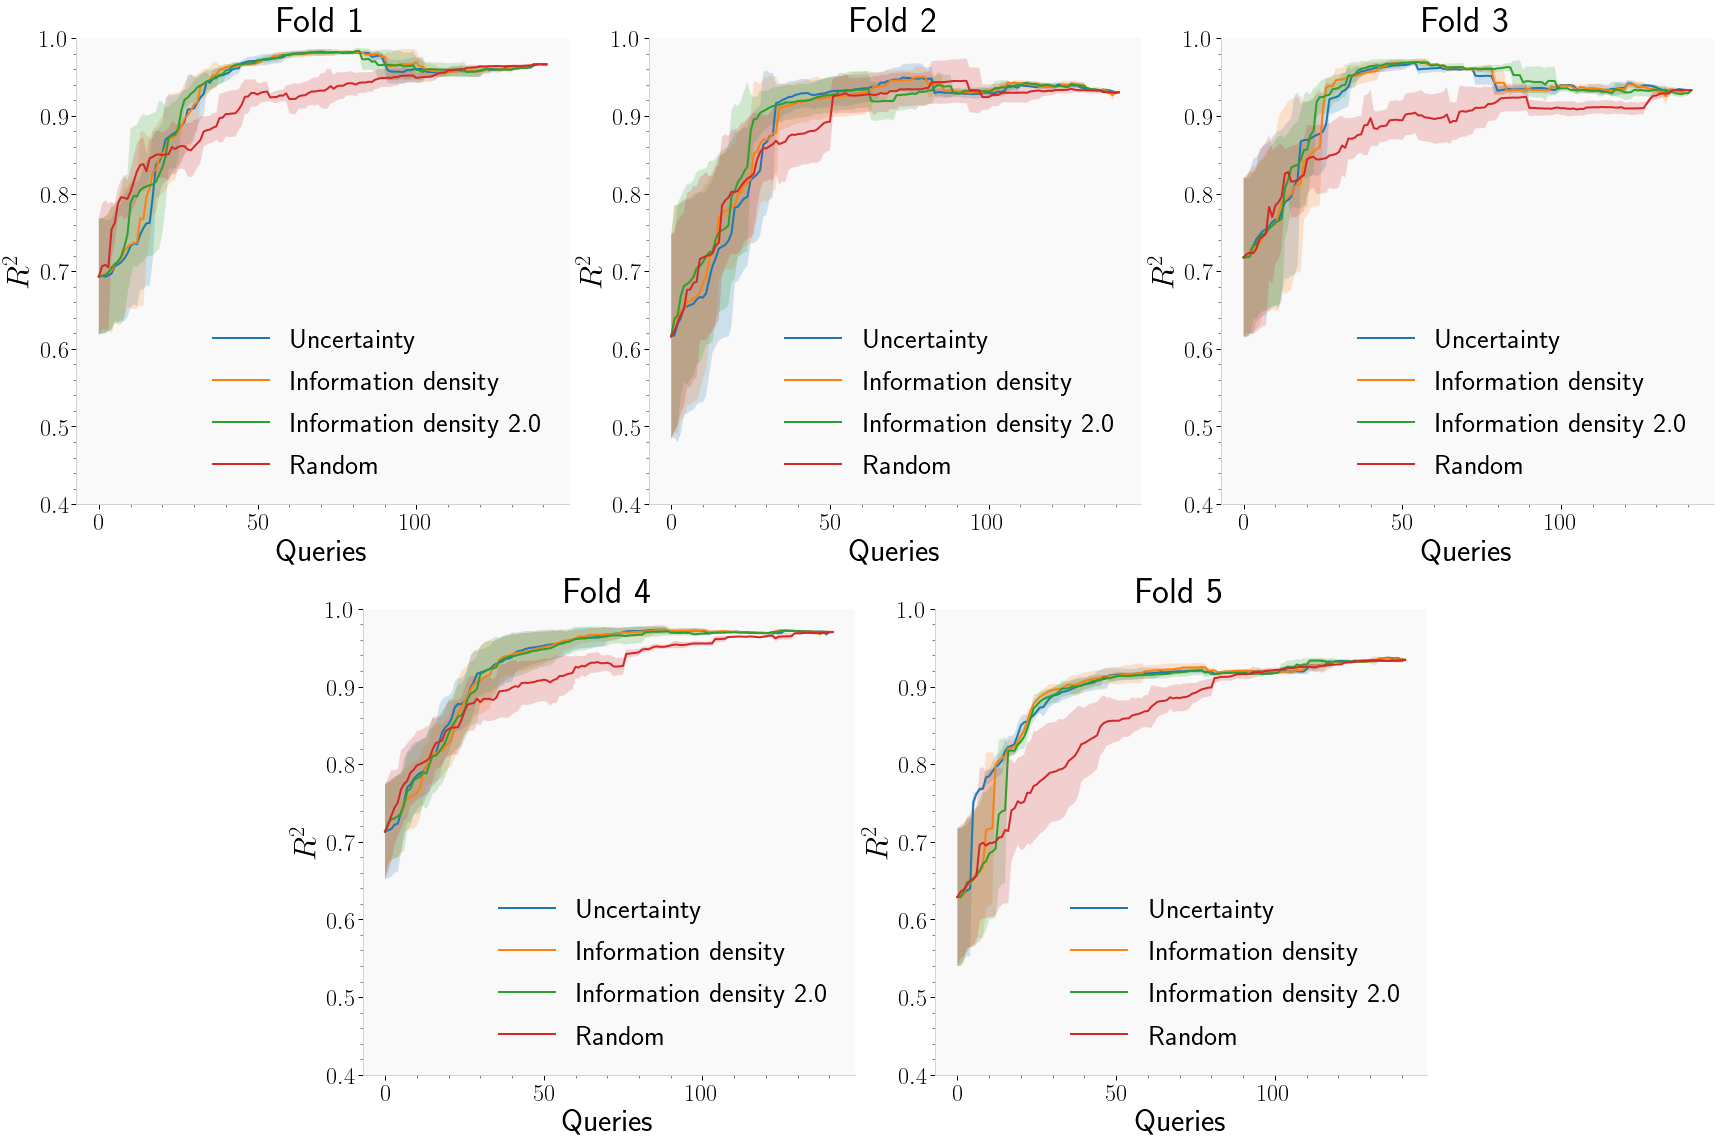

In [66]:
for name, results in β_results.items():
    fg = visualise_kf(results, ylim=(0.4,1))

In [1146]:
import warnings

β_runs = 2
β_rep_results = {}

for rep in representations.keys():
    if rep == "CM" or rep == "MBTR":
        continue
    print(f"Running {rep}")

    folds = {f"Fold {x}" : {} for x in range(1,6)}
    
    for kf_idx,item in enumerate(kf.split(processed_X[rep][inner_mols],categorical[inner_mols])):

        print(f"Running fold {kf_idx+1}")
        train_index, test_index = inner_mols, outer_mols# item

        # Standardise the data using only the train components.
        X̂, Ŷ = preprocess(representations[rep], df['dINT_BLYP_ref_cp'].to_numpy(), train_index)

        test = (X̂[test_index], Ŷ[test_index])

        βs = [0,1.0,2.0,5.0,10.0]
        β_results = {β : ([],[]) for β in βs}

        density_arr = 1/(1+cdist(X̂,X̂,metric="euclidean"))
        density_vector = np.mean(density_arr[train_index,:][:,train_index],axis=1)

        with warnings.catch_warnings():
            for _ in range(β_runs):
                seed = np.random.choice(train_index, size=(30,), replace=False)
                # Remove the convergence and nearing bound warnings that fill up the output section
                warnings.simplefilter("ignore") 
                
                for β in tqdm.tqdm(βs):
                    idxs, scores = active_test(seed, X̂, Ŷ, train_index, test, β=β, density_vector=density_vector, queries=None, kernel=kernel)
                    β_results[β][0].append(idxs)
                    β_results[β][1].append(scores)

        folds[f"Fold {kf_idx+1}"] = β_results

Running AvSOAP
Running fold 1


NameError: name 'cdist' is not defined

In [94]:
import warnings

β_runs = 5
β_rep_results = {}

for rep in representations.keys():
    if rep == "CM" or rep == "MBTR":
        continue
    print(f"Running {rep}")
    X, Y = preprocess(representations[rep], df['dINT_BLYP_ref_cp'].to_numpy(), inner_mols)

    βs = [0,0.5,1.0,1.5,2.0,5.0,10.0]
    β_results = {β : ([],[]) for β in βs}

    density_arr = 1/(1+cdist(X,X,metric="euclidean"))
    density_vector = np.mean(density_arr[inner_mols,:][:,inner_mols],axis=1)

    with warnings.catch_warnings():
        for _ in range(β_runs):
            seed = np.random.choice(inner_mols, size=(30,), replace=False)
            # Remove the convergence and nearing bound warnings that fill up the output section
            warnings.simplefilter("ignore") 

            for β in tqdm.tqdm(βs):
                idxs, scores = active_test(seed, X, Y, inner_mols, (X[outer_mols], Y[outer_mols]), β=β, density_vector=density_vector, queries=None, kernel=kernel)
                β_results[β][0].append(idxs)
                β_results[β][1].append(scores)

    β_rep_results[rep] = β_results

Running AvSOAP


100%|█████████████████████████████████████████████| 7/7 [00:57<00:00,  8.20s/it]


## Strange results for information density

### Outer Loop

The beta tests below were performed using the entirety of the outer loop

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


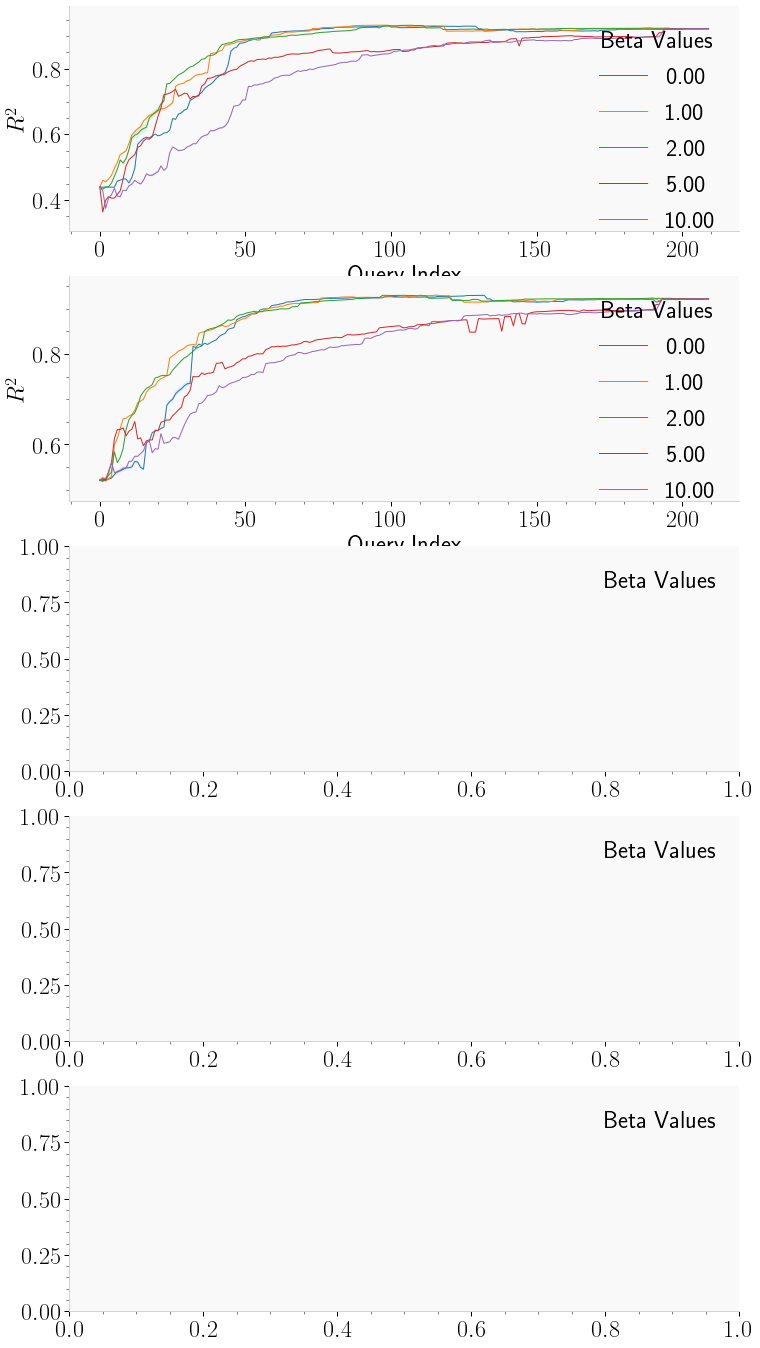

In [106]:
fig, axs = plt.subplots(5,1,figsize=(12,24))

for i,item in enumerate(folds.items()):
    rep, res = item

    ax = axs[i]
    
    for item in res.items():
        β, result = item
        idxs, scores = result
        scores = np.array(scores)
        ax.plot(scores.mean(axis=0), label=f"{β:.2f}", linewidth=1)#, alpha=(β+0.25)/(np.max(βs)+0.25))
        ax.fill_between(range(len(scores[0])), scores.mean(axis=0) - scores.var(axis=0), scores.mean(axis=0) + scores.var(axis=0), alpha=0.1)
        ax.set_ylabel("$R^2$", fontsize=24)
        ax.set_xlabel("Query Index", fontsize=24)
    
    ax.legend(frameon=False, fontsize=24, title="Beta Values", title_fontsize=24)
    
plt.show()

### Inner loop
The figures below were generated only using the inner loops. This is indicating that the size of the dataset is removing the benefits from information density as an approach. Testing with QM9 would help resolve this.

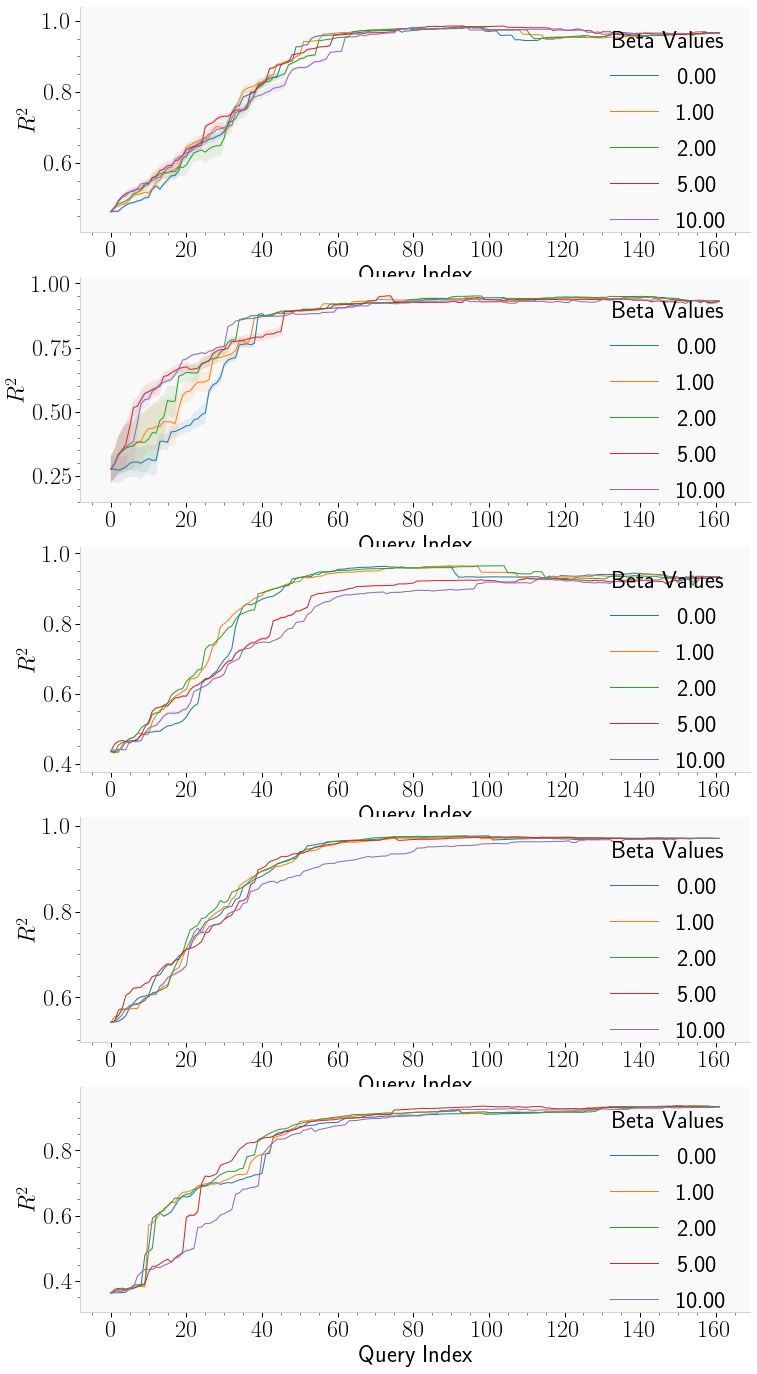

In [103]:
fig, axs = plt.subplots(5,1,figsize=(12,24))

for i,item in enumerate(folds.items()):
    rep, res = item

    ax = axs[i]
    
    for item in res.items():
        β, result = item
        idxs, scores = result
        scores = np.array(scores)
        ax.plot(scores.mean(axis=0), label=f"{β:.2f}", linewidth=1)#, alpha=(β+0.25)/(np.max(βs)+0.25))
        ax.fill_between(range(len(scores[0])), scores.mean(axis=0) - scores.var(axis=0), scores.mean(axis=0) + scores.var(axis=0), alpha=0.1)
        ax.set_ylabel("$R^2$", fontsize=24)
        ax.set_xlabel("Query Index", fontsize=24)
    
    ax.legend(frameon=False, fontsize=24, title="Beta Values", title_fontsize=24)
    
plt.show()

In [1147]:
#save_obj(β_rep_results, 'beta_results')
β_rep_results = utils.load_obj('beta_results')

File Loaded Successfully


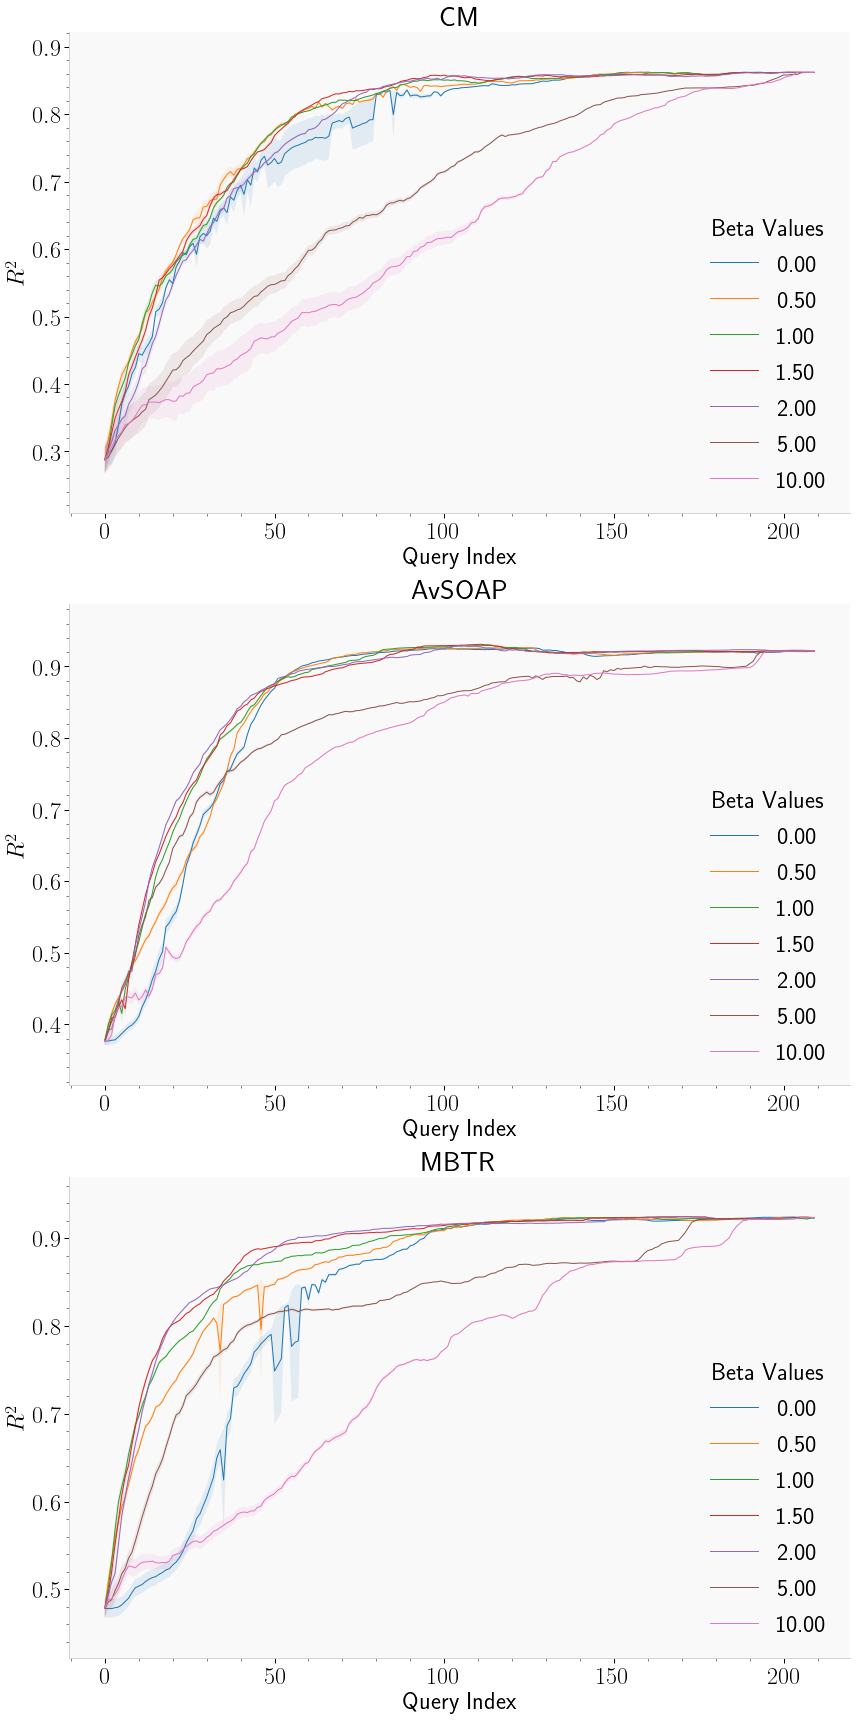

In [1151]:
fig, axs = plt.subplots(3,1,figsize=(12,24))

for i,item in enumerate(β_rep_results.items()):
    rep, res = item

    ax = axs[i]
    
    for item in res.items():
        β, result = item
        idxs, scores = result
        scores = np.array(scores)
        ax.plot(scores.mean(axis=0), label=f"{β:.2f}", linewidth=1)#, alpha=(β+0.25)/(np.max(βs)+0.25))
        ax.fill_between(range(len(scores[0])), scores.mean(axis=0) - scores.var(axis=0), scores.mean(axis=0) + scores.var(axis=0), alpha=0.1)
        ax.set_ylabel("$R^2$", fontsize=24)
        ax.set_xlabel("Query Index", fontsize=24)
    ax.set_title(rep, fontsize=28)
    
    ax.legend(frameon=False, fontsize=24, title="Beta Values", title_fontsize=24)

plt.tight_layout()
    
plt.savefig("Images/Beta_testing.pdf", bbox_inches="tight")
plt.savefig("Images/Beta_testing.svg", bbox_inches="tight")

plt.show()

## Examining Information Density Metrics

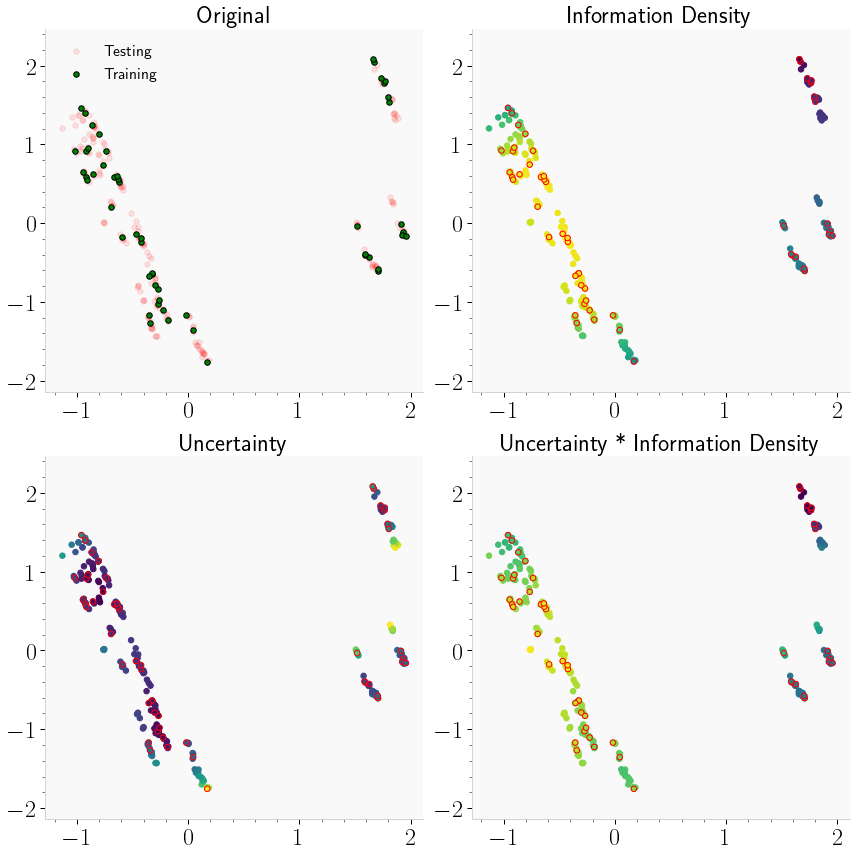

In [1325]:
fig, axs = plt.subplots(2,2,figsize=(12,12))

datascaler = StandardScaler().fit(small_cm[train_index])
predsscaler = StandardScaler().fit(Y[train_index].reshape(-1,1))
X̂_example = datascaler.transform(small_cm)
Ŷ_example = predsscaler.transform(Y.reshape(-1,1))

axs[0,0].scatter(X̂_example[train_index,0], X̂_example[train_index,1],s=30, c="red",alpha=0.1, label="Testing")
axs[0,0].scatter(X̂_example[test_index,0], X̂_example[test_index,1],s=30, edgecolor="k", c="green",label="Training")
axs[0,0].legend(frameon=False, fontsize=16)
axs[0,0].set_title("Original",fontsize=24)

kernel_ = RBF(1) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 100000.0))
example_gpr = GaussianProcessRegressor(kernel=kernel_)

example_gpr.fit(X̂_example[test_index], Ŷ_example[test_index])
_, std = example_gpr.predict(X̂_example, return_std=True)

axs[0,1].scatter(X̂_example[:,0], X̂_example[:,1],s=30,c=information_density(X̂_example,metric="euclidean"))
axs[0,1].scatter(X̂_example[test_index,0], X̂_example[test_index,1],s=30,c=information_density(X̂_example,metric="euclidean")[test_index],edgecolor="red")
axs[0,1].set_title("Information Density",fontsize=24)

axs[1,0].scatter(X̂_example[:,0], X̂_example[:,1],s=30,c=std)
axs[1,0].scatter(X̂_example[test_index,0], X̂_example[test_index,1],s=30,c=std[test_index],edgecolor="red")
axs[1,0].set_title("Uncertainty",fontsize=24)

axs[1,1].scatter(X̂_example[:,0], X̂_example[:,1],s=30,c=std*information_density(X̂_example, metric="euclidean"))
axs[1,1].scatter(X̂_example[test_index,0], X̂_example[test_index,1],s=30,c=(std*information_density(X̂_example, metric="euclidean"))[test_index],edgecolor="red")
axs[1,1].set_title("Uncertainty * Information Density",fontsize=24)

plt.tight_layout()
#plt.savefig("Images/Querying_Strategies_Compared.pdf",bbox_inches="tight")

## Metric Testing

In [22]:
def metric_fold_testing(X, Y, kf, metrics, n_splits=5, random_runs=2, seed_size=30, random_state_seed=10, debug=True, kernel=kernel):
    
    kf_results = {}
    
    with warnings.catch_warnings():
        # Remove the convergence and nearing bound warnings that fill up the output section
        warnings.simplefilter("ignore")

        for kf_idx,item in enumerate(kf.split(X)):

            print(f"Running fold {kf_idx+1}")
            train_index, test_index = item

            # Preprocess the data using dimensionality reduction on only the train components.
            X̂, Ŷ = preprocess(train_index, X, Y)

            test = (X̂[test_index], Ŷ[test_index])
            queries = len(train_index) - seed_size

            results = {}
            for metric in metrics:
                results[metric] = {key : arr for key,arr in zip(["idxs", "scores"],
                                                                  [np.zeros((random_runs,len(train_index)),dtype=np.int),np.zeros((random_runs,queries))])}

            results["Test indexes"] = test_index

            if debug:
                print(f"Training set size: {len(train_index)}")
                print(f"Testing set size: {len(test_index)}")
                print("Strategies:")
                for metric in metrics:
                    print(f"\t{metric}")
                print(f"Queries: {queries}")
            
            for idx in tqdm.tqdm(range(random_runs)):
                # Choose the random seed that will be shared by density, active, and random.
                seed = np.random.choice(train_index, size=(seed_size,), replace=False)
                # The use of unique is to stop duplicates being added to the seed values.
                kmean_seed_ = np.unique(kmean_seed(X̂, seed_size, random_state=idx, train_index=train_index))
                
                for metric in metrics:
                    metric_func = partial(GP_density_regression_std, metric=metric)

                    idxs, scores = active_test(seed, X̂, Ŷ, train_index, test, queries=queries, kernel=kernel, query=metric_func)
                           
                    # Sanity check tests
                    assert len(np.intersect1d(idxs, test_index)) == 0, f"Fold {kf_idx+1} - {metric} There is overlap between the training and testing indices."
                    assert len(idxs) == len(np.unique(idxs)), f"Fold {kf_idx+1} - {metric} There are duplicates in the training indices selected."
                    assert len(np.intersect1d(idxs[:seed_size], idxs[seed_size:])) == 0, f"Fold {kf_idx+1} - {metric} The model is re-selecting points in the seed dataset."

                    results[metric]["idxs"][idx,:] = np.array(idxs)
                    results[metric]["scores"][idx, :] = np.array(scores)

            kf_results[f"Fold {kf_idx + 1}"] = results
            
        return kf_results
    
metric_results = metric_fold_testing(cm_pca, Y, kf, metrics)

NameError: name 'kernel' is not defined

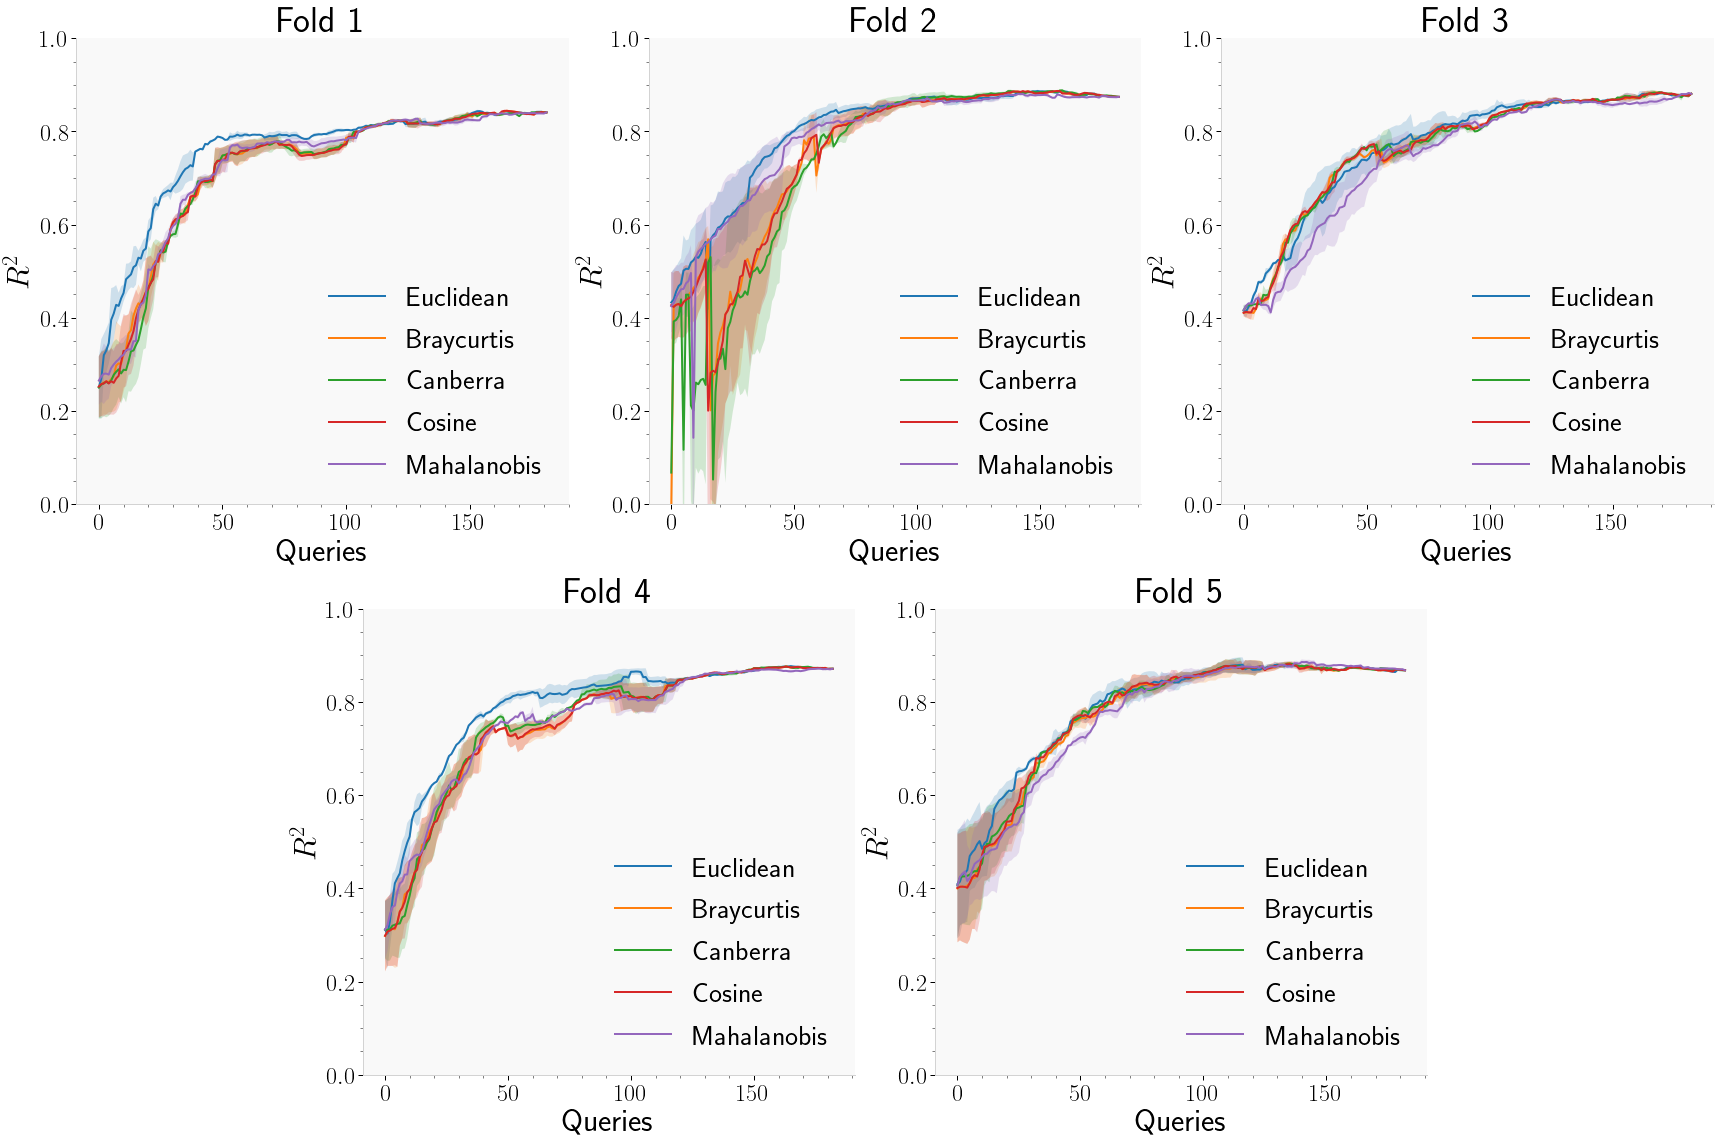

In [438]:
fg = visualise_kf(metric_results)
plt.savefig(f"Images/Different_Metrics.pdf",bbox_inches="tight")
plt.show()

In [405]:
old_metrics = ['euclidean', 'l2', 'l1', 'manhattan', 'cityblock', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine',  'hamming', 'mahalanobis', 'minkowski','seuclidean', 'sqeuclidean']
metrics = ['euclidean', 'braycurtis', 'canberra', 'cosine',  'mahalanobis']

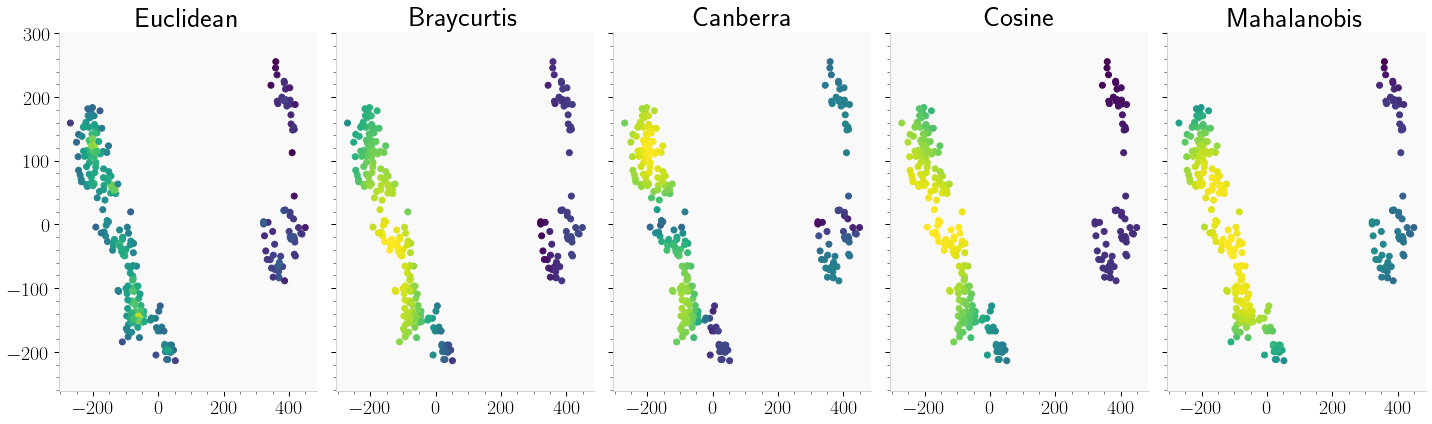

In [435]:
cols, rows = 5,1
cols_height = 6
rows_width = 4b

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height), sharey=True)
coords = np.arange(rows * cols).reshape(rows,cols)

for idx,metric in enumerate(metrics):
    x,y = np.where(coords == idx)
    ax = axs[y][0]

    ax.set_title(metric.capitalize(),fontsize=28)
    ax.scatter(small_cm[:,0], small_cm[:,1], c=information_density(small_cm,metric=metric))
    ax.tick_params(axis='both', which='major', labelsize=20)
    
plt.tight_layout()
#plt.savefig("Images/Different_Information_Density_Metrics.pdf",bbox_inches="tight")
plt.show()

## ESOL Active Learning

In [616]:
active_learning_runs_esol = 10

n_splits = 5
kf_esol = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=state) # Using this split so that the dataset classes are balanced.
kf_results_esol = {}

for name, (X, Y) in extra_data.items():
    kf_results_esol[name] = test_funcs.fold_testing(X[extra_inners["ESOL"]], 
                                                    Y[extra_inners["ESOL"]], 
                                                    strategies=strategies, 
                                                    categorical=np.ones((len(extra_inners["ESOL"]),)), 
                                                    kf=kf_esol, 
                                                    random_runs=active_learning_runs_esol, 
                                                    kernel=kernel, 
                                                    seed_size="variable", 
                                                    n_components=big_rep,
                                                    preprocessing=False,
                                                    debug=True)
    
    utils.save_obj(kf_results, f'kf_results_final_esol')

Running fold 1
False (902, 25)
Training set size: 721
Testing set size: 181
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 696


100%|██████████████████████████████████████████| 10/10 [51:29<00:00, 308.98s/it]


Running fold 2
False (902, 25)
Training set size: 721
Testing set size: 181
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 696


100%|██████████████████████████████████████████| 10/10 [53:30<00:00, 321.08s/it]


Running fold 3
False (902, 25)
Training set size: 721
Testing set size: 181
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 696


100%|██████████████████████████████████████████| 10/10 [52:10<00:00, 313.05s/it]


Running fold 4
False (902, 25)
Training set size: 721
Testing set size: 181
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 696


100%|██████████████████████████████████████████| 10/10 [51:57<00:00, 311.75s/it]


Running fold 5
False (902, 25)
Training set size: 721
Testing set size: 181
Strategies:
	Uncertainty
	Information Density
	Random
Queries: 696


100%|██████████████████████████████████████████| 10/10 [52:21<00:00, 314.12s/it]

File Saved Successfully


IndexError: index 854 is out of bounds for axis 0 with size 642

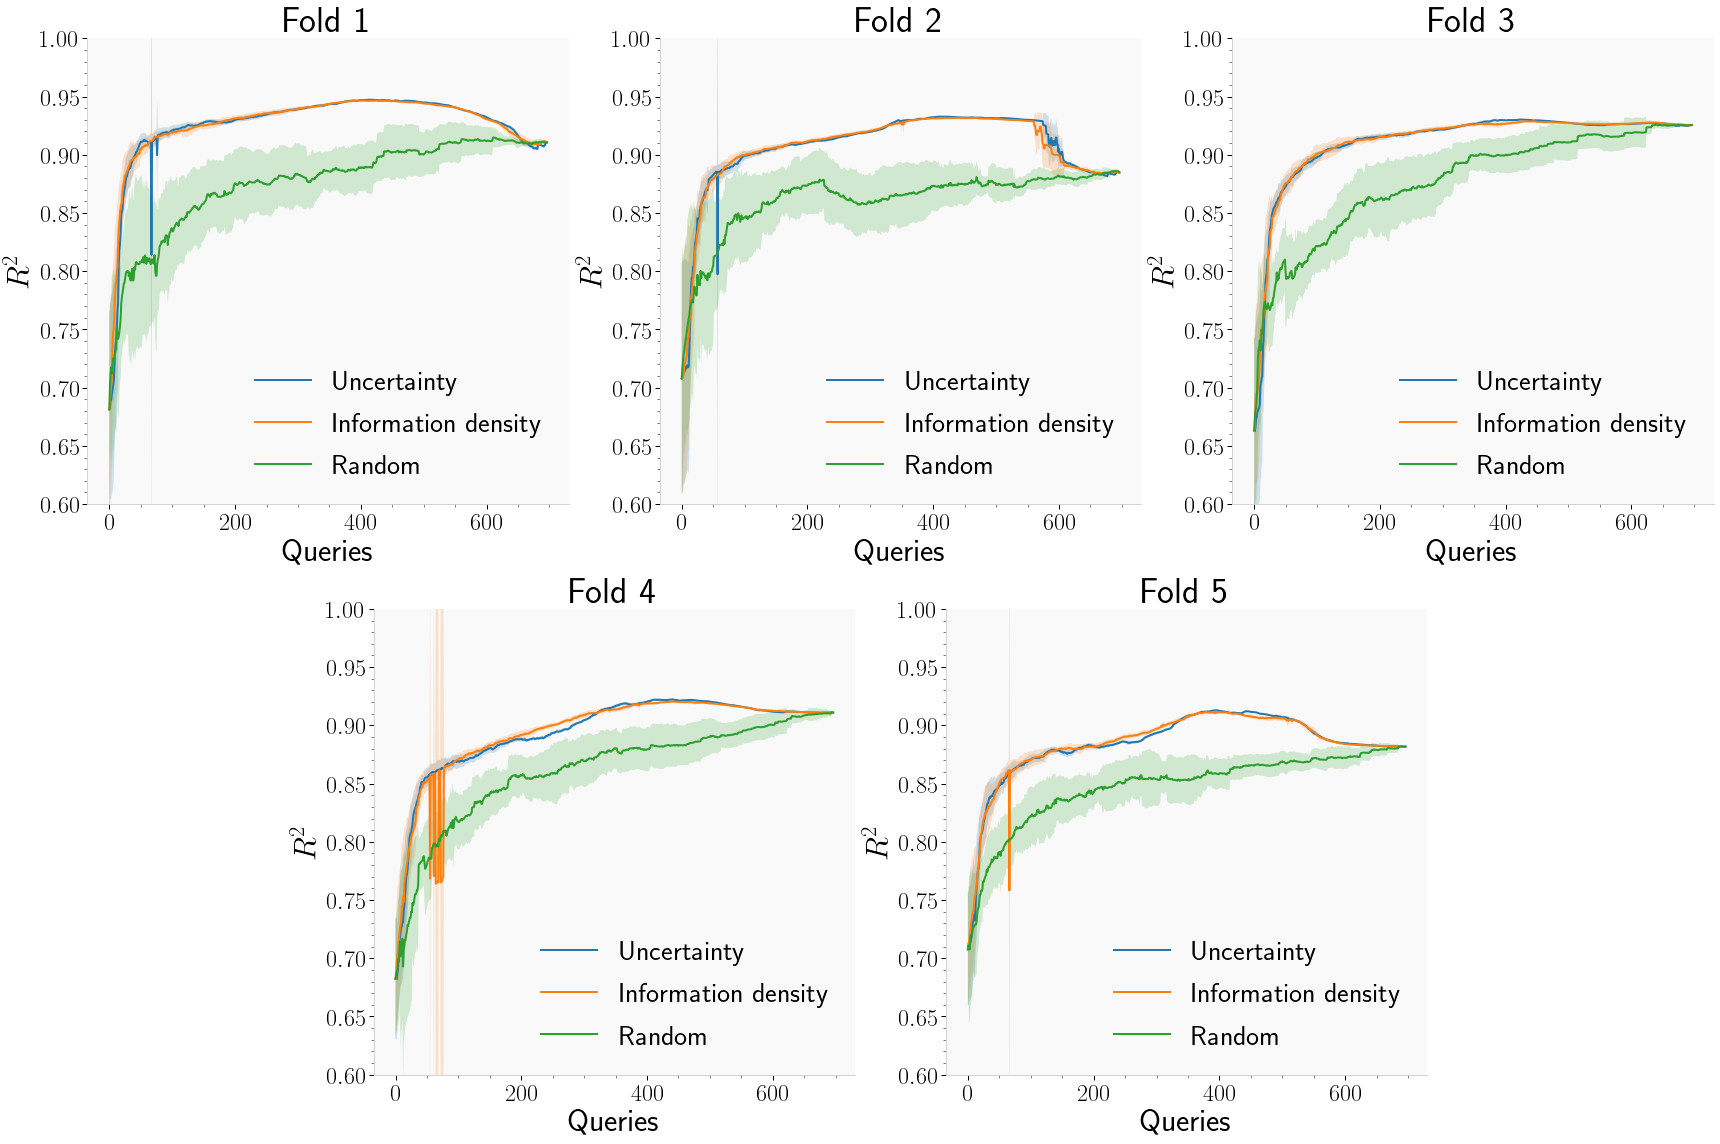

In [621]:
#ylims = [(0,1.), (0.2,1.0), (0.4,1)]
for i, (name, results) in enumerate(kf_results_esol.items()):
    fg = vis.visualise_kf(results, ylim=(0.6,1))
    plt.savefig(f"Images/ESOL_Different_active_learning_methods.svg",bbox_inches="tight")
    plt.savefig(f"Images/ESOL_Different_active_learning_methods.pdf",bbox_inches="tight")
    plt.show()

In [618]:
utils.save_obj(kf_results_esol, f'kf_results_final_esol')

File Saved Successfully


In [ ]:
    utils.save_obj(kf_results_esol, f'kf_results_final_esol')

In [600]:
extra_dsets = {"ESOL" : esol,
               "FreeSolv" : free}

extra_inners = {}
extra_outers = {}
extra_reps = {}
extra_props = {}

for dset in extra_dsets:
    extra_inners[dset] = np.random.choice(np.arange(len(extra_dsets[dset])), replace=False, size=int(0.8*len(extra_dsets[dset])))
    extra_outers[dset] = np.setdiff1d(np.arange(len(extra_dsets[dset])), extra_inners[dset])
    
    X, Y = pre.standardise(np.array(list(map(calc_vector, extra_dsets[dset]["SMILES"]))), 
                           extra_dsets["ESOL"]["ESOL predicted log solubility in mols per litre"].to_numpy(),
                           extra_inners[dset])
    
    extra_reps[dset] = X
    extra_props[dset] = Y

In [607]:
extra_data = {dset : [extra_reps[dset], extra_props[dset]] for dset in extra_dsets}

In [610]:
extra_inners["ESOL"].shape

(902,)

# GPR Performance Data Valuation

## Setup

In [564]:
import chemdataval.chemdataval.informativeness as inform_funcs
importlib.reload(sys.modules['chemdataval.chemdataval.informativeness'])
import chemdataval.chemdataval.informativeness as inform_funcs

validation_controls = {}
validation_informative = {}
sizes = [x for x in range(10,240,5)]
repeats = 5


with warnings.catch_warnings():
    # Remove the convergence and nearing bound warnings that fill up the output section
    warnings.simplefilter("ignore")
    for rep,color in rep_colors.items():
        print(f"Computing control for {rep}")  
        randoms = []
        #X̂, Ŷ = pre.preprocess(representations[rep], Y, inner_mols, n_components=0.99)
        X̂, Ŷ = processed_representations[rep]

        for size in tqdm.tqdm(sizes):
            random_repeats = []
            for _ in range(repeats):
                random_repeats.append(mc.test_model(X̂, Ŷ, np.random.choice(inner_mols, size=size, replace=False), outer_mols, GaussianProcessRegressor, kernel=kernel, preprocessing=False))
            randoms.append(random_repeats)

        validation_controls[rep] = randoms


with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Outer loop iterates over the representations 
    for core_rep, _ in rep_colors.items():

        rep_results = {}
        print(f"Using {core_rep} for informativeness")
        
        # Compute the informativeness using the given representation
        inform = inform_funcs.fold_informativeness(restructured_kf[core_rep], strategy="Random", scaler=None, seed_size=seed_sizes[core_rep], dset_size=266, subset_idxs=inner_mols).mean(axis=0)
        inform = inform * 10000
        inform = inform.filled(0)
        # Loop over the representations again and use the same informativeness values to select the points in the dataset.
        
        for rep,color in rep_colors.items():

            true = []
            #X̂, Ŷ = pre.preprocess(representations[rep], Y, inner_mols, n_components=0.99)
            X̂, Ŷ = processed_representations[rep]
            for size in tqdm.tqdm(sizes):
                true_repeats = []
                for _ in range(repeats):
                    train_idxs = np.random.choice(inner_mols, size=size, replace=False, p=utils.softmax(inform[inner_mols]))
                    utils.check_invalid_selection(train_idxs, outer_mols)
                    true_repeats.append(mc.test_model(X̂, Ŷ, train_idxs, outer_mols, GaussianProcessRegressor,kernel=kernel, preprocessing=False))
                true.append(true_repeats)

            rep_results[rep] = true

        validation_informative[core_rep] = rep_results

Computing control for CM


100%|███████████████████████████████████████████| 46/46 [00:06<00:00,  6.84it/s]


Computing control for AvSOAP


100%|███████████████████████████████████████████| 46/46 [00:03<00:00, 13.81it/s]


Computing control for MBTR


100%|███████████████████████████████████████████| 46/46 [00:05<00:00,  8.13it/s]


Using CM for informativeness


100%|███████████████████████████████████████████| 46/46 [00:05<00:00,  8.09it/s]


Using AvSOAP for informativeness


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.53it/s]


Using MBTR for informativeness


100%|███████████████████████████████████████████| 46/46 [00:06<00:00,  7.22it/s]


In [2392]:
# GPR Validation Files

val_fname = "GPR_Validation_proper"
con_fname = "GPR_Control_proper"

if os.path.exists(val_fname):
    informative = load_obj(val_fname)
else:
    save_obj(informative, val_fname)
    
if os.path.exists(con_fname):
    controls = load_obj(con_fname)
else:
    save_obj(controls, con_fname)

File Saved Successfully
File Saved Successfully


## Custom Plotting Legend

For whatever reason, the variable sizing used in the scatterplots below completely breaks the legend. The code below is to overcome that and manually create the legend

In [79]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerPatch

class HandlerCircle(HandlerPatch):

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):

        r = 5
        x = r + width//2
        y = height//2

        # create 
        p = patches.Circle(xy=(x, y), radius=r)

        # update with data from oryginal object
        self.update_prop(p, orig_handle, legend)

        # move xy to legend
        p.set_transform(trans)

        return [p]


In [355]:
rep = "MBTR"
results_ = []
randoms_ = []
fold = 4
for size in sizes:
    temp_train = np.setdiff1d(inner_mols,inner_mols[restructured_kf[rep]['Test indexes'][fold]])
    
    inform = inform_funcs.fold_informativeness(restructured_kf[rep], strategy="Random", scaler=None, seed_size=seed_sizes[rep], dset_size=266, subset_idxs=inner_mols).mean(axis=0)
    inform = inform * 5000
    train_idxs_ = np.random.choice(temp_train, replace=False, size=size, p=utils.softmax(inform[temp_train]))
    test_idxs_ = inner_mols[restructured_kf[rep]['Test indexes'][fold]]
    
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(processed_representations[rep][0][train_idxs_],processed_representations[rep][1][train_idxs_])
    results_.append(gpr.score(processed_representations[rep][0][test_idxs_],processed_representations[rep][1][test_idxs_]))
    
    random_idxs_ = np.random.choice(temp_train, replace=False, size=size)
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(processed_representations[rep][0][random_idxs_],processed_representations[rep][1][random_idxs_])
    randoms_.append(gpr.score(processed_representations[rep][0][test_idxs_],processed_representations[rep][1][test_idxs_]))
    

/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


(0.0, 1.0)

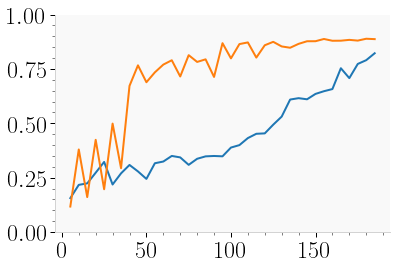

In [356]:
plt.plot(sizes,results_)
plt.plot(sizes, randoms_)
plt.ylim(0,1)

/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


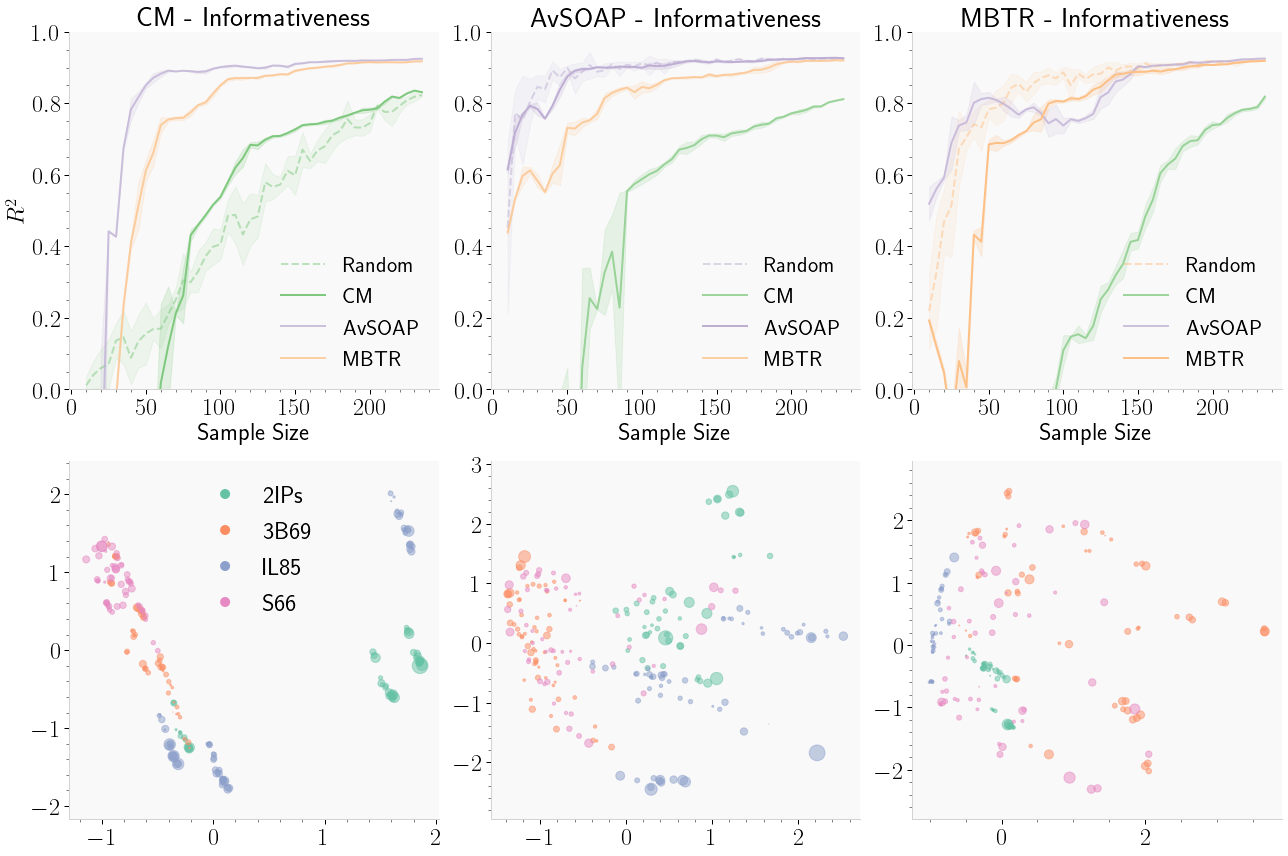

In [565]:
from matplotlib.legend import _get_legend_handles_labels
folds = 5

fig, axes = plt.subplots(2,3,figsize=(18,12))

axs = axes[0]

# Change color of random to representation that was used for it, and then change the line type.

axs[0].set_ylabel("$R^2$", fontsize=24)

for ax, item in zip(axs, rep_colors.items()):
    rep, base_color = item
    
    vis.plot_multiple_runs(sizes, validation_controls[rep], ax=ax, label="Random", color=base_color, linestyle="--", alpha=0.5)
    
    for rep2, color in rep_colors.items():
        if rep != rep2:
            alpha=0.75
        else:
            alpha=1.0
        vis.plot_multiple_runs(sizes, validation_informative[rep][rep2], ax=ax, label=rep2, color=color, alpha=alpha)
    ax.set_ylim(0,1)
    ax.set_title(f"{rep} - Informativeness", fontsize=28)
    ax.set_xlabel("Sample Size",fontsize=24)

    ax.legend(frameon=False, fontsize=22)

axs2 = axes[1]

for ax, rep in zip(axs2, small_representations.keys()):
    for dset in datasets["blyp"].keys():
        idxs = df["Dataset"] == dset
        inform = inform_funcs.strategy_informativeness(restructured_kf, strategies, rep=rep, runs=active_learning_runs, folds=folds, scaler=None, seed_size=seed_sizes[rep], dset_size=266, subset_idxs=inner_mols)
        ax.scatter(*small_representations[rep][idxs].T, s=inform.mean(axis=0)[idxs]*10000, marker="o", color=str(dataset_colours[dset]), label=dset, alpha=0.5)

    if rep == "CM":
        legenditems = [(patches.Circle((0,0), 5, facecolor=c), key) for key,c in dataset_colours.items()]
        ax.legend(*zip(*legenditems), frameon=False, fontsize=24, handler_map={patches.Circle: HandlerCircle(),})

plt.tight_layout()
plt.savefig("Images/Data Valuation Validation New.pdf", bbox_inches="tight")
plt.show()


/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


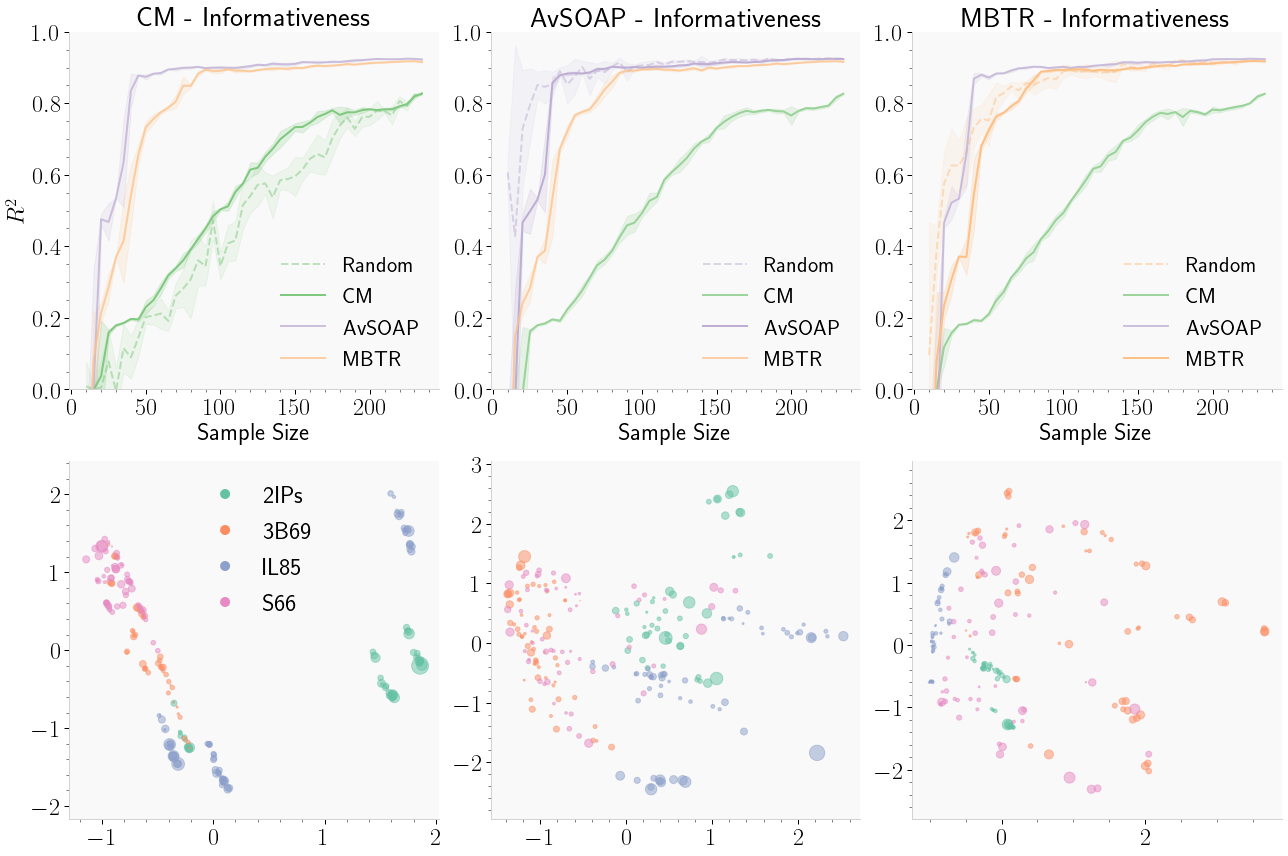

In [98]:
from matplotlib.legend import _get_legend_handles_labels
folds = 5

fig, axes = plt.subplots(2,3,figsize=(18,12))

axs = axes[0]

# Change color of random to representation that was used for it, and then change the line type.

axs[0].set_ylabel("$R^2$", fontsize=24)

for ax, item in zip(axs, rep_colors.items()):
    rep, base_color = item
    
    vis.plot_multiple_runs(sizes, validation_controls[rep], ax=ax, label="Random", color=base_color, linestyle="--", alpha=0.5)
    
    for rep2, color in rep_colors.items():
        if rep != rep2:
            alpha=0.75
        else:
            alpha=1.0
        vis.plot_multiple_runs(sizes, validation_informative[rep][rep2], ax=ax, label=rep2, color=color, alpha=alpha)
    ax.set_ylim(0,1)
    ax.set_title(f"{rep} - Informativeness", fontsize=28)
    ax.set_xlabel("Sample Size",fontsize=24)

    ax.legend(frameon=False, fontsize=22)

axs2 = axes[1]

for ax, rep in zip(axs2, small_representations.keys()):
    for dset in datasets["blyp"].keys():
        idxs = df["Dataset"] == dset
        inform = inform_funcs.strategy_informativeness(restructured_kf, strategies, rep=rep, runs=active_learning_runs, folds=folds, scaler=None, seed_size=seed_sizes[rep], dset_size=266, subset_idxs=inner_mols)
        ax.scatter(*small_representations[rep][idxs].T, s=inform.mean(axis=0)[idxs]*10000, marker="o", color=str(dataset_colours[dset]), label=dset, alpha=0.5)

    if rep == "CM":
        legenditems = [(patches.Circle((0,0), 5, facecolor=c), key) for key,c in dataset_colours.items()]
        ax.legend(*zip(*legenditems), frameon=False, fontsize=24, handler_map={patches.Circle: HandlerCircle(),})

plt.tight_layout()
#plt.savefig("Images/Data Valuation Validation.pdf", bbox_inches="tight")
plt.show()


# Data Valuation for Different Learning Algorithms

## Different Algorithms

In [2372]:
restructured_kf = utils.transform_fold_dict(kf_results)

In [1037]:
processed_X = {rep : processed_representations[rep][0] for rep in restructured_kf}

In [1042]:
Y = processed_representations["CM"][1]

In [1052]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor,  AdaBoostRegressor
from sklearn.neural_network import MLPRegressor 
from sklearn.neighbors import KNeighborsRegressor

models = [RandomForestRegressor, AdaBoostRegressor, MLPRegressor, KNeighborsRegressor, KernelRidge]

sizes = range(10,240,5)
T = 10000
repeats = 25

model_results = {}

informativeness_dict = {rep : inform_funcs.strategy_informativeness(restructured_kf, strategies, rep, runs=active_learning_runs, dset_size=266, seed_size=seed_sizes[rep], subset_idxs=inner_mols).mean(axis=0) for rep in representations.keys()}

for model in models:
    name = model.__name__
    print(f"Running model {name}")
    
    test = intelli.intelligent_sampling_over_representations(mc.test_model, informativeness_dict, processed_X, Y, inner_mols, outer_mols, sizes, repeats=repeats, skip_reps=[], T=T, control=False, model=model)
    control = intelli.intelligent_sampling_over_representations(mc.test_model, informativeness_dict,  processed_X, Y, inner_mols, outer_mols, sizes, repeats=repeats, skip_reps=[], T=T, control=True, model=model)
    
    
    
    model_results[name] = [test, control]

Running model RandomForestRegressor
Running CM


100%|███████████████████████████████████████████| 46/46 [06:37<00:00,  8.64s/it]


Running AvSOAP


100%|███████████████████████████████████████████| 46/46 [01:44<00:00,  2.28s/it]


Running MBTR


100%|███████████████████████████████████████████| 46/46 [02:38<00:00,  3.44s/it]


Running CM


100%|███████████████████████████████████████████| 46/46 [06:36<00:00,  8.63s/it]


Running AvSOAP


100%|███████████████████████████████████████████| 46/46 [01:43<00:00,  2.24s/it]


Running MBTR


100%|███████████████████████████████████████████| 46/46 [02:37<00:00,  3.42s/it]


Running model AdaBoostRegressor
Running CM


100%|███████████████████████████████████████████| 46/46 [02:17<00:00,  2.99s/it]


Running AvSOAP


100%|███████████████████████████████████████████| 46/46 [00:43<00:00,  1.06it/s]


Running MBTR


100%|███████████████████████████████████████████| 46/46 [00:59<00:00,  1.30s/it]


Running CM


100%|███████████████████████████████████████████| 46/46 [02:18<00:00,  3.00s/it]


Running AvSOAP


100%|███████████████████████████████████████████| 46/46 [00:42<00:00,  1.07it/s]


Running MBTR


100%|███████████████████████████████████████████| 46/46 [01:00<00:00,  1.32s/it]


Running model MLPRegressor
Running CM


100%|███████████████████████████████████████████| 46/46 [01:41<00:00,  2.20s/it]


Running AvSOAP


100%|███████████████████████████████████████████| 46/46 [01:29<00:00,  1.94s/it]


Running MBTR


100%|███████████████████████████████████████████| 46/46 [01:45<00:00,  2.29s/it]


Running CM


100%|███████████████████████████████████████████| 46/46 [01:40<00:00,  2.20s/it]


Running AvSOAP


100%|███████████████████████████████████████████| 46/46 [01:44<00:00,  2.26s/it]


Running MBTR


100%|███████████████████████████████████████████| 46/46 [02:00<00:00,  2.61s/it]


Running model KNeighborsRegressor
Running CM


100%|███████████████████████████████████████████| 46/46 [00:02<00:00, 22.00it/s]


Running AvSOAP


100%|███████████████████████████████████████████| 46/46 [00:01<00:00, 32.66it/s]


Running MBTR


100%|███████████████████████████████████████████| 46/46 [00:01<00:00, 39.09it/s]


Running CM


100%|███████████████████████████████████████████| 46/46 [00:01<00:00, 32.87it/s]


Running AvSOAP


100%|███████████████████████████████████████████| 46/46 [00:00<00:00, 48.85it/s]


Running MBTR


100%|███████████████████████████████████████████| 46/46 [00:00<00:00, 55.36it/s]


Running model KernelRidge
Running CM


100%|███████████████████████████████████████████| 46/46 [00:02<00:00, 17.10it/s]


Running AvSOAP


100%|███████████████████████████████████████████| 46/46 [00:01<00:00, 23.69it/s]


Running MBTR


100%|███████████████████████████████████████████| 46/46 [00:01<00:00, 23.61it/s]


Running CM


100%|███████████████████████████████████████████| 46/46 [00:01<00:00, 28.24it/s]


Running AvSOAP


100%|███████████████████████████████████████████| 46/46 [00:01<00:00, 34.81it/s]


Running MBTR


100%|███████████████████████████████████████████| 46/46 [00:01<00:00, 31.10it/s]


In [1071]:
len(model_results["RandomForestRegressor"][0]["AvSOAP"][2])

25

In [1053]:
utils.save_obj(model_results, "model_transfer_results_final")

File Saved Successfully


In [696]:
#model_results = utils.load_obj("model_transfer_results_final")

File Loaded Successfully


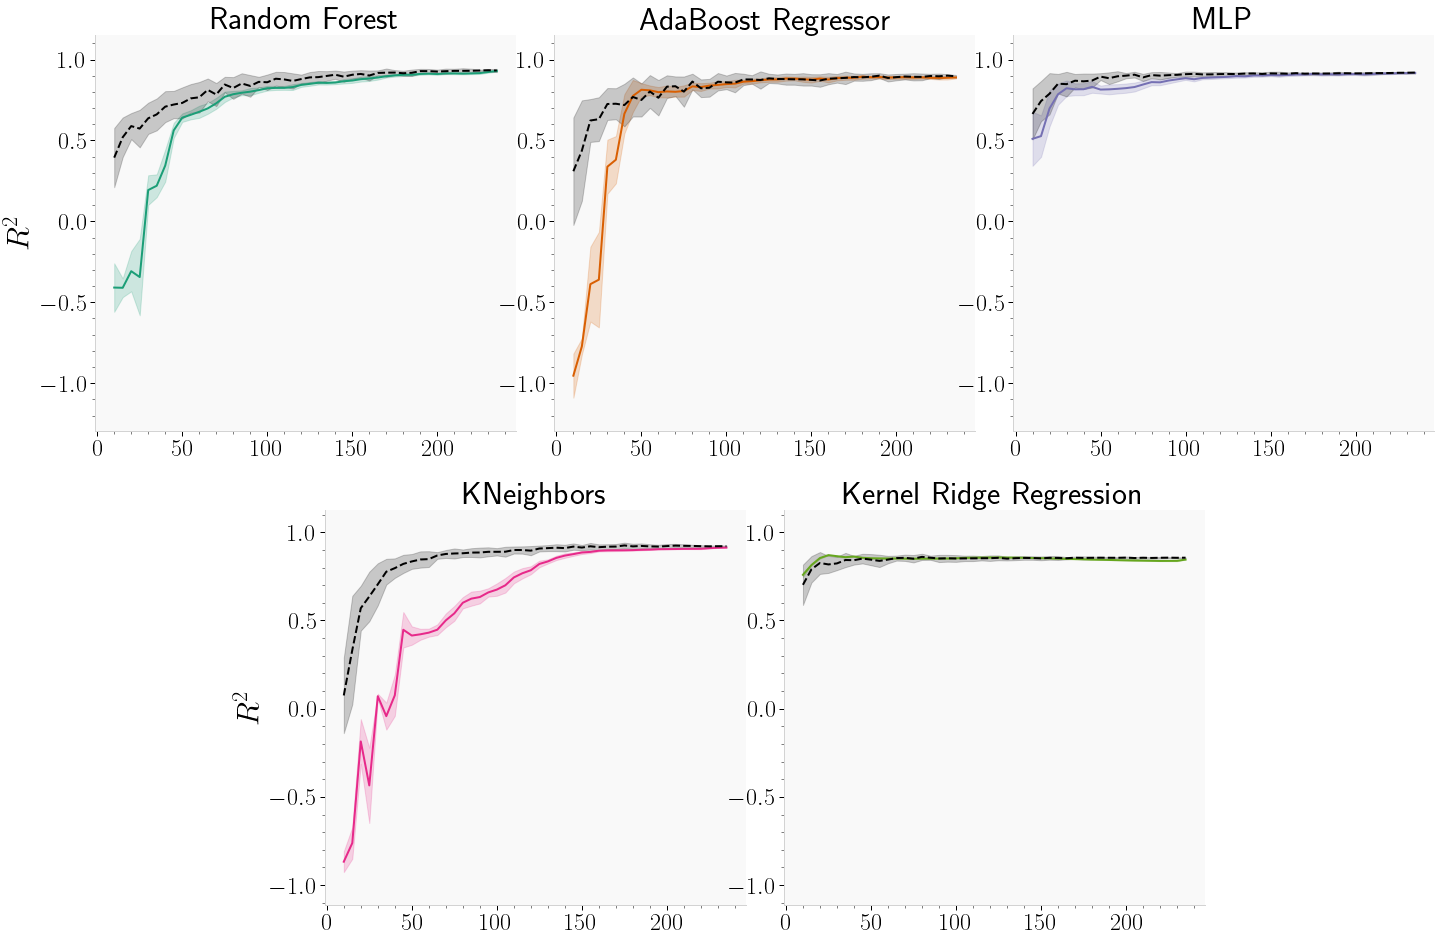

In [1088]:
fig, axs = vis.fivefigs(shareaxes=True,yaxis_label=f"$R^2$")

model_names = {x : y for x, y in zip(model_results.keys(), ["Random Forest", "AdaBoost Regressor", "MLP", "KNeighbors", "Kernel Ridge Regression"])}
cols = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']

sizes = range(10,240,5)

rep = "AvSOAP"

for i, (ax, model) in enumerate(zip(axs, model_results.keys())):
    vis.plot_multiple_runs(sizes, model_results[model][0][rep], ax=ax, label=f"{model_names[model]} - Informative", color=cols[i])
    vis.plot_multiple_runs(sizes, model_results[model][1][rep], ax=ax, label=f"{model_names[model]} - Random", color="black", linestyle="--")
    ax.set_title(model_names[model], fontsize=32)
    #if i in [0,3]:
    #    ax.set_ylim(0.5,1)

plt.savefig(f"Images/Data_Valuation_Models_{rep}.pdf", bbox_inches="tight")
plt.savefig(f"Images/Data_Valuation_Models_{rep}.svg", bbox_inches="tight")

plt.show()

## Monte Carlo Data Shapley Values

In [1100]:
model_correlation_results = {}

categorical = df["Categorical"].to_numpy()

def sanitise(scores):
    """
    Turns negative elements into zero values.
    """
    scores = utils.ensure_array(scores)
    scores[np.where(scores < 0)] = 0
    return scores

with warnings.catch_warnings():
    # Remove the convergence and nearing bound warnings that fill up the output section
    warnings.simplefilter("ignore")

    for model in models:
        print(f"Working on {model.__name__}")
        X = processed_representations["CM"][0]

        idxs, scores = mc.test_inner_folds(
            mc.test_model,
            kf=kf,
            X=X,
            Y=Y,
            seed_size="variable",
            inner_idxs=inner_mols,
            outer_idxs=outer_mols,
            groups=categorical,
            queries=60,
            random_runs=100,
            model=model
            )
        
        scores = sanitise(scores)
        
        model_correlation_results[model.__name__] = [idxs, scores]
        
        utils.save_obj(model_correlation_results, "MC_DSValues_Model")

Working on RandomForestRegressor
Running fold 1


100%|█████████████████████████████████████████| 100/100 [39:54<00:00, 23.94s/it]


Running fold 2


100%|█████████████████████████████████████████| 100/100 [36:16<00:00, 21.76s/it]


Running fold 3


100%|█████████████████████████████████████████| 100/100 [31:31<00:00, 18.91s/it]


Running fold 4


100%|█████████████████████████████████████████| 100/100 [29:53<00:00, 17.93s/it]


Running fold 5


100%|█████████████████████████████████████████| 100/100 [26:30<00:00, 15.91s/it]


File Saved Successfully
Working on AdaBoostRegressor
Running fold 1


100%|█████████████████████████████████████████| 100/100 [12:55<00:00,  7.75s/it]


Running fold 2


100%|█████████████████████████████████████████| 100/100 [11:29<00:00,  6.90s/it]


Running fold 3


100%|█████████████████████████████████████████| 100/100 [10:36<00:00,  6.37s/it]


Running fold 4


100%|█████████████████████████████████████████| 100/100 [10:09<00:00,  6.09s/it]


Running fold 5


100%|█████████████████████████████████████████| 100/100 [09:35<00:00,  5.76s/it]


File Saved Successfully
Working on MLPRegressor
Running fold 1


100%|█████████████████████████████████████████| 100/100 [07:32<00:00,  4.52s/it]


Running fold 2


100%|█████████████████████████████████████████| 100/100 [07:53<00:00,  4.73s/it]


Running fold 3


100%|█████████████████████████████████████████| 100/100 [09:39<00:00,  5.79s/it]


Running fold 4


100%|█████████████████████████████████████████| 100/100 [10:29<00:00,  6.30s/it]


Running fold 5


100%|█████████████████████████████████████████| 100/100 [11:42<00:00,  7.02s/it]


File Saved Successfully
Working on KNeighborsRegressor
Running fold 1


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.75it/s]


Running fold 2


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.90it/s]


Running fold 3


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.90it/s]


Running fold 4


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.56it/s]


Running fold 5


100%|█████████████████████████████████████████| 100/100 [00:07<00:00, 13.94it/s]


File Saved Successfully
Working on KernelRidge
Running fold 1


100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.45it/s]


Running fold 2


100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.39it/s]


Running fold 3


100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.27it/s]


Running fold 4


100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.91it/s]


Running fold 5


100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  7.77it/s]

File Saved Successfully


In [1138]:
inform_funcs.informativeness_scoring(np.array(model_correlation_results["RandomForestRegressor"][0]), np.array(model_correlation_results["RandomForestRegressor"][1]), dset_size=266, seed_size=117, subset_idxs=None)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0)

In [1139]:
model_scores = [inform_funcs.informativeness_scoring(*model_correlation_results[model.__name__], dset_size=266, subset_idxs=None, seed_size=117).mean(axis=0) for model in models]


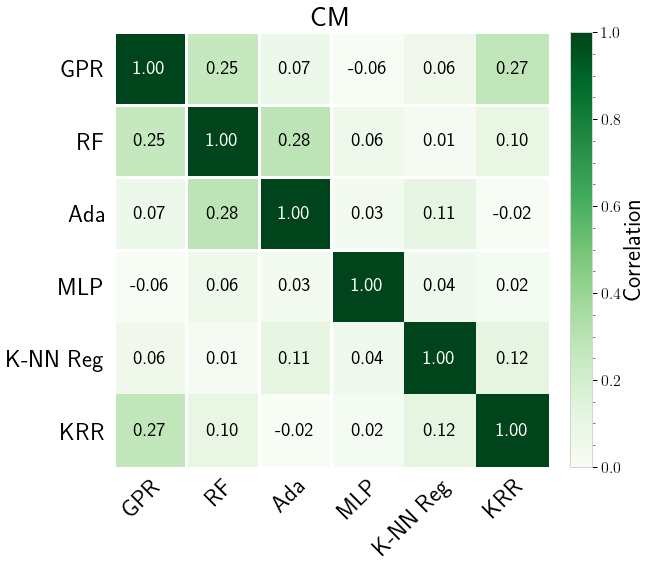

In [1142]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

model_scores = [inform_funcs.strategy_informativeness(restructured_kf, strategies, rep="CM", dset_size=266, runs=100, seed_size=seed_sizes["CM"], subset_idxs=inner_mols).mean(axis=0)]
model_scores = model_scores + [inform_funcs.informativeness_scoring(*model_correlation_results[model.__name__], dset_size=266, subset_idxs=None, seed_size=117).mean(axis=0) for model in models]

model_names = ["GPR", "RF", "Ada", "MLP", "K-NN Reg", "KRR"]

corrs = np.corrcoef(model_scores)
im = ax.imshow(corrs, cmap="Greens", vmin=0,vmax=1)
ax.set_xticks(np.arange(len(model_names)))
ax.set_xticklabels(labels=list(model_names), rotation=45, ha="right",rotation_mode="anchor", fontsize=24)
ax.set_yticks(np.arange(len(model_names)))
ax.set_yticklabels(labels=list(model_names), fontsize=24)
ax.set_title("CM", fontsize=28)
ax.set_xticks(np.arange(len(representations)+1)-.5, minor=True)
ax.set_yticks(np.arange(len(representations)+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
[ax.spines[key].set_visible(False) for key in ax.spines.keys()]
ax.tick_params(which="both", left=False, bottom=False)

text = vis.annotate_heatmap(im, data=corrs, fontsize=20)

    
axins = inset_axes(ax, width = "5%", height = "100%", loc = 'lower left',
                   bbox_to_anchor = (1.05, 0., 1, 1), bbox_transform = ax.transAxes,
                   borderpad = 0)

cbar = fig.colorbar(im, cax = axins, label="Correlation")
cbar.ax.set_ylabel("Correlation", rotation=90, va="bottom", fontsize=24, labelpad=25)
cbar.ax.tick_params(labelsize=16) 

plt.savefig("Model Correlation New.svg", bbox_inches="tight")
plt.savefig("Model Correlation New.pdf", bbox_inches="tight")

# DFT Parameterisation

This section uses Anh's code with the indices determined by the active learning procedure to study the RMSD error of the DFT parameterisation using the indices provided by the active learning.

## DFT Parameterisation Functions

In [622]:
b3lyp_df = pd.read_csv("data_for_b3lyp_param.csv")
b3lyp_df.rename(columns = {"structure" : "Complex"}, inplace=True)
b3lyp_df.set_index("Complex", inplace=True)
combined = df.join(b3lyp_df, on="Complex")

In [623]:
#coef_dct = {"aDX": df["HF-X"] - df["S-X"], "aX": df["B88-X"], "aC": df["LYP-C"],"aX0": df["HF-X"], "aX1": df["S-X"]}.keys()
coefs = dft_params.bootstrap(b3lyp_df, R=100,model="noB88X")
dft_params.test_coef(b3lyp_df,coefs)
#coefs

{'Mean': 0.685,
 'MAD': 0.963,
 'MAE': 2.817,
 'RMSD': 7.91,
 'SD': 7.88,
 'MIN': 0.009,
 'MAX': 33.86,
 'LOW': -33.86,
 'UP': 21.29}

In [625]:
metric = "RMSD"
bootstrap_off = True
model = "noB88X"
rep = "AvSOAP" 

parameterisation_results = []

for fold in kf_results[rep].items():

    name, data = fold
    fold_results = []
    test_data = kf_results[rep][name]["Test indexes"]

    #for run in range(runs):
    #    run_results = []
    for strategy in data.keys():
        strat_arr = []
        if strategy == "Test indexes":
            continue
        for run in tqdm.tqdm(range(active_learning_runs)):

            train_data = kf_results[rep][name][strategy]["idxs"][run]
            strat_arr.append(dft_params.test_parameterisation(train_data, test_data, combined, metric=metric, queries=len(train_data) - seed_sizes[rep], seed_size=seed_sizes[rep],R=1, model=model, bootstrap_off=bootstrap_off))
        fold_results.append(strat_arr)
    parameterisation_results.append(fold_results)


100%|█████████████████████████████████████████| 250/250 [01:25<00:00,  2.93it/s]


In [633]:
utils.save_obj(parameterisation_results,"DFT_parameterisation_results")

File Saved Successfully


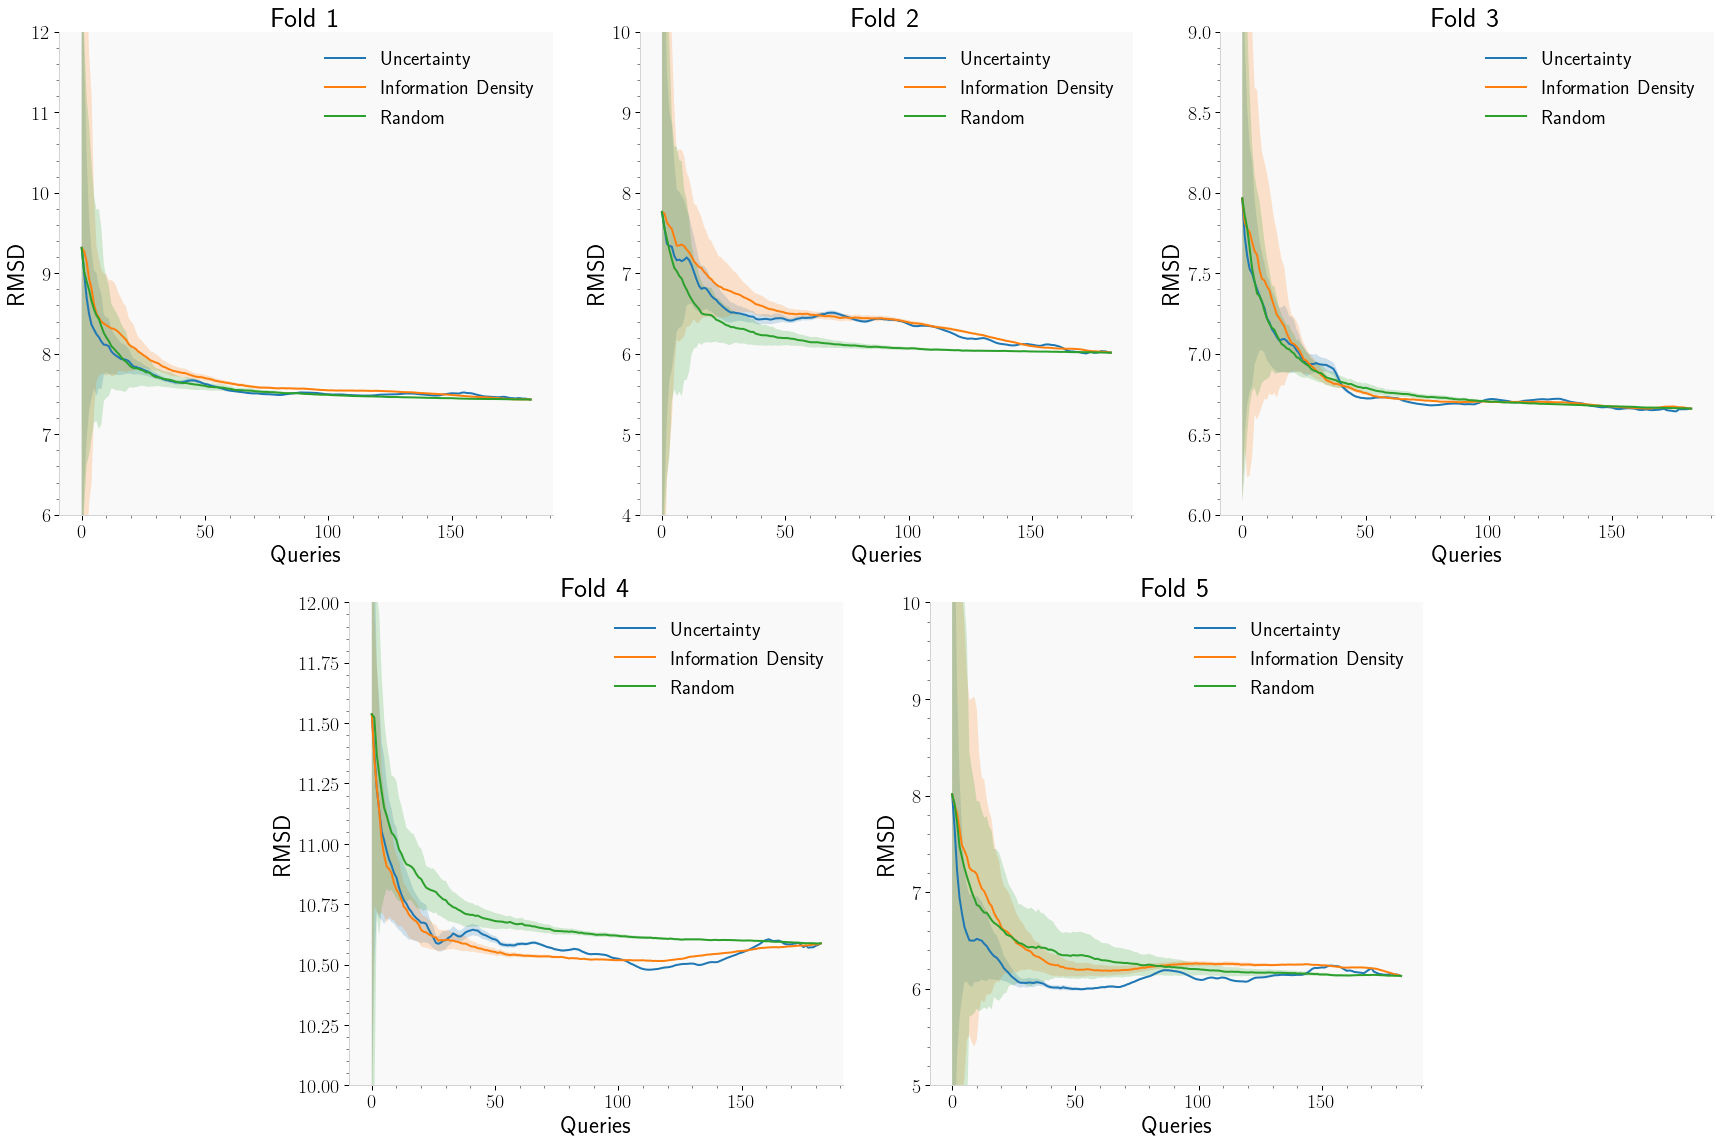

In [632]:
importlib.reload(sys.modules['chemdataval.chemdataval.visualisation'])
import chemdataval.chemdataval.visualisation as vis


fig, axs = vis.vis_parameterisation(parameterisation_results, strategies)

dft_ylims = [(6,12),(4,10),(6,9),(10,12),(5,10)]

for i, ax in enumerate(axs):
    ax.set_ylim(dft_ylims[i])

plt.tight_layout()
plt.savefig(f"Images/DFT_{model}_{metric}_bootstrap_{not(bootstrap_off)}.pdf",bbox_inches="tight")
plt.show()

# DFT Performance Data Valuation

## DFT Parameterisation with its own Shapley values

In [248]:
import importlib, sys
import chemdataval.chemdataval.testing_functions as testing_funcs
from scipy.stats import spearmanr

import chemdataval.chemdataval.monte_carlo as mc
importlib.reload(sys.modules['chemdataval.chemdataval.monte_carlo'])
import chemdataval.chemdataval.monte_carlo as mc

import chemdataval.chemdataval.informativeness as inform_funcs
importlib.reload(sys.modules['chemdataval.chemdataval.informativeness'])
import chemdataval.chemdataval.informativeness as inform_funcs

X = representations["AvSOAP"]
categorical = df["Categorical"].to_numpy()

dft_results = {}

seed_size = 10

with warnings.catch_warnings():
    # Remove the convergence and nearing bound warnings that fill up the output section
    warnings.simplefilter("ignore")

    kwargs = {"df":combined, 
        "R":1, 
        "metric":"RMSD", 
        "model":"noB88X",
        "bootstrap_off":False}

    idxs, scores = mc.test_inner_folds(
        dft_params.test_idx_parameterisation,
        kf=kf,
        X=X,
        Y=Y,
        seed_size=seed_size,
        inner_idxs=inner_mols,
        outer_idxs=outer_mols,
        groups=categorical,
        queries=50,
        random_runs=250,
        df=combined, 
        R=1, 
        metric="RMSD", 
        model="noB88X",
        bootstrap_off=False
        )

    dft_results["Values"] = [idxs, scores]
    
    test_inform = inform_funcs.informativeness_scoring(*dft_results["Values"], dset_size=266, seed_size=seed_size, subset_idxs=None)

    # Check that no point in the outermols set is being given an informativeness value.
    assert np.all(test_inform.mean(axis=0)[outer_mols].filled(0) == 0), "Points in the outer mols set are being assigned an informativeness value."

Running fold 1


100%|█████████████████████████████████████████| 250/250 [00:27<00:00,  9.21it/s]


Running fold 2


100%|█████████████████████████████████████████| 250/250 [00:27<00:00,  9.21it/s]


Running fold 3


100%|█████████████████████████████████████████| 250/250 [00:27<00:00,  9.24it/s]


Running fold 4


100%|█████████████████████████████████████████| 250/250 [00:27<00:00,  9.18it/s]


Running fold 5


100%|█████████████████████████████████████████| 250/250 [00:27<00:00,  9.21it/s]


[[138   4 237 ... 177 192  92]
 [207 110  30 ... 163 177 108]
 [224 253  98 ... 136 261  46]
 ...
 [ 87 106  46 ...  91 124 150]
 [217  94  67 ...  58  40 131]
 [235  25 218 ... 224 240   8]]
[[138   4 237 ... 177 192  92]
 [207 110  30 ... 163 177 108]
 [224 253  98 ... 136 261  46]
 ...
 [ 87 106  46 ...  91 124 150]
 [217  94  67 ...  58  40 131]
 [235  25 218 ... 224 240   8]]


## Notes of using stats to assess performance 

Each performance metric is sampled from a Gaussian distribution, so the overall performance metric is sampled from a multivariate Gaussian distribution. If each metric does indeed conform to a Gaussian, then we can work out the p value of how significant the difference is for 

The null hypothesis is that the difference between performance of the 'most informative' dataset and a randomly selected one is zero. The hypothesis is that the difference in magnitude of these errors is not zero.

The issue, I think, is that this assumes that the multivariate Gaussians are not correlated, whereas, in truth they are. If you choose the lowest value for Mean error, then all other errors decrease substantially. I think I can estimate the covariance matrix and then use that to define the multivarate gaussian that is being sampled from. Then it should be a fair estimation of how likely this is.


In [1046]:
#dft_inform = inform_funcs.informativeness_scoring(*dft_results["Values"], dset_size=266, seed_size=seed_size)

#inform = strategy_informativeness(kf_results, strategies, rep="CM", runs=100, folds=5, seed_size=50, dset_size=266, subset_idxs=inner_mols)

#print(np.corrcoef(dft_inform.mean(axis=0), inform.mean(axis=0)))
#spearmanr(dft_inform.mean(axis=0), inform.mean(axis=0))

[[1.000 -0.084]
 [-0.084 1.000]]


SpearmanrResult(correlation=-0.2219002531317514, pvalue=0.0002646822698001553)

[[138   4 237 ... 177 192  92]
 [207 110  30 ... 163 177 108]
 [224 253  98 ... 136 261  46]
 ...
 [ 87 106  46 ...  91 124 150]
 [217  94  67 ...  58  40 131]
 [235  25 218 ... 224 240   8]]


/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


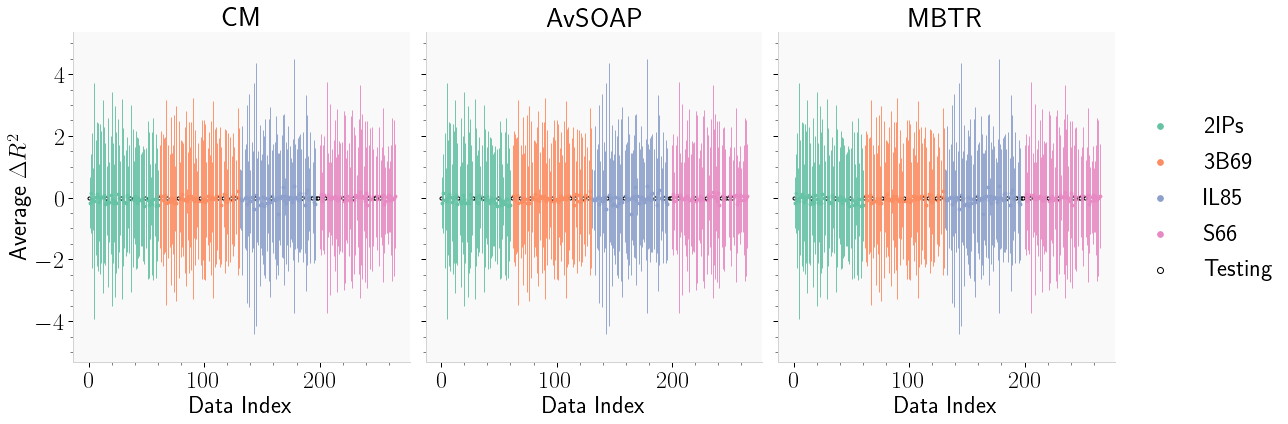

In [249]:
dset_size = 266
dft_inform = inform_funcs.informativeness_scoring(*dft_results["Values"], dset_size=266, seed_size=seed_size, subset_idxs=None)
#inform = np.ma.masked_equal(inform, 0)
#masked.mean(axis=0)

fig, axs = plt.subplots(1,3,figsize=(18,6), sharey=True)

for ax,rep in zip(axs,representations.keys()):
    dset_size = 266
    
    for dset in datasets["blyp"].keys():
        idxs = df["Dataset"] == dset
        ax.errorbar(np.arange(dset_size)[idxs], np.mean(dft_inform,axis=0)[idxs], yerr=np.var(dft_inform, axis=0)[idxs], linewidth=0.9, ls='none', c=dataset_colours[dset], markersize=5)
        ax.scatter(np.arange(dset_size)[idxs], np.mean(dft_inform,axis=0)[idxs], s=8, marker="o", color=str(dataset_colours[dset]), label=dset)
    
    ax.scatter(np.arange(dset_size)[outer_mols], np.zeros(len(outer_mols)), s=9, marker="o", color="w", edgecolor="k", label="Testing")
    ax.set_title(f"{rep}", fontsize=28)
    if rep == "CM":
        ax.set_ylabel("Average $\Delta R^2$", fontsize=24) #(x $10^{-3}$)
    ax.set_xlabel("Data Index", fontsize=24)

ax.legend(frameon=False, markerscale=2, fontsize=24, loc="center left", bbox_to_anchor=[1,0.5])

plt.tight_layout()
#plt.savefig("Images/Averaged Data Valuation AvSOAP.svg", bbox_inches="tight")
plt.show()

In [254]:
sizes = [x for x in range(5,190,5)]
Ts = [5000]# [500,1000,2500,5000,10000]

runs = 20
prop = "RMSD"
sampler = partial(dft_params.bootstrap, R=1, model="noB88X", bootstrap_off=True)
rep = "MBTR"
T = 1000
X = representations["AvSOAP"]

dft_inform = inform_funcs.informativeness_scoring(*dft_results["Values"], dset_size=266, seed_size=seed_size, subset_idxs=None)

dft_inform = dft_inform.mean(axis=0).filled(0) * T

fold_results, bad_fold_results, random_fold_results = [], [], []

# Restricting the dataset to just the inner mols.
for fold in kf.split(X[inner_mols],df["Categorical"].iloc[inner_mols]):
    # Splitting it into training and testing indices
    train_index, test_index = fold
    # Reindex the training and testing set as they will be used to grab samples from the large dataset.
    train_index, test_index = inner_mols[train_index], inner_mols[test_index]
    
    T_results = {}
    bad_T_results = {}
    for T in tqdm.tqdm(Ts):

        overall_results = []
        for size in sizes:
            selected_means = []
            
            for _ in range(runs):
                # The selected indices here are restricted to selecting from the training indices
                selected_idxs = np.random.choice(train_index, size=(int(size),), replace=False, p=utils.softmax(dft_inform[train_index]))
                utils.check_invalid_selection(selected_idxs, test_index)
                utils.check_invalid_selection(selected_idxs, outer_mols)

                selected_means.append(dft_params.test_coef(combined.iloc[test_index], sampler(combined.iloc[selected_idxs]))[prop])
            
                
            overall_results.append(selected_means)
            
        bad_overall_results = []
        for size in sizes:
            selected_means = []
            
            for _ in range(runs):
                # The -1 below inverts the informativeness values
                selected_idxs = np.random.choice(train_index, size=(int(size),), replace=False, p=utils.softmax(dft_inform[train_index]*-1))
                utils.check_invalid_selection(selected_idxs, test_index)
                utils.check_invalid_selection(selected_idxs, outer_mols)
                selected_means.append(dft_params.test_coef(combined.iloc[test_index], sampler(combined.iloc[selected_idxs]))[prop])
            
            bad_overall_results.append(selected_means)

        T_results[T] = overall_results
        bad_T_results[T] = bad_overall_results
    
    random_results = []
    for size in tqdm.tqdm(sizes):
        random_results.append([dft_params.test_coef(combined.iloc[test_index], sampler(combined.iloc[np.random.choice(train_index, size=(size,), replace=False)]))[prop] for x in range(runs)])
    
    random_fold_results.append(random_results)
    fold_results.append(T_results)
    bad_fold_results.append(bad_T_results)

# Outer fold testing
print("Conducting outer fold testing")
T_results = {}
bad_T_results = {}

for T in tqdm.tqdm(Ts):

    overall_results = []
    bad_overall_results = []
    for size in sizes:

        #The averages here returns a 239 dimensional array for only the inner fold.
        selected_means = []

        for _ in range(runs):
            # The selected indices here are restricted to selecting from the training indices
            selected_idxs = np.random.choice(inner_mols, size=(int(size),), replace=False, p=utils.softmax(dft_inform[inner_mols]))
            utils.check_invalid_selection(selected_idxs, outer_mols)
            selected_means.append(dft_params.test_coef(combined.iloc[outer_mols], sampler(combined.iloc[selected_idxs]))[prop])

        overall_results.append(selected_means)

        T_results[T] = overall_results

        #The averages here returns a 239 dimensional array for only the inner fold.
        selected_means = []
        for _ in range(runs):
            # The selected indices here are restricted to selecting from the training indices
            selected_idxs = np.random.choice(inner_mols, size=(int(size),), replace=False, p=utils.softmax(dft_inform[inner_mols]*-1))
            utils.check_invalid_selection(selected_idxs, outer_mols)
            selected_means.append(dft_params.test_coef(combined.iloc[outer_mols], sampler(combined.iloc[selected_idxs]))[prop])

        bad_overall_results.append(selected_means)

        bad_T_results[T] = bad_overall_results

    random_results = []

    for size in sizes:
        random_results.append([dft_params.test_coef(combined.iloc[outer_mols], sampler(combined.iloc[np.random.choice(inner_mols, size=(size,), replace=False)]))[prop] for x in range(runs)])

random_fold_results.append(random_results)
fold_results.append(T_results)
bad_fold_results.append(bad_T_results)


[[138   4 237 ... 177 192  92]
 [207 110  30 ... 163 177 108]
 [224 253  98 ... 136 261  46]
 ...
 [ 87 106  46 ...  91 124 150]
 [217  94  67 ...  58  40 131]
 [235  25 218 ... 224 240   8]]


100%|███████████████████████████████████████████| 37/37 [00:01<00:00, 23.26it/s]


Conducting outer fold testing


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


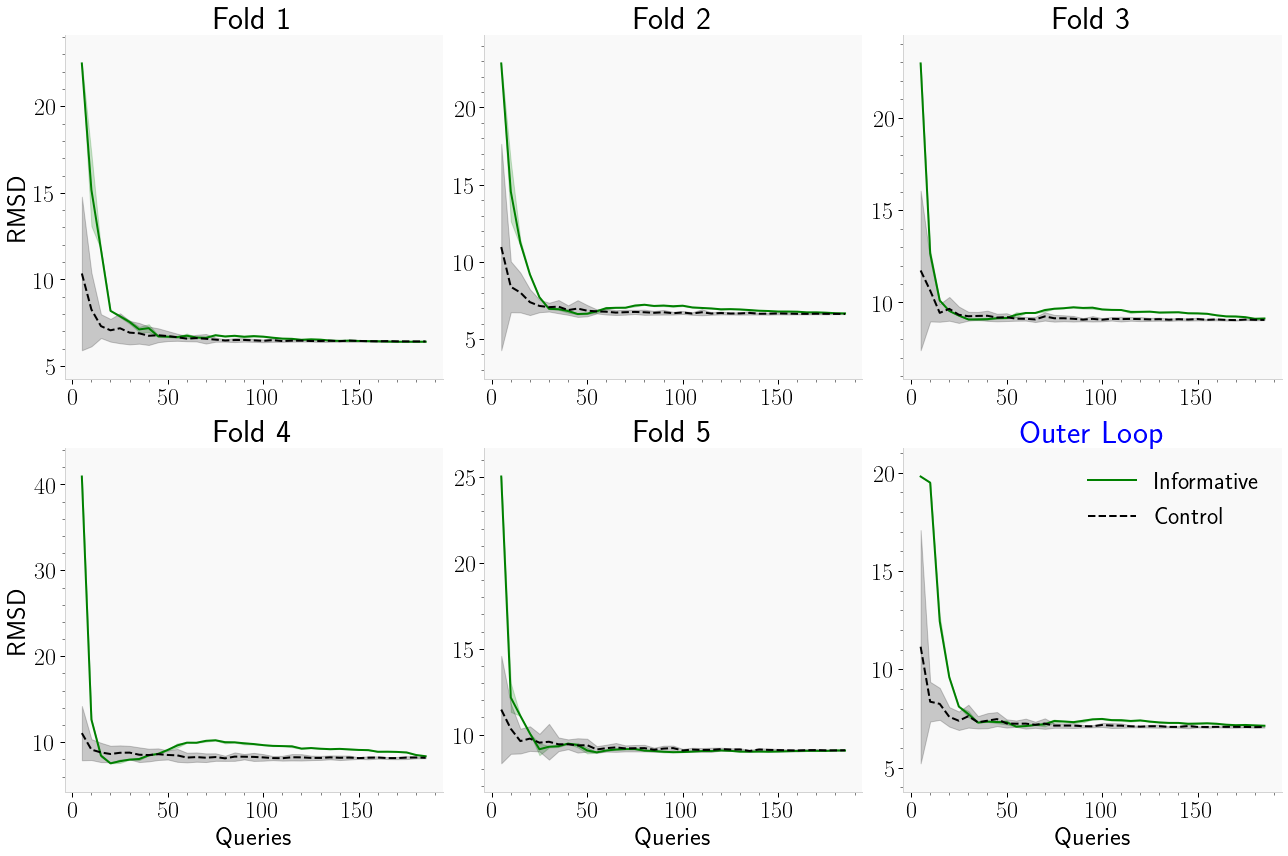

In [255]:
cols, rows = 3, 2
cols_height = 6
rows_width = 6

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height))

coords = np.arange(rows * cols).reshape(rows,cols)

legend_on = False
i = 0
ylims = [(5,11),(5,11),(7,12),(6,11),(7,13),(5.5,12)]

for idx,(results,random_result,bad_result, ylim) in enumerate(zip(fold_results,random_fold_results, bad_fold_results, ylims)):
    x,y = np.where(coords == idx)
    ax = axs[x,y][0]
    
    if i == 1:
        legend_on = True
    if i > 2:
        ax.set_xlabel("Queries",fontsize=26)
    if idx in [0,3]:
        ax.set_ylabel("RMSD", fontsize=26)
        
    if idx < 5:
        fold = idx
        ax.set_title(f"Fold {idx + 1}",  fontsize=32)
    else: 
        ax.set_title("Outer Loop", fontsize=32, color="blue")
       
    
    #ax.set_ylim(*ylim)
    vis.plot_multiple_runs(sizes,results[Ts[0]],ax=ax, color="green", label="Informative")
    #vis.plot_multiple_runs(sizes,bad_result[Ts[0]],ax=ax, color="red", label="Uninformative")
    vis.plot_multiple_runs(sizes,random_result,ax=ax, color="black", label="Control", linestyle="--")
    i += 1

plt.legend(frameon=False, fontsize=24)
plt.tight_layout()
#plt.savefig("Images/Intelligent_DFT_Parameterisation.pdf", bbox_inches="tight")
plt.show()

## DFT Parameterisation from GPR Data Shapley Values

In [719]:
sizes = [x for x in range(5,190,5)]
Ts = [5000]# [500,1000,2500,5000,10000]

runs = 20
prop = "RMSD"
sampler = partial(dft_params.bootstrap, R=1, model="noB88X", bootstrap_off=True)
rep = "AvSOAP"
T = 10000
X = representations["AvSOAP"]

#inform = inform_funcs.strategy_informativeness(restructured_kf, strategies, rep=rep, runs=active_learning_runs, folds=5, seed_size=seed_sizes[rep], dset_size=266, subset_idxs=inner_mols)
inform = inform_funcs.fold_informativeness(restructured_kf, rep=rep, strategy="Random", seed_size=seed_sizes[rep], dset_size=266, subset_idxs=inner_mols)
inform = inform.mean(axis=0).filled(0) * T

fold_results, bad_fold_results, random_fold_results = [], [], []

# Restricting the dataset to just the inner mols.
for fold in kf.split(X[inner_mols],df["Categorical"].iloc[inner_mols]):
    # Splitting it into training and testing indices
    train_index, test_index = fold
    # Reindex the training and testing set as they will be used to grab samples from the large dataset.
    train_index, test_index = inner_mols[train_index], inner_mols[test_index]
    
    T_results = {}
    bad_T_results = {}
    for T in tqdm.tqdm(Ts):

        overall_results = []
        for size in sizes:
            selected_means = []
            
            for _ in range(runs):
                # The selected indices here are restricted to selecting from the training indices
                selected_idxs = np.random.choice(train_index, size=(int(size),), replace=False, p=utils.softmax(inform[train_index]))
                utils.check_invalid_selection(selected_idxs, test_index)
                utils.check_invalid_selection(selected_idxs, outer_mols)

                selected_means.append(dft_params.test_coef(combined.iloc[test_index], sampler(combined.iloc[selected_idxs]))[prop])
            
                
            overall_results.append(selected_means)
            
        bad_overall_results = []
        for size in sizes:
            selected_means = []
            
            for _ in range(runs):
                # The -1 below inverts the informativeness values
                selected_idxs = np.random.choice(train_index, size=(int(size),), replace=False, p=utils.softmax(inform[train_index]*-1))
                utils.check_invalid_selection(selected_idxs, test_index)
                utils.check_invalid_selection(selected_idxs, outer_mols)
                selected_means.append(dft_params.test_coef(combined.iloc[test_index], sampler(combined.iloc[selected_idxs]))[prop])
            
            bad_overall_results.append(selected_means)

        T_results[T] = overall_results
        bad_T_results[T] = bad_overall_results
    
    random_results = []
    for size in tqdm.tqdm(sizes):
        random_results.append([dft_params.test_coef(combined.iloc[test_index], sampler(combined.iloc[np.random.choice(train_index, size=(size,), replace=False)]))[prop] for x in range(runs)])
    
    random_fold_results.append(random_results)
    fold_results.append(T_results)
    bad_fold_results.append(bad_T_results)

# Outer fold testing
print("Conducting outer fold testing")
T_results = {}
bad_T_results = {}

for T in tqdm.tqdm(Ts):

    overall_results = []
    bad_overall_results = []
    for size in sizes:

        #The averages here returns a 239 dimensional array for only the inner fold.
        selected_means = []

        for _ in range(runs):
            # The selected indices here are restricted to selecting from the training indices
            selected_idxs = np.random.choice(inner_mols, size=(int(size),), replace=False, p=utils.softmax(inform[inner_mols]))
            utils.check_invalid_selection(selected_idxs, outer_mols)
            selected_means.append(dft_params.test_coef(combined.iloc[outer_mols], sampler(combined.iloc[selected_idxs]))[prop])

        overall_results.append(selected_means)

        T_results[T] = overall_results

        #The averages here returns a 239 dimensional array for only the inner fold.
        selected_means = []
        for _ in range(runs):
            # The selected indices here are restricted to selecting from the training indices
            selected_idxs = np.random.choice(inner_mols, size=(int(size),), replace=False, p=utils.softmax(inform[inner_mols]*-1))
            utils.check_invalid_selection(selected_idxs, outer_mols)
            selected_means.append(dft_params.test_coef(combined.iloc[outer_mols], sampler(combined.iloc[selected_idxs]))[prop])

        bad_overall_results.append(selected_means)

        bad_T_results[T] = bad_overall_results

    random_results = []

    for size in sizes:
        random_results.append([dft_params.test_coef(combined.iloc[outer_mols], sampler(combined.iloc[np.random.choice(inner_mols, size=(size,), replace=False)]))[prop] for x in range(runs)])

random_fold_results.append(random_results)
fold_results.append(T_results)
bad_fold_results.append(bad_T_results)


100%|███████████████████████████████████████████| 37/37 [00:01<00:00, 23.82it/s]


Conducting outer fold testing


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


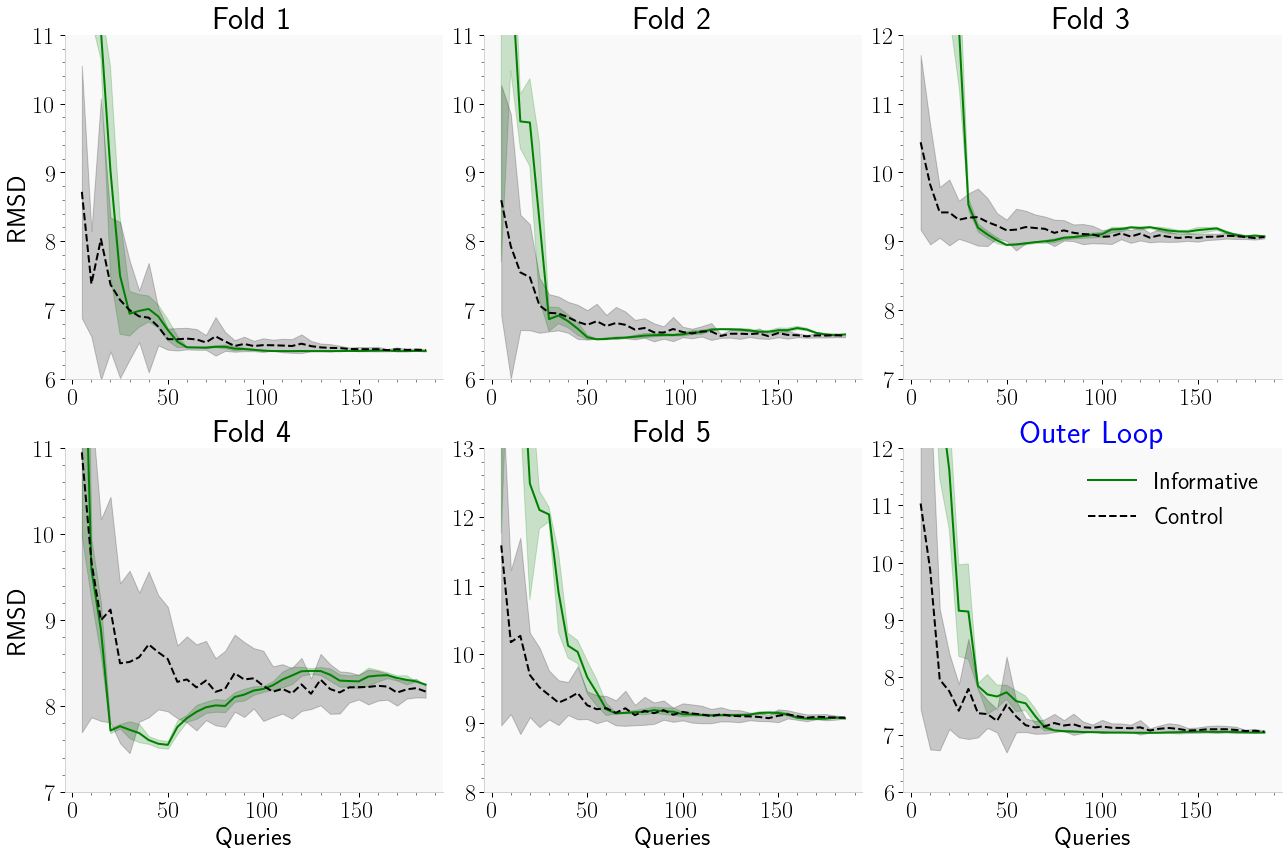

In [720]:
cols, rows = 3, 2
cols_height = 6
rows_width = 6

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height))

coords = np.arange(rows * cols).reshape(rows,cols)

legend_on = False
i = 0
ylims = [(6,11),(6,11),(7,12),(7,11),(8,13),(6,12)]

for idx,(results,random_result,bad_result, ylim) in enumerate(zip(fold_results,random_fold_results, bad_fold_results, ylims)):
    x,y = np.where(coords == idx)
    ax = axs[x,y][0]
    
    if i == 1:
        legend_on = True
    if i > 2:
        ax.set_xlabel("Queries",fontsize=26)
    if idx in [0,3]:
        ax.set_ylabel("RMSD", fontsize=26)
        
    if idx < 5:
        fold = idx
        ax.set_title(f"Fold {idx + 1}",  fontsize=32)
    else: 
        ax.set_title("Outer Loop", fontsize=32, color="blue")
       
    
    ax.set_ylim(*ylim)
    #ax.set_ylim(5,15)
    vis.plot_multiple_runs(sizes,results[Ts[0]],ax=ax, color="green", label="Informative")
    #vis.plot_multiple_runs(sizes,bad_result[Ts[0]],ax=ax, color="red", label="Uninformative")
    vis.plot_multiple_runs(sizes,random_result,ax=ax, color="black", label="Control", linestyle="--")
    i += 1

plt.legend(frameon=False, fontsize=24)
plt.tight_layout()
plt.savefig(f"Images/Intelligent_DFT_Parameterisation_{rep}.pdf", bbox_inches="tight")
plt.show()

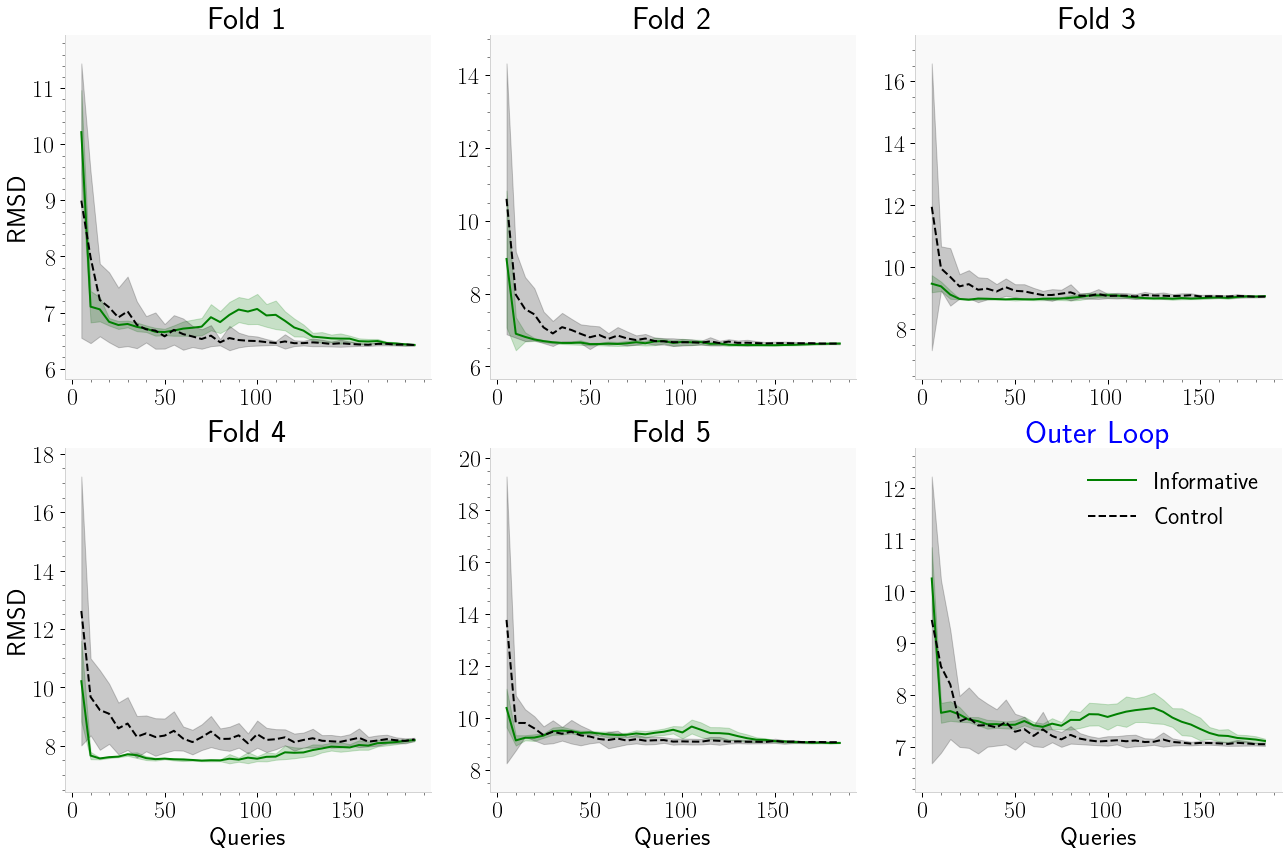

In [97]:
cols, rows = 3, 2
cols_height = 6
rows_width = 6

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height))

coords = np.arange(rows * cols).reshape(rows,cols)

legend_on = False
i = 0
#ylims = [(5,11),(5,11),(7,12),(6,11),(7,13),(5.5,12)]

for idx,(results,random_result,bad_result, ylim) in enumerate(zip(fold_results,random_fold_results, bad_fold_results, ylims)):
    x,y = np.where(coords == idx)
    ax = axs[x,y][0]
    
    if i == 1:
        legend_on = True
    if i > 2:
        ax.set_xlabel("Queries",fontsize=26)
    if idx in [0,3]:
        ax.set_ylabel("RMSD", fontsize=26)
        
    if idx < 5:
        fold = idx
        ax.set_title(f"Fold {idx + 1}",  fontsize=32)
    else: 
        ax.set_title("Outer Loop", fontsize=32, color="blue")
       
    
    #ax.set_ylim(*ylim)
    vis.plot_multiple_runs(sizes,results[Ts[0]],ax=ax, color="green", label="Informative")
    #vis.plot_multiple_runs(sizes,bad_result[Ts[0]],ax=ax, color="red", label="Uninformative")
    vis.plot_multiple_runs(sizes,random_result,ax=ax, color="black", label="Control", linestyle="--")
    i += 1

plt.legend(frameon=False, fontsize=24)
plt.tight_layout()
#plt.savefig("Images/Intelligent_DFT_Parameterisation.pdf", bbox_inches="tight")
plt.show()

In [420]:
props = {'Mean': -0.874,
 'MAD': -0.233,
 'MAE': 2.79,
 'RMSD': 7.762,
 'SD': 7.712,
 'MIN': 0.233,
 'MAX': 20.119,
 'LOW': -20.119,
 'UP': 13.311}

T = 10000

prop_results = {}
prop_random_results = {}
for prop in tqdm.tqdm(props.keys()):

    overall_results = []
    for size in sizes:

        #The averages here returns a 239 dimensional array for only the inner fold.
        averages = np.mean(inform, axis=0) * T
        selected_means = []
        
        selected_idxs = inner_mols[np.argsort(averages)][:size]
        assert len(np.intersect1d(selected_idxs, outer_mols)) == 0, "It is selecting testing molecules."
        selected_means.append(test_coef(combined.iloc[outer_mols], sampler(combined.iloc[selected_idxs]))[prop])
            
        overall_results.append(selected_means)

        prop_results[prop] = overall_results
    
    random_results = []
    
    for size in sizes:
        random_results.append([test_coef(combined.iloc[outer_mols], sampler(combined.iloc[np.random.choice(inner_mols, size=(size,), replace=False)]))[prop] for x in range(runs)])
    
    prop_random_results[prop] = random_results

100%|█████████████████████████████████████████████| 9/9 [01:10<00:00,  7.88s/it]


IndexError: index 0 is out of bounds for axis 0 with size 0

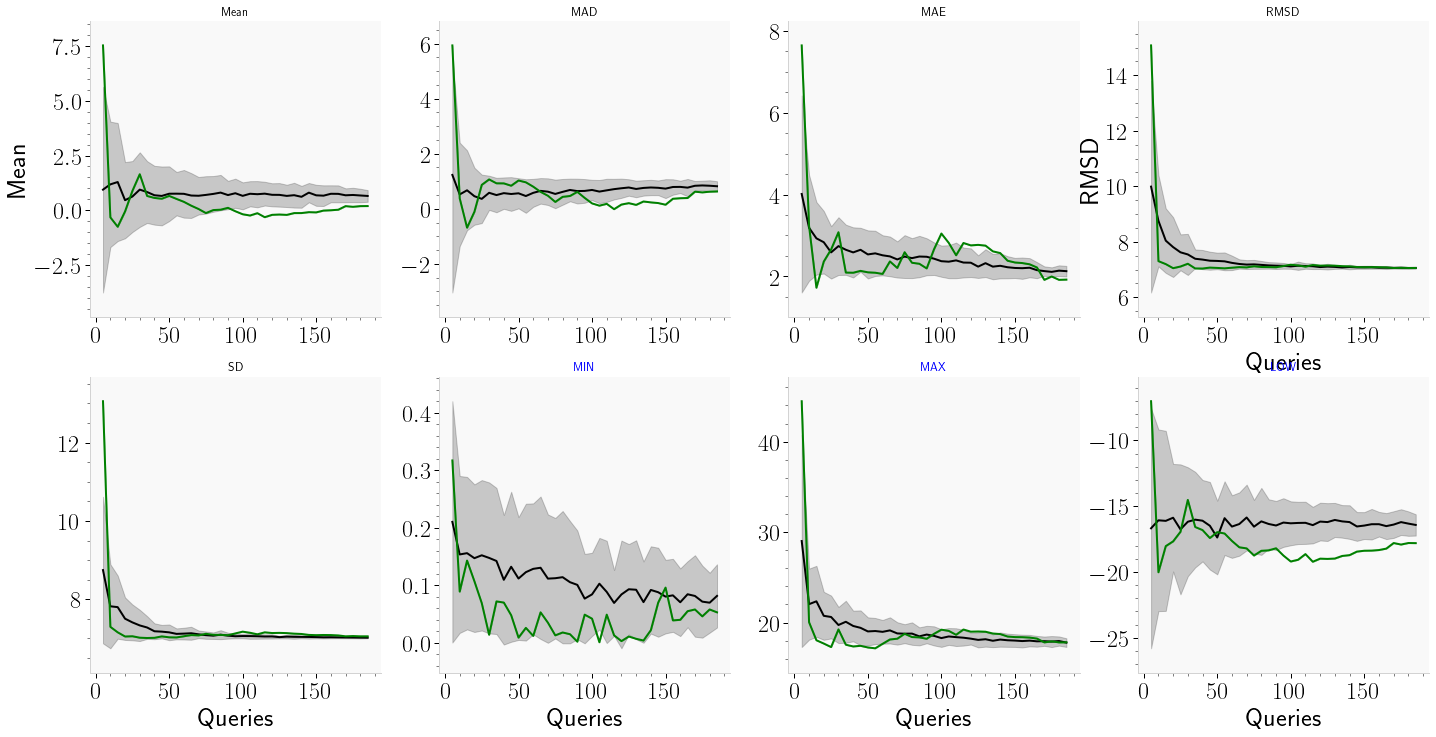

In [440]:
cols, rows = 4, 2
cols_height = 6
rows_width = 6

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height))

coords = np.arange(rows * cols).reshape(rows,cols)

legend_on = False
i = 0

for idx,(results,random_result, prop) in enumerate(zip(prop_results, prop_random_results, props.keys())):
    x,y = np.where(coords == idx)
    ax = axs[x,y][0]
    
    if i == 1:
        legend_on = True
    if i > 2:
        ax.set_xlabel("Queries",fontsize=26)
    if idx in [0,3]:
        ax.set_ylabel(prop, fontsize=26)
        
    if idx < 5:
        fold = idx
    else: 
        fold = None
        ax.set_title("Outer Loop", fontsize=32, color="blue")
        
    plot_multiple_runs(sizes,prop_random_results[random_result], color="black", ax=ax)
    plot_multiple_runs(sizes,prop_results[results], color="green", ax=ax)

    ax.set_title(prop)
    i += 1
    legend_on = False

In [ ]:
inform1 = fold_informativeness(kf_results["AvSOAP"], strategy="Random", runs=100, folds=5, seed_size=50, dset_size=239, subset_idxs=None).mean(axis=0)
inform2 = fold_informativeness(kf_results["CM"], strategy="Random", runs=100, folds=5, seed_size=50, dset_size=239, subset_idxs=None).mean(axis=0)
inform3 = fold_informativeness(kf_results["MBTR"], strategy="Random", runs=100, folds=5, seed_size=50, dset_size=239, subset_idxs=None).mean(axis=0)

aggregate_scores = []
random_scores = []

for size in range(5,150,5):

    sel1 = inner_mols[np.argsort(inform1[~inform1.mask])[::-1]][size]
    sel2 = inner_mols[np.argsort(inform2[~inform1.mask])[::-1]][size]
    sel3 = inner_mols[np.argsort(inform3[~inform1.mask])[::-1]][size]

    test_idxs = np.unique([sel1, sel2, sel3])

    sampler = partial(bootstrap, R=1, model="noB88X", bootstrap_off=True)

    aggregate_scores.append(test_coef(combined.iloc[outer_mols], sampler(combined.iloc[test_idxs]))[prop])
    
    random_scores.append(test_coef(combined.iloc[outer_mols],sampler(combined.iloc[np.random.choice(inner_mols, size=(len(test_idxs),))]))[prop])

# Dataset level importance

In [2196]:
from itertools import combinations

explicit_rep_values = {}
 
options = [0,1,2,3]
combinations_ = [(),]
for i in range(1,len(options)+1):
    combinations_.extend(list(combinations(options, i)))

dataset_results = []

for comb in tqdm.tqdm(combinations_):
    if len(comb) == 0:
        dataset_results.append(10)
        continue

    idxs = reduce(np.logical_or, [df["Categorical"].iloc[inner_mols] == idx for idx in comb])
    res = test_idx_parameterisation(representations["CM"], Y, inner_mols[idxs], outer_mols,df=combined,R=1,metric="RMSD",model="noB88X",bootstrap_off=True)
    dataset_results.append(res)    
        
results = {key : val for key, val in zip(combinations_, dataset_results)}
    
explicit_rep_values["DFT"] = results


for rep in representations:

    options = [0,1,2,3]
    combinations_ = [(),]
    for i in range(1,len(options)+1):
        combinations_.extend(list(combinations(options, i)))

    dataset_results = []
    for comb in tqdm.tqdm(combinations_):
        if len(comb) == 0:
            dataset_results.append(0)
            continue

        idxs = reduce(np.logical_or, [df["Categorical"].iloc[inner_mols] == idx for idx in comb])
        res = mc.test_model(representations[rep], Y, inner_mols[idxs], outer_mols, model=GaussianProcessRegressor, kernel=kernel)
        #res = test_idx_parameterisation(representations["CM"], Y, inner_mols[idxs], outer_mols,df=combined,R=1,metric="RMSD",model="noB88X",bootstrap_off=True)
        #dataset_results.append(res)    
        if res < 0:
            dataset_results.append(0)
        else:
            dataset_results.append(res)
            
    results = {key : val for key, val in zip(combinations_, dataset_results)}
    
    explicit_rep_values[rep] = results



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 10/16 [00:02<00:01,  3.23it/s]/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:05<00:00,  3.16it/s]


In [894]:
from matplotlib.patches import Ellipse, Polygon, Circle
from operator import add, sub
   
import chemdataval.chemdataval.explicit_shapley as exp_shap
importlib.reload(sys.modules['chemdataval.chemdataval.explicit_shapley'])
import chemdataval.chemdataval.explicit_shapley as exp_shap


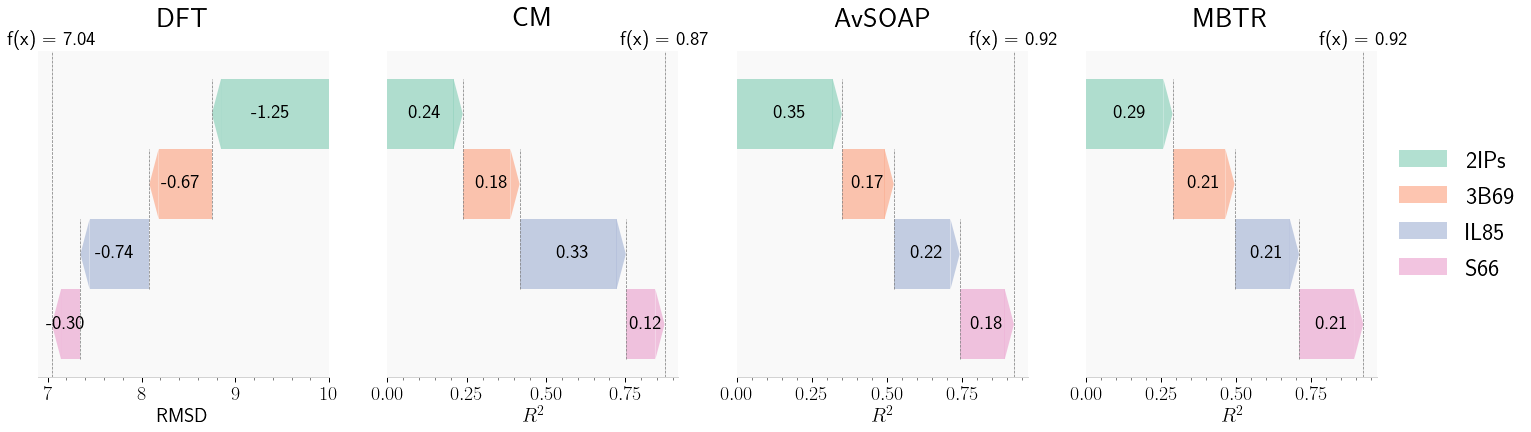

In [2225]:
cols, rows = 4,1 
rows_width = 6
cols_height = 6

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height), sharey=True)
coords = np.arange(rows * cols).reshape(rows,cols)

for idx,(rep, results) in enumerate(explicit_rep_values.items()):
    x,y = np.where(coords == idx)
    ax = axs[idx]#axs[x[0],y[0]]
    
    test = exp_shap.Shapley_Values(results)

    test.Shapley_Values()

    res = {x : y for x, y in zip(dataset_colours.keys(), test.Shapley_Values().values())}
    label = '$R^2$' if idx > 0 else "RMSD"
    vis.waterfall_plot(res, list(dataset_colours.values()), results[()], xlabel=label, ax=ax)
    ax.set_title(rep, fontsize=28, pad=25)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    
plt.legend(frameon=False, fontsize=24, loc="center left", bbox_to_anchor=(1,0.5))
plt.savefig("Images/Explitic Shapley Values.svg", bbox_inches="tight")
plt.savefig("Images/Explitic Shapley Values.pdf", bbox_inches="tight")
plt.show()

In [1786]:
from chemdataval.chemdataval import coarse_graining as cg
importlib.reload(sys.modules['chemdataval.chemdataval.coarse_graining'])
from chemdataval.chemdataval import coarse_graining as cg

import chemdataval.chemdataval.monte_carlo as mc
importlib.reload(sys.modules['chemdataval.chemdataval.monte_carlo'])
import chemdataval.chemdataval.monte_carlo as mc

with warnings.catch_warnings():
    # Remove the convergence and nearing bound warnings that fill up the output section
    
    warnings.simplefilter("ignore")
    coarse_model = cg.Coarse_Graining(representations["AvSOAP"], Y, inner_mols, outer_mols, mc.test_model)
    coarse_model.coarse_graining(16, 4, 1, 4, mc.test_model, keep=0.99, target="negative", min_points_in_chunk=50, model=GaussianProcessRegressor, kernel=kernel)

  0%|                                                                                                                                                                                                                      | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

## Additional datasets

In [960]:
esol["measured log solubility in mols per litre

0      -0.770
1      -3.300
2      -2.060
3      -7.870
4      -1.330
        ...  
1123   -1.710
1124    0.106
1125   -3.091
1126   -3.180
1127   -4.522
Name: measured log solubility in mols per litre, Length: 1128, dtype: float64

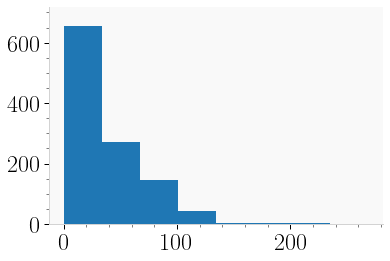

In [947]:
bins = plt.hist(esol["Polar Surface Area"], bins=8)[1]
esol['psa_groups'] = (np.select([esol['Polar Surface Area'].between(i, j, inclusive='right') 
                           for i,j in zip(bins, bins[1:])], 
                          range(len(bins)-1)))

In [950]:
extra_explicit_rep_values = {}
prop = "psa_groups"
dset = "ESOL"
extra_df = esol

options = np.unique(extra_df[prop])
combinations_ = [(),]

for i in range(1,len(options)+1):
    combinations_.extend(list(combinations(options, i)))

extra_dataset_results = []
    
for comb in tqdm.tqdm(combinations_):
    if len(comb) == 0:
        extra_dataset_results.append(0)
        continue

    idxs = reduce(np.logical_or, [extra_df[prop].iloc[extra_inners[dset]] == idx for idx in comb])
    res = mc.test_model(extra_reps[dset], extra_props[dset], extra_inners[dset][idxs], extra_outers[dset], model=GaussianProcessRegressor, kernel=kernel)
    if res < 0:
        extra_dataset_results.append(0)
    else:
        extra_dataset_results.append(res)

results = {key : val for key, val in zip(combinations_, extra_dataset_results)}

extra_explicit_rep_values[dset] = results


 67%|███████████████████████████▍             | 171/256 [00:30<00:35,  2.38it/s]/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
100%|█████████████████████████████████████████| 256/256 [00:57<00:00,  4.48it/s]


[0.3056408331292074, 0.2197641047138152, 0.14521374819250346, 0.17534338589770204, 0.0025953071002834467, 0.0014547970100165647, 0.009896909547913503, 0.0009347774672909757]
0.8608438630587325


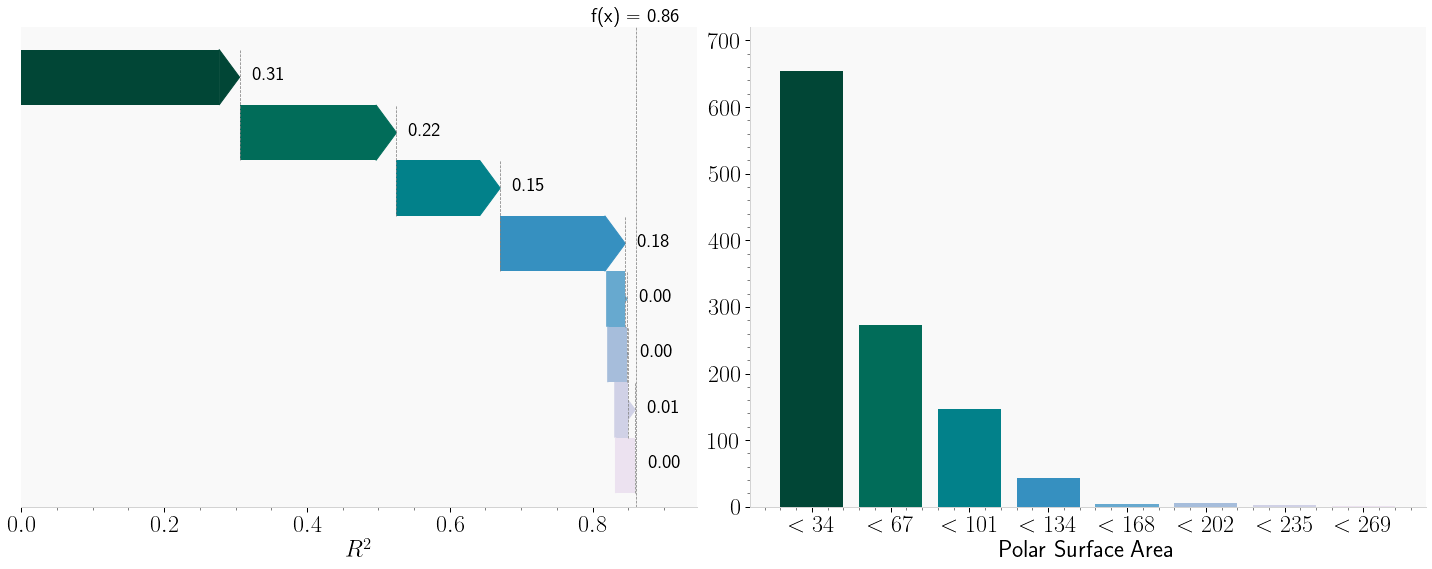

In [964]:
fig, axs = plt.subplots(1,2,figsize=(20,8))

ax = axs[0]

test = exp_shap.Shapley_Values(results)

psa_cols = ['#fff7fb','#ece2f0','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016c59','#014636'][::-1]

res = {x : y for x, y in zip(options, test.Shapley_Values().values())}

vis.waterfall_plot(res, psa_cols, results[()], xlabel="$R^2$", ax=ax)

ax.set_xlabel("$R^2$", fontsize=24)

ax = axs[1]

ax.bar(np.unique(esol['psa_groups']), [np.sum(esol['psa_groups'] == x) for x in np.unique(esol['psa_groups'])], color=psa_cols)
ax.set_xticks(range(len(bins)-1))
ax.set_xticklabels([f"$<{val:.0f}$" for val in bins[1:]])
ax.set_xlabel("Polar Surface Area", fontsize=24)

plt.tight_layout()

plt.savefig("Images/ESOL PSA.pdf", bbox_inches="tight")
plt.savefig("Images/ESOL PSA.svg", bbox_inches="tight")


In [ ]:
bins = plt.hist(esol["measured log solubility in mols per litre"], bins=8)[1]
esol['psa_groups'] = (np.select([esol['Polar Surface Area'].between(i, j, inclusive='right') 
                           for i,j in zip(bins, bins[1:])], 
                          range(len(bins)-1)))

In [932]:
import chemdataval.chemdataval.explicit_shapley as exp_shap
importlib.reload(sys.modules['chemdataval.chemdataval.explicit_shapley'])
import chemdataval.chemdataval.explicit_shapley as exp_shap

import chemdataval.chemdataval.visualisation as vis
importlib.reload(sys.modules['chemdataval.chemdataval.visualisation'])
import chemdataval.chemdataval.visualisation as vis

In [ ]:
bins = list(range(0,700,100)) + [900]
esol['mw_groups'] = (np.select([esol['Molecular Weight'].between(i, j, inclusive='right') 
                           for i,j in zip(bins, bins[1:])], 
                          range(len(bins)-1)))

In [ ]:
np.unique(esol['mw_groups'])

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
from itertools import combinations

import chemdataval.chemdataval.explicit_shapley as exp_shap
importlib.reload(sys.modules['chemdataval.chemdataval.explicit_shapley'])
import chemdataval.chemdataval.explicit_shapley as exp_shap

extra_explicit_rep_values = {}
prop = "mw_groups"
dset = "ESOL"
extra_df = esol

options = np.unique(extra_df[prop])
combinations_ = [(),]

for i in range(1,len(options)+1):
    combinations_.extend(list(combinations(options, i)))

extra_dataset_results = []
    
for comb in tqdm.tqdm(combinations_):
    if len(comb) == 0:
        extra_dataset_results.append(0)
        continue

    idxs = reduce(np.logical_or, [extra_df[prop].iloc[extra_inners[dset]] == idx for idx in comb])
    res = mc.test_model(extra_reps[dset], extra_props[dset], extra_inners[dset][idxs], extra_outers[dset], model=GaussianProcessRegressor, kernel=kernel)
    if res < 0:
        extra_dataset_results.append(0)
    else:
        extra_dataset_results.append(res)

results = {key : val for key, val in zip(combinations_, extra_dataset_results)}

extra_explicit_rep_values[dset] = results



100%|█████████████████████████████████████████| 128/128 [00:24<00:00,  5.16it/s]


[0.12055050098471766, 0.13368208283624958, 0.225062375700866, 0.23478705942061992, 0.11264976928699204, 0.024762890487595786, 0.009349184341691396]
0.8608438630587324


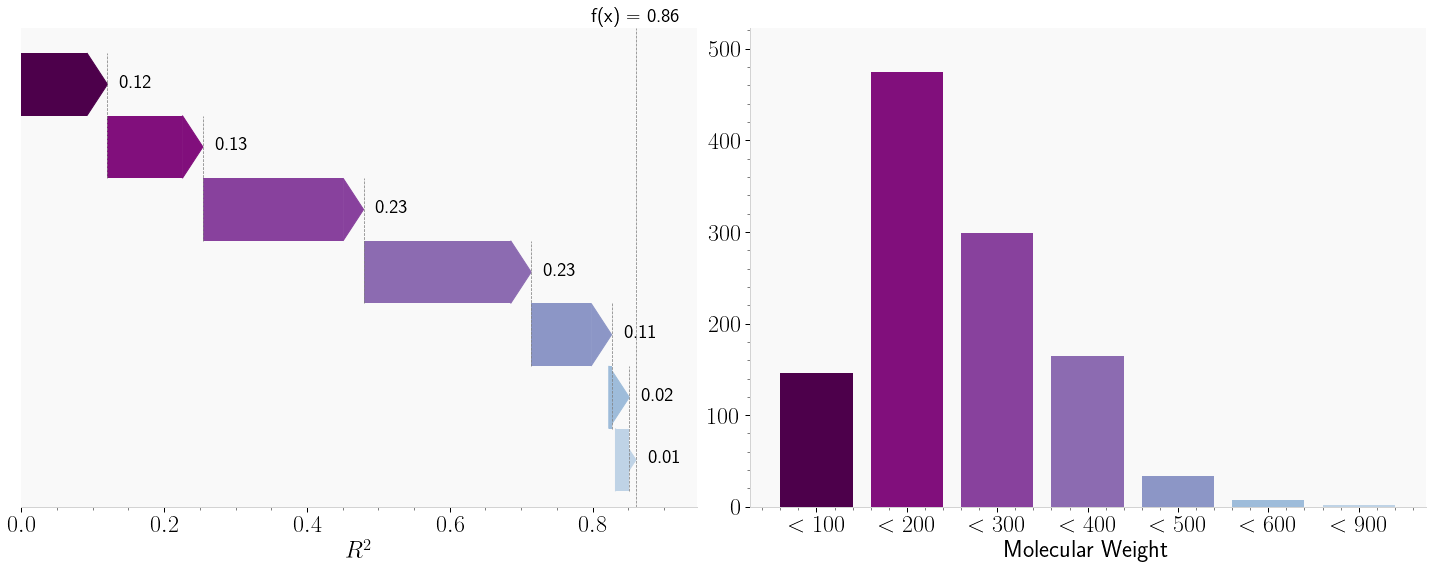

In [934]:
fig, axs = plt.subplots(1,2,figsize=(20,8))

ax = axs[0]

test = exp_shap.Shapley_Values(results)

ring_cols = ['#f7fcfd','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#810f7c','#4d004b'][::-1]

res = {x : y for x, y in zip(options, test.Shapley_Values().values())}

vis.waterfall_plot(res, ring_cols, results[()], xlabel="Rings", ax=ax)

ax.set_xlabel("$R^2$", fontsize=24)

ax = axs[1]

ax.bar(np.unique(esol['mw_groups']), [np.sum(esol['mw_groups'] == x) for x in np.unique(esol['mw_groups'])], color=ring_cols)
ax.set_xticks(range(len(bins)-1))
ax.set_xticklabels([f"$<{str(val)}$" for val in bins[1:]])
ax.set_xlabel("Molecular Weight", fontsize=24)

plt.tight_layout()

plt.savefig("Images/ESOL Molecular Weight.pdf", bbox_inches="tight")
plt.savefig("Images/ESOL Molecular Weight.svg", bbox_inches="tight")


[0.19776744475810445, 0.1186450389065951, 0.2058441091702673, 0.21919223105215355, 0.11939503917161229]
0.8608438630587327
[0.19776744475810445, 0.1186450389065951, 0.2058441091702673, 0.21919223105215355, 0.11939503917161229]
0.8608438630587327


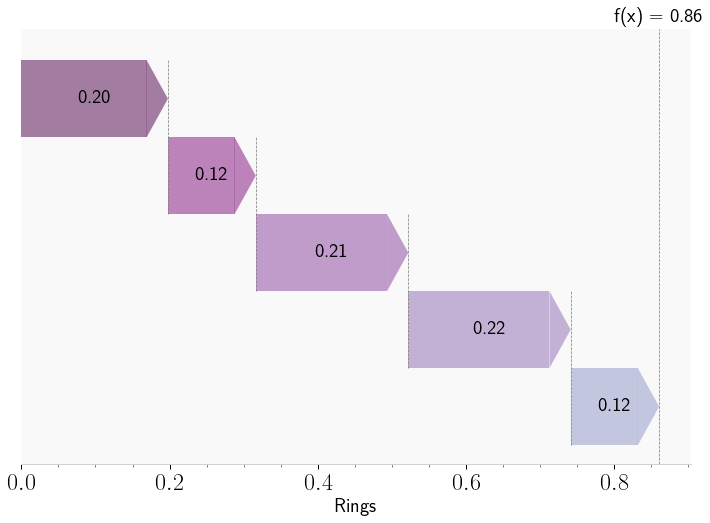

In [846]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

test = exp_shap.Shapley_Values(results)

test.Shapley_Values()

ring_cols = ['#f7fcfd','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#810f7c','#4d004b'][::-1]

res = {x : y for x, y in zip(options, test.Shapley_Values().values())}

waterfall_plot(res, ring_cols, results[()], xlabel="Rings", ax=ax)

In [729]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

for idx,(dset, results) in enumerate(extra_explicit_rep_values.items()):
    x,y = np.where(coords == idx)
    ax = axs[idx]#axs[x[0],y[0]]
    
    test = exp_shap.Shapley_Values(results)

    test.Shapley_Values()

    res = {x : y for x, y in zip(dataset_colours.keys(), test.Shapley_Values().values())}
    label = '$R^2$' if idx > 0 else "RMSD"
    waterfall_plot(res, list(dataset_colours.values()), results[()], xlabel=label, ax=ax)
    ax.set_title(rep, fontsize=28, pad=25)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    
plt.legend(frameon=False, fontsize=24, loc="center left", bbox_to_anchor=(1,0.5))
plt.savefig("Images/Explitic Shapley Values.svg", bbox_inches="tight")
plt.savefig("Images/Explitic Shapley Values.pdf", bbox_inches="tight")
plt.show()

{'ESOL': array([[4.826, 2.562, 2.559, ..., 2.227, -0.082, 5.691],
        [0.234, 0.148, 0.012, ..., -0.360, -0.082, -0.317],
        [-0.488, -0.332, -0.475, ..., -0.360, -0.082, -0.317],
        ...,
        [-0.448, 0.157, 0.459, ..., -0.360, -0.082, -0.317],
        [-0.978, -1.209, -1.271, ..., -0.360, -0.082, -0.317],
        [0.306, 1.228, 1.631, ..., -0.360, -0.082, -0.317]]),
 'FreeSolv': array([[0.395, 0.788, 0.544, ..., -0.267, 0.000, -0.044],
        [0.599, -0.802, -0.340, ..., -0.267, 0.000, -0.044],
        [-0.918, -0.864, -0.936, ..., -0.267, 0.000, -0.044],
        ...,
        [0.740, -0.148, -0.231, ..., -0.267, 0.000, -0.044],
        [-0.918, 0.018, -0.067, ..., -0.267, 0.000, -0.044],
        [-0.098, -0.732, -0.692, ..., 2.710, 0.000, -0.044]])}

# Coarse Graining Algorithm

In [1092]:
importlib.reload(sys.modules['chemdataval.chemdataval.coarse_graining'])
from chemdataval.chemdataval import coarse_graining as cg

importlib.reload(sys.modules['chemdataval.chemdataval.monte_carlo'])
import chemdataval.chemdataval.monte_carlo as mc

importlib.reload(sys.modules['chemdataval.chemdataval.intelligent_sampling_funcs'])
import chemdataval.chemdataval.intelligent_sampling_funcs as intel

informativeness_dict = {rep : [] for rep in representations.keys()}

Y = processed_representations["CM"][1]

for rep in processed_representations:
    print(f"Running {rep}")
    with warnings.catch_warnings():
        # Remove the convergence and nearing bound warnings that fill up the output section
        for fold in kf.split(representations[rep][inner_mols],df["Categorical"].iloc[inner_mols]):
            # Splitting it into training and testing indices
            train_index, test_index = fold
            # Reindex the training and testing set as they will be used to grab samples from the large dataset.
            train_index, test_index = inner_mols[train_index], inner_mols[test_index]

            warnings.simplefilter("ignore")
            coarse_model = cg.Coarse_Graining(processed_representations[rep][0], Y, train_index, test_index, mc.test_model)
            coarse_model.coarse_graining(32, 20, 20, 10, mc.test_model, keep=0.99, target="positive", model=GaussianProcessRegressor, min_points_in_chunk=9, kernel=kernel)

            informativeness_dict[rep].append(coarse_model.scores)
            
info_dict = {rep : np.mean(np.array(value), axis=0) for rep, value in informativeness_dict.items()}


Running CM


100%|███████████████████████████████████████████| 32/32 [01:10<00:00,  2.21s/it]


Running AvSOAP


100%|███████████████████████████████████████████| 32/32 [00:48<00:00,  1.53s/it]


Running MBTR


100%|███████████████████████████████████████████| 32/32 [01:10<00:00,  2.21s/it]


In [1096]:
sizes = range(50,240,5)
T = 1
repeats = 3

test = intel.intelligent_sampling_over_representations(mc.test_model, info_dict, processed_X, Y, inner_mols, outer_mols, sizes, repeats=repeats, T=T, cross_informativeness=False, control=False, model=GaussianProcessRegressor, kernel=kernel)
control = intel.intelligent_sampling_over_representations(mc.test_model, info_dict,  processed_X, Y, inner_mols, outer_mols, sizes, repeats=repeats, T=T, control=True, model=GaussianProcessRegressor, kernel=kernel)


Running CM


100%|███████████████████████████████████████████| 38/38 [00:03<00:00,  9.77it/s]


Running AvSOAP


100%|███████████████████████████████████████████| 38/38 [00:01<00:00, 19.54it/s]


Running MBTR


100%|███████████████████████████████████████████| 38/38 [00:03<00:00, 11.36it/s]


Running CM


100%|███████████████████████████████████████████| 38/38 [00:04<00:00,  8.93it/s]


Running AvSOAP


100%|███████████████████████████████████████████| 38/38 [00:01<00:00, 19.56it/s]


Running MBTR


100%|███████████████████████████████████████████| 38/38 [00:03<00:00, 10.81it/s]


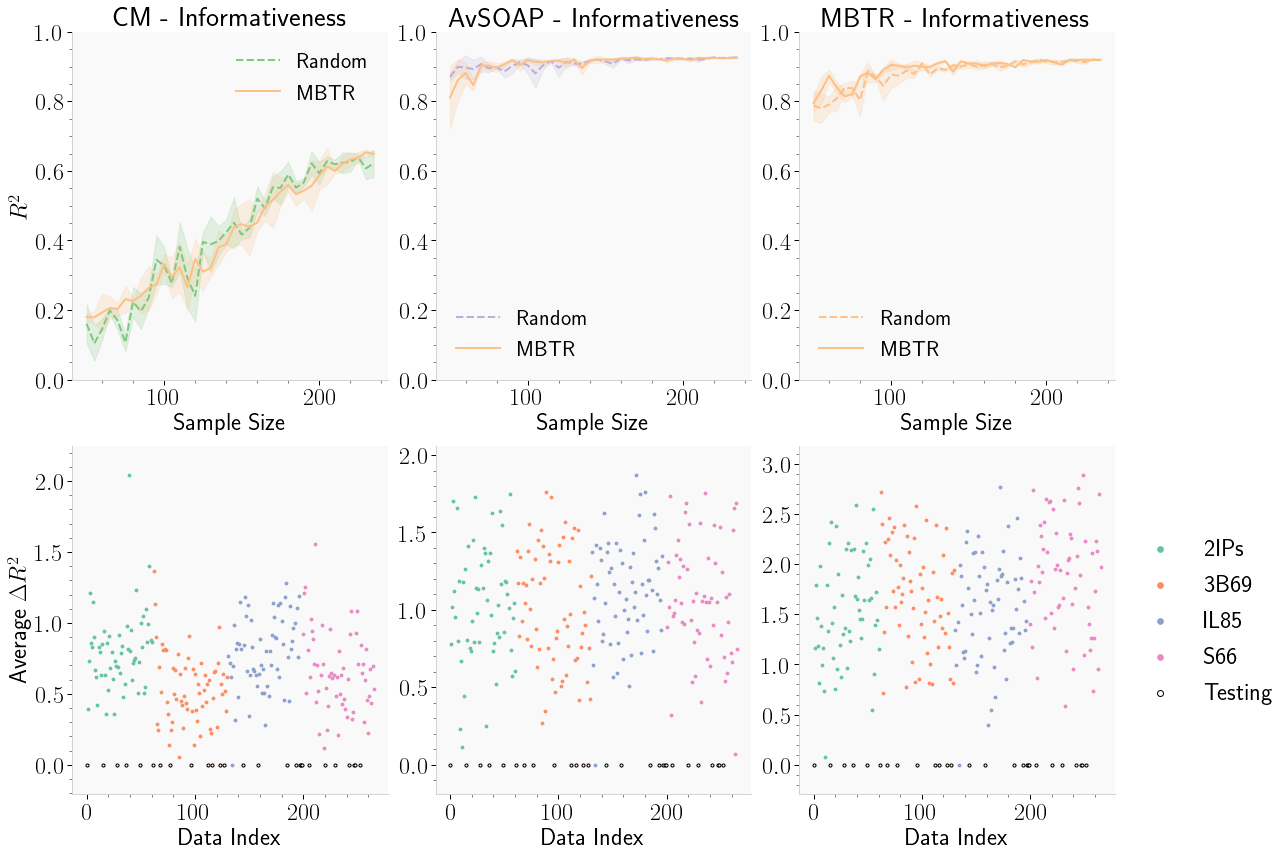

In [1097]:
fig, axes = plt.subplots(2,3,figsize=(18,12))

axs = axes[0]

# Change color of random to representation that was used for it, and then change the line type.

axs[0].set_ylabel("$R^2$", fontsize=24)

for ax, item in zip(axs, rep_colors.items()):
    rep, base_color = item
    
    vis.plot_multiple_runs(sizes, control[rep], ax=ax, label="Random", color=base_color, linestyle="--", alpha=1)
    vis.plot_multiple_runs(sizes, test[rep], ax=ax, label=rep2, color=color, alpha=alpha)
    #for rep2, color in rep_colors.items():
    #    if rep != rep2:
    #        alpha=0.5
    #    else:
    #        alpha=1.0
    #    vis.plot_multiple_runs(sizes, test[rep][rep2], ax=ax, label=rep2, color=color, alpha=alpha)
    ax.set_ylim(0.,1)
    ax.set_title(f"{rep} - Informativeness", fontsize=28)
    ax.set_xlabel("Sample Size",fontsize=24)

    ax.legend(frameon=False, fontsize=22)

axs2 = axes[1]

for ax,rep in zip(axs2,representations.keys()):
    dset_size = 266
    inform = info_dict[rep]
    
    for dset in datasets["blyp"].keys():
        idxs = df["Dataset"] == dset
        #ax.errorbar(np.arange(dset_size)[idxs], np.mean(inform,axis=0)[idxs], yerr=np.var(inform, axis=0)[idxs], linewidth=0.9, ls='none', c=dataset_colours[dset], markersize=5)
        ax.scatter(np.arange(dset_size)[idxs], inform[idxs], s=8, marker="o", color=str(dataset_colours[dset]), label=dset)
    
    ax.scatter(np.arange(dset_size)[outer_mols], np.zeros(len(outer_mols)), s=9, marker="o", color="w", edgecolor="k", label="Testing")
    #ax.set_title(f"{rep}", fontsize=28)
    if rep == "CM":
        ax.set_ylabel("Average $\Delta R^2$", fontsize=24) #(x $10^{-3}$)
    #this = ax.get_yticks()
    #ax.set_yticklabels(np.arange(-7.5,12.5,2.5))
    ax.set_xlabel("Data Index", fontsize=24)

ax.legend(frameon=False, markerscale=2, fontsize=24, loc="center left", bbox_to_anchor=[1,0.5])
        
        
plt.tight_layout()
#plt.savefig("Images/Data Valuation Validation Coarse.svg", bbox_inches="tight")
plt.show()

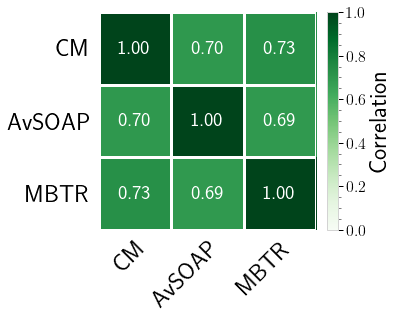

In [162]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

model_scores = [info_dict[rep] for rep in representations]

corrs = np.corrcoef(model_scores)
im = ax.imshow(corrs, cmap="Greens", vmin=0,vmax=1)
ax.set_xticks(np.arange(len(representations.keys())))
ax.set_xticklabels(labels=list(representations.keys()), rotation=45, ha="right",rotation_mode="anchor", fontsize=24)
ax.set_yticks(np.arange(len(representations.keys())))
ax.set_yticklabels(labels=list(representations.keys()), fontsize=24)
#ax.set_title("AvSOAP", fontsize=28)
ax.set_xticks(np.arange(len(representations)+1)-.5, minor=True)
ax.set_yticks(np.arange(len(representations)+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
[ax.spines[key].set_visible(False) for key in ax.spines.keys()]
ax.tick_params(which="both", left=False, bottom=False)

text = vis.annotate_heatmap(im, data=corrs, fontsize=20)

    
axins = inset_axes(ax, width = "5%", height = "100%", loc = 'lower left',
                   bbox_to_anchor = (1.05, 0., 1, 1), bbox_transform = ax.transAxes,
                   borderpad = 0)

cbar = fig.colorbar(im, cax = axins, label="Correlation")
cbar.ax.set_ylabel("Correlation", rotation=90, va="bottom", fontsize=24, labelpad=25)
cbar.ax.tick_params(labelsize=16) 

#plt.savefig("Images/Coarse_grained.svg", bbox_inches="tight")

## Model Transferability

In [154]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor,  AdaBoostRegressor
from sklearn.neural_network import MLPRegressor 
from sklearn.neighbors import KNeighborsRegressor

importlib.reload(sys.modules['chemdataval.chemdataval.intelligent_sampling_funcs'])
import chemdataval.chemdataval.intelligent_sampling_funcs as intel

T = 5000

coarse_model_results = {}
models = [RandomForestRegressor, AdaBoostRegressor, MLPRegressor, KNeighborsRegressor, KernelRidge]

skip_reps = ["CM","AvSOAP"]

for model in models:
    name = model.__name__
    print(f"Running model {name}")
    
    test_tf = intel.intelligent_sampling_over_representations(mc.test_model, info_dict, representations, Y, inner_mols, outer_mols, sizes, repeats=repeats, skip_reps=skip_reps, T=T, control=False, model=model)
    control_tf = intel.intelligent_sampling_over_representations(mc.test_model, info_dict,  representations, Y, inner_mols, outer_mols, sizes, repeats=repeats, skip_reps=skip_reps, T=T, control=True, model=model)
    
    coarse_model_results[name] = [test_tf["MBTR"], control_tf["MBTR"]]

Running model RandomForestRegressor
Running CM
Running AvSOAP


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.56it/s]


Running MBTR
Running CM
Running AvSOAP


100%|███████████████████████████████████████████| 38/38 [00:10<00:00,  3.58it/s]


Running MBTR
Running model AdaBoostRegressor
Running CM
Running AvSOAP


100%|███████████████████████████████████████████| 38/38 [00:04<00:00,  8.39it/s]


Running MBTR
Running CM
Running AvSOAP


100%|███████████████████████████████████████████| 38/38 [00:04<00:00,  8.60it/s]


Running MBTR
Running model MLPRegressor
Running CM
Running AvSOAP


100%|███████████████████████████████████████████| 38/38 [00:12<00:00,  3.08it/s]


Running MBTR
Running CM
Running AvSOAP


100%|███████████████████████████████████████████| 38/38 [00:12<00:00,  2.93it/s]


Running MBTR
Running model KNeighborsRegressor
Running CM
Running AvSOAP


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 232.18it/s]


Running MBTR
Running CM
Running AvSOAP


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 283.73it/s]


Running MBTR
Running model KernelRidge
Running CM
Running AvSOAP


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 137.45it/s]


Running MBTR
Running CM
Running AvSOAP


100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 185.13it/s]

Running MBTR


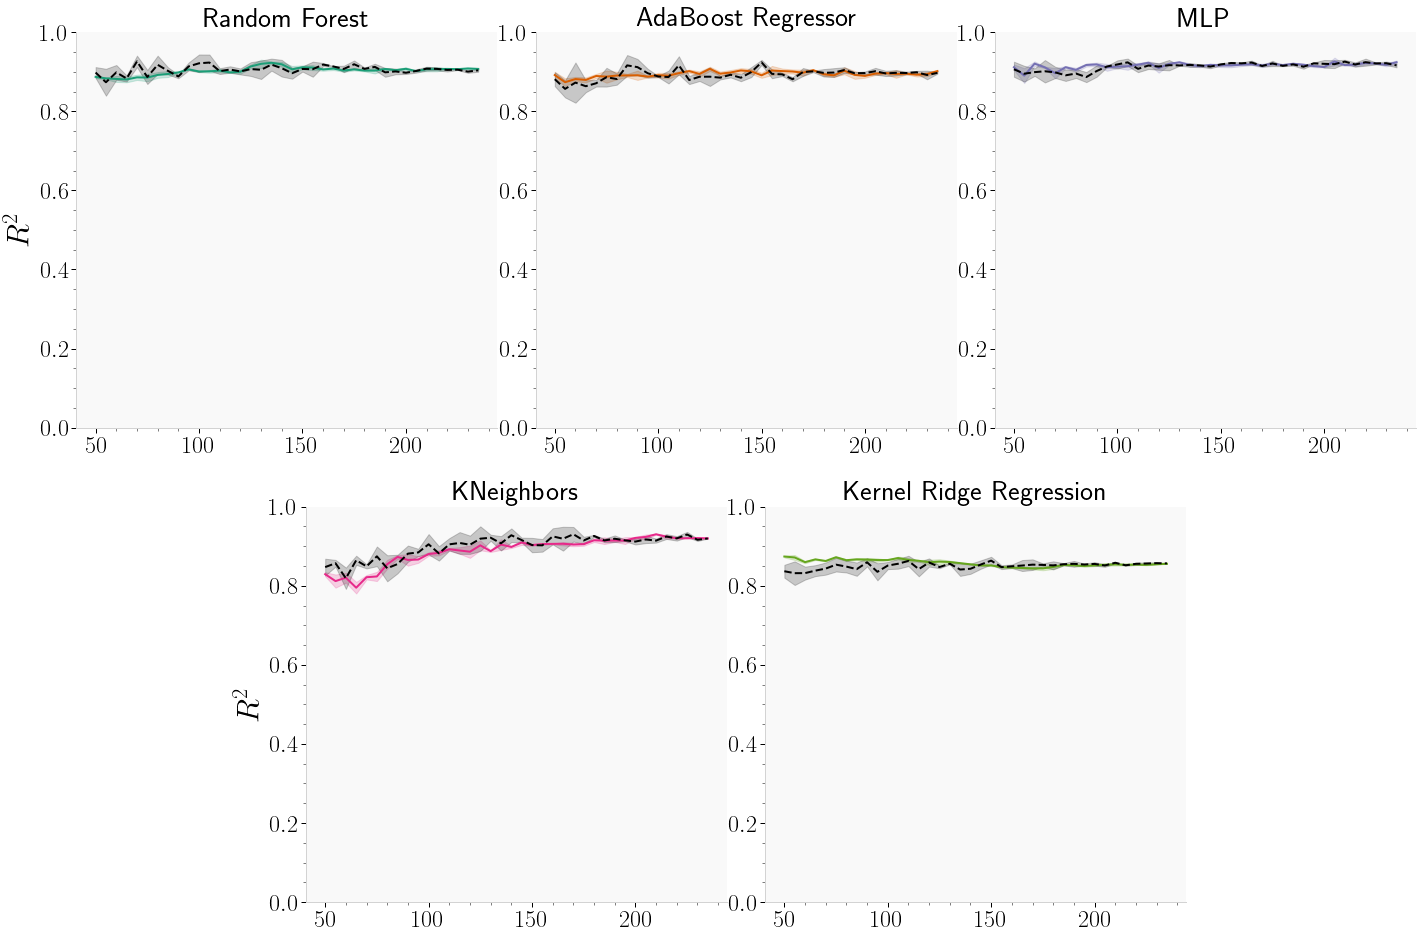

In [157]:
fig, axs = vis.fivefigs(shareaxes=True,yaxis_label=f"$R^2$")

model_names = {x : y for x, y in zip(coarse_model_results.keys(), ["Random Forest", "AdaBoost Regressor", "MLP", "KNeighbors", "Kernel Ridge Regression"])}
cols = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']

for i, (ax, model) in enumerate(zip(axs, coarse_model_results.keys())):
    vis.plot_multiple_runs(sizes, coarse_model_results[model][0], ax=ax, label=f"{model_names[model]} - Informative", color=cols[i])
    vis.plot_multiple_runs(sizes, coarse_model_results[model][1], ax=ax, label=f"{model_names[model]} - Random", color="black", linestyle="--")
    ax.set_title(model_names[model], fontsize=28)
    if i in [0,3]:
        ax.set_ylim(0,1)
    
#plt.savefig("Images/Data_Valuation_Models.pdf", bbox_inches="tight")
plt.show()


# Different Datasets

In [491]:
import rdkit.Chem as Chem
import mhfp
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import Descriptors

def fold(hash_values, length=2048):
        """Folds the hash values to a binary vector of a given length.
    Arguments:
      hash_value {numpy.ndarray} -- An array containing the hash values.
      length {int} -- The length of the folded fingerprint (default: {2048})
    
    Returns:
      numpy.ndarray -- The folded fingerprint.
    """

        folded = np.zeros(length, dtype=np.uint8)
        folded[hash_values % length] = 1

        return folded

def parse_fingerprints(smiles,encoder,return_idxs=True,debug=False):
    """
    Function that parses the fingerprints of all SMILES in a particular pandas dataframe. This is written 
    as a separate function because in many of the dataframes there are SMILES strings which cannot be 
    processed by RDKit. This function removes them from the pool and returns a debug list telling the user
    which smiles failed and why.
    
    Parameters
    ----------
    smiles : iter
        An iterable of smiles to be converted.
        
    encoder : func
        An encoder function that converts the SMILES string into a particular fingerprint.
        
    return_idxs : bool, default=True
        Whether or not to return the indices associated with the SMILES that succeeded.
        
    debug : bool, default=False
        Whether or not to return the debug list.
    """
    fps = []
    fps_idxs = []
    failed = []
    for idx,mol in enumerate(smiles):
        try: 
            mol = Chem.MolFromSmiles(mol)
            fps.append(encoder(mol))
            if return_idxs:
                fps_idxs.append(idx)
                
        except Exception as e: 
            print(f"{idx} failed")
            if debug:
                failed.append(f"{idx} failed: {e}")
        
    if return_idxs and debug:
        return fps, fps_idxs, failed
    elif return_idxs:
        return fps, fps_idxs
    elif debug:
        return fps, failed
    else:
        return fps
    
props = ['CalcTPSA',
         'CalcLabuteASA',
         'CalcExactMolWt',
         'CalcNumAliphaticCarbocycles',
         'CalcNumAliphaticHeterocycles',
         'CalcNumAliphaticRings',
         'CalcNumAmideBonds',
         'CalcNumAromaticCarbocycles',
         'CalcNumAromaticHeterocycles',
         'CalcNumAromaticRings',
         'CalcNumAtomStereoCenters',
         'CalcNumBridgeheadAtoms',
         'CalcNumHBA',
         'CalcNumHBD',
         'CalcNumHeteroatoms',
         'CalcNumHeterocycles',
         'CalcNumLipinskiHBA',
         'CalcNumLipinskiHBD',
         'CalcNumRings',
         'CalcNumRotatableBonds',
         'CalcNumSaturatedCarbocycles',
         'CalcNumSaturatedHeterocycles',
         'CalcNumSaturatedRings',
         'CalcNumSpiroAtoms',
         'CalcNumUnspecifiedAtomStereoCenters']

def calc_vector(x,props=props):
    """
    Calculates the property vector using the available RDKit descriptors.
    
    Parameters 
    ----------
    x : str
        The SMILES to have its vector representation calculated.
        
    props : [str], default=props 
        The list of descriptor functions to calculate for the molecule of interest.
        
    Returns 
    -------
    y : np.array(len(props),)
        A numpy array the length of the property list.
    """
    if isinstance(x,str):
        x = Chem.MolFromSmiles(x)
    y = np.zeros((len(props),))
    for i in range(len(y)):
        y[i] = getattr(Descriptors.rdMolDescriptors, props[i])(x)
    return y 

def sanitise(scores):
    """
    Turns negative elements into zero values.
    """
    scores = utils.ensure_array(scores)
    scores[np.where(scores < 0)] = 0
    return scores


In [106]:
esol = pd.read_csv("Datasets/ESOL.csv")
free = pd.read_csv("Datasets/FreeSolv.csv")
harv = pd.read_csv("Datasets/Harvard_Organic_Photovoltaic_cleaned.csv")

[array([202.320, 182.935, 457.158, 0.000, 2.000, 2.000, 0.000, 1.000,
        0.000, 1.000, 11.000, 0.000, 12.000, 7.000, 12.000, 2.000, 12.000,
        7.000, 3.000, 7.000, 0.000, 2.000, 2.000, 0.000, 11.000]),
 array([42.240, 87.724, 201.079, 0.000, 0.000, 0.000, 1.000, 1.000, 1.000,
        2.000, 0.000, 0.000, 2.000, 1.000, 3.000, 1.000, 3.000, 1.000,
        2.000, 2.000, 0.000, 0.000, 0.000, 0.000, 0.000]),
 array([17.070, 68.806, 152.120, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        0.000, 0.000, 0.000, 1.000, 0.000, 1.000, 0.000, 1.000, 0.000,
        0.000, 4.000, 0.000, 0.000, 0.000, 0.000, 0.000]),
 array([0.000, 128.158, 278.110, 0.000, 0.000, 0.000, 0.000, 5.000, 0.000,
        5.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000,
        5.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]),
 array([0.000, 35.072, 84.003, 0.000, 0.000, 0.000, 0.000, 0.000, 1.000,
        1.000, 0.000, 0.000, 1.000, 0.000, 1.000, 1.000, 0.000, 0.000,
        1.000, 0.000, 0.000, 

In [649]:
extra_dsets = {"ESOL" : esol,
               "FreeSolv" : free}
extra_prop_names = {"ESOL" : "ESOL predicted log solubility in mols per litre",
                    "FreeSolv" : "expt"}

extra_inners = {}
extra_outers = {}
extra_reps = {}
extra_props = {}

for dset in extra_dsets:
    extra_inners[dset] = np.random.choice(np.arange(len(extra_dsets[dset])), replace=False, size=int(0.8*len(extra_dsets[dset])))
    extra_outers[dset] = np.setdiff1d(np.arange(len(extra_dsets[dset])), extra_inners[dset])
        
    X, Y = pre.standardise(np.array(list(map(calc_vector, extra_dsets[dset]["SMILES"]))), 
                           extra_dsets[dset][extra_prop_names[dset]].to_numpy(),
                           extra_inners[dset])
    
    extra_reps[dset] = X
    extra_props[dset] = Y


In [658]:
extra_results = {}

for dset in extra_dsets:
    print(f"Working on {dset}")
    X = np.array(extra_reps[dset])
    Y = extra_props[dset]

    idxs, scores = mc.test_inner_folds(
        mc.test_model,
        kf=kf,
        X=X,
        Y=Y,
        seed_size=20,
        inner_idxs=extra_inners[dset],
        outer_idxs=extra_outers[dset],
        groups=np.zeros(len(extra_dsets[dset])),
        queries=130,
        random_runs=25,
        model=GaussianProcessRegressor,
        kernel=kernel)

    scores = sanitise(scores)

    extra_results[dset] = [idxs, scores]

Working on ESOL
Running fold 1


100%|███████████████████████████████████████████| 25/25 [01:19<00:00,  3.18s/it]


Running fold 2


100%|███████████████████████████████████████████| 25/25 [01:20<00:00,  3.23s/it]


Running fold 3


100%|███████████████████████████████████████████| 25/25 [01:20<00:00,  3.24s/it]


Running fold 4


100%|███████████████████████████████████████████| 25/25 [01:09<00:00,  2.80s/it]


Running fold 5


100%|███████████████████████████████████████████| 25/25 [01:11<00:00,  2.85s/it]


Working on FreeSolv
Running fold 1


100%|███████████████████████████████████████████| 25/25 [00:52<00:00,  2.10s/it]


Running fold 2


100%|███████████████████████████████████████████| 25/25 [00:53<00:00,  2.16s/it]


Running fold 3


100%|███████████████████████████████████████████| 25/25 [00:57<00:00,  2.29s/it]


Running fold 4


100%|███████████████████████████████████████████| 25/25 [00:53<00:00,  2.16s/it]


Running fold 5


100%|███████████████████████████████████████████| 25/25 [00:54<00:00,  2.16s/it]


In [659]:
extra_informs = {dset : inform_funcs.informativeness_scoring(*extra_results[dset], dset_size=len(extra_inners[dset]) + len(extra_outers[dset]), subset_idxs=None, seed_size=20).mean(axis=0) for dset in extra_dsets}

In [660]:
import chemdataval.chemdataval.monte_carlo as mc
importlib.reload(sys.modules['chemdataval.chemdataval.monte_carlo'])
import chemdataval.chemdataval.monte_carlo as mc

import chemdataval.chemdataval.utils as utils
importlib.reload(sys.modules['chemdataval.chemdataval.utils'])
import chemdataval.chemdataval.utils as utils

import chemdataval.chemdataval.informativeness as inform_funcs
importlib.reload(sys.modules['chemdataval.chemdataval.informativeness'])
import chemdataval.chemdataval.informativeness as inform_funcs

import chemdataval.chemdataval.intelligent_sampling_funcs as intel
importlib.reload(sys.modules['chemdataval.chemdataval.intelligent_sampling_funcs'])
import chemdataval.chemdataval.intelligent_sampling_funcs as intel


extra_intelligent_runs = {}
extra_sizes = {"ESOL" : range(30,900,20), 
               "FreeSolv" : range(30,500,20)}
repeats = 10

for dset in extra_dsets.keys():
    extra_intelligent_runs[dset] = [intel.intelligent_sampling(mc.test_model,
                               extra_inform,
                               extra_reps[dset],
                               extra_props[dset],
                               extra_inners[dset],
                               extra_outers[dset],
                               extra_sizes[dset],
                               repeats=repeats,
                               model=GaussianProcessRegressor,
                               kernel=kernel),
                     intel.intelligent_sampling(mc.test_model,
                               extra_inform,
                               extra_reps[dset],
                               extra_props[dset],
                               extra_inners[dset],
                               extra_outers[dset],
                               extra_sizes[dset],
                               repeats=repeats,
                               model=GaussianProcessRegressor,
                               control=True,
                               kernel=kernel)]

100%|███████████████████████████████████████████| 24/24 [00:19<00:00,  1.22it/s]


In [680]:
extra_cols = ['#e41a1c','#377eb8','#4daf4a']

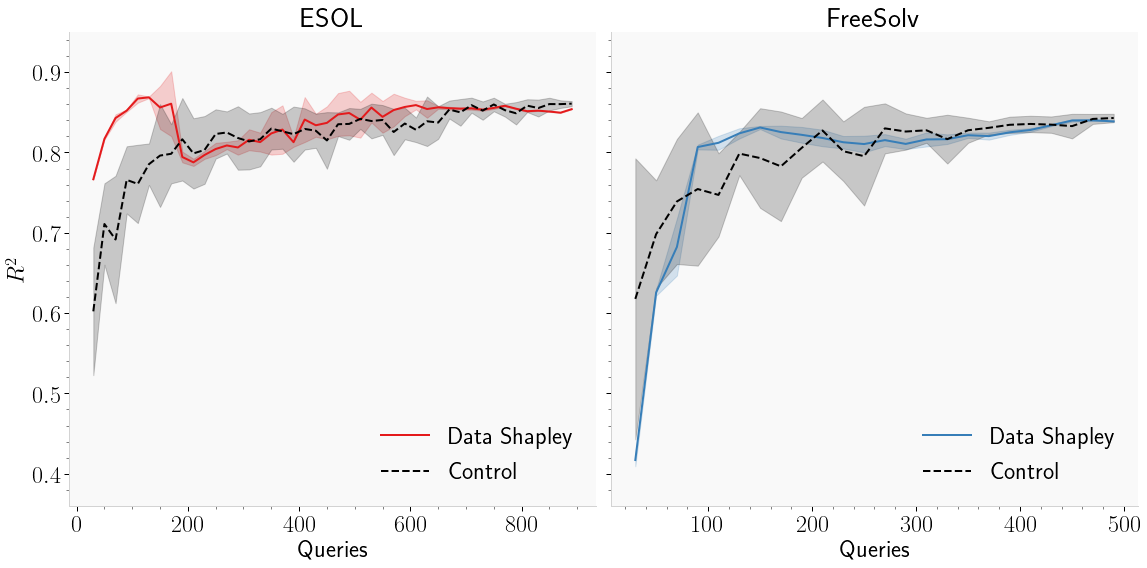

In [704]:
fig, axs = plt.subplots(1,2,figsize=(16,8), sharey=True)
i = 0 

for ax, (dset, intelligent_results) in zip(axs, extra_intelligent_runs.items()):
    vis.plot_multiple_runs(extra_sizes[dset], intelligent_results[0],ax=ax,color=extra_cols[i], label="Data Shapley")
    vis.plot_multiple_runs(extra_sizes[dset], intelligent_results[1],ax=ax,color="k", linestyle="--", label="Control") 
    i += 1
    ax.legend(frameon=False, fontsize=24, loc="lower right")
    ax.set_xlabel("Queries", fontsize=24)
    ax.set_title(dset, fontsize=28)
    if i == 1:
        ax.set_ylabel("$R^2$", fontsize=24)
    
plt.tight_layout()
plt.savefig("Images/Extra_Datasets_Data_Valuation.pdf", bbox_inches="tight")
plt.savefig("Images/Extra_Datasets_Data_Valuation.svg", bbox_inches="tight")


In [384]:
gpr = GaussianProcessRegressor(kernel=kernel)
vecs = list(map(calc_vector, esol["SMILES"]))

In [387]:
test_run = []
for size in range(50,900,10):
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(vecs[:size], esol["ESOL predicted log solubility in mols per litre"].iloc[:size])
    test_run.append(gpr.score(vecs[size:], esol["ESOL predicted log solubility in mols per litre"].iloc[size:]))

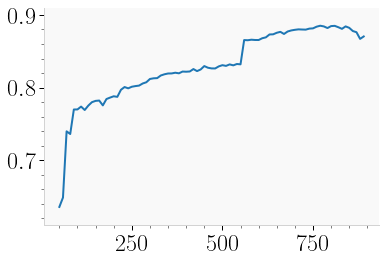

In [389]:
plt.plot(range(50,900,10), test_run)

# Selecting Number of Points by Informativeness

What I mean by this, is let's say you have done all of this testing and now want to compute the energies with CCSD(T). You know which are the best points, but how many of them do you need? The informativeness of the points should provide an indication of how many you should be using.

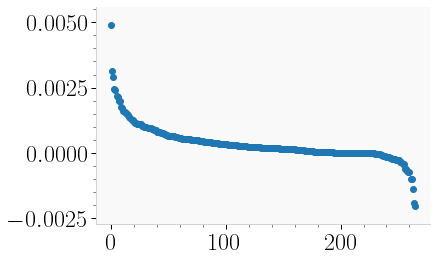

In [ ]:
plt.scatter(range(266), np.sort(np.mean(inform, axis=0))[::-1])

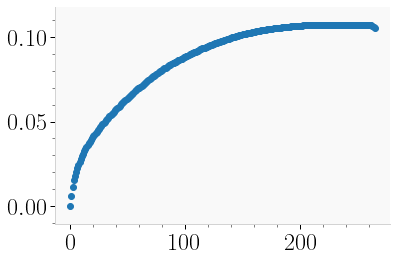

In [1089]:
plt.scatter(range(266), [np.sum(np.sort(np.mean(inform, axis=0))[::-1][:x]) for x in range(266)])

# QM9 Data Valuation

In [1366]:
import urllib.request 
import os 
import tarfile
import tqdm
import pandas as pd
import numpy as np
import glob

directory = "QM9/"
filename = "QM9_Data.tar.bz2"
url = 'https://ndownloader.figshare.com/files/3195389'

def download_QM9(directory="QM9/",filename="QM9_Data",url='https://ndownloader.figshare.com/files/3195389',delete_xyz='True'):
    """
    Helper function to download and process QM9 into csv file.
    
    Parameters 
    ----------
    directory : str, default="QM9"
        The directory in which the files will be stored
        
    filename : str, default=QM9_Data
        The filename that the final file will be saved in
        
    url : str, default='https://ndownloader.figshare.com/files/3195389'
        The url from which the file will be downloaded 
        
    delete_xyz : bool, default=True 
        Whether or not the xyz files will be deleted after processing the data.
    """

    print("Downloading QM9 from figshare")
    urllib.request.urlretrieve(url, filename+".tar.bz2")

    try:
        os.mkdir(directory)
    except:
        pass

    def extract_bz2(filename, path="."):
        with tarfile.open(filename, "r:bz2") as tar:
            tar.extractall(path)

    print("Extracting archive")
    extract_bz2(filename+'.tar.bz2',path=directory)

    files = sorted(glob.glob(directory+"*.xyz"))

    props = ["SMILES","Rotational Constant A", "Rotational Constant B", "Rotational Constant C","Dipole Moment"
             ,"Isotropic Polarizability","Energy of HOMO","Energy of LUMO","HOMO-LUMO Gap","Electronic Spatial Extent","ZPVE",
             "Internal Energy at 0K","Internal Energy at 298.15K","Enthalpy at 298.15K","Free Energy at 298.15K","Heat Capacity at 298.15K"]

    print("Building dataframe")

    QM9_data = pd.DataFrame(columns=props, index=np.arange(1,133885))

    for i,file in enumerate(tqdm.tqdm(files)):
        with open(file,"r") as f:
            lines = f.readlines()
            smiles = lines[-2].split("\t")[0]
            props = lines[1]
            vals = [smiles] + props.split("\t")[1:-1]
            QM9_data.loc[i+1] = vals

    QM9_data.to_csv(directory+filename+".csv")

    print("Cleaning archive")
    os.remove(filename+".tar.bz2")
    if delete_xyz:
        for file in tqdm.tqdm(os.listdir(directory)):
            if file.endswith('.xyz'):
                os.remove(directory+file)
    print(f"Process finished - Completed csv available at {directory+filename}.csv")
    return QM9_data

def clean_QM9(df,drops=[]):
    """
    Cleans QM9 by removing columns provided by the drops argument
    """
    new_df = df.drop(labels=drops,axis=1)
    return new_df

qm9 = download_QM9(delete_xyz=False)
new = clean_QM9(qm9,drops=["Rotational Constant A","Rotational Constant B","Rotational Constant C",'ZPVE', 'Internal Energy at 0K','Internal Energy at 298.15K', 'Enthalpy at 298.15K','Free Energy at 298.15K', 'Heat Capacity at 298.15K'])

Extracting archive
Building dataframe


100%|██████████████████████████████████████████████████████████| 133885/133885 [00:10<00:00, 13108.03it/s]


Cleaning archive
Process finished - Completed csv available at QM9/QM9_Data.csv


In [1367]:
if not os.path.exists("Representations"):
    os.mkdir("Representations")

# QM9_setup 

species = ["H", "C", "O", "N","F"]
rcut = 6.0
nmax = 8
lmax = 6

# Setting up the SOAP descriptor
qm9_soap = SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
)

qm9_average_soap = SOAP(
    species=species,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
    average="inner",
    sparse=False
)

# Setting up the CM descriptor
qm9_cm = CoulombMatrix(
    n_atoms_max=29,
)

# Setting up the MBTR descriptor
qm9_mbtr = MBTR(
    species=species,
    k1={
        "geometry": {"function": "atomic_number"},
        "grid": {"min": 0, "max": 9, "n": 100, "sigma": 0.1},
    },
    k2={
        "geometry": {"function": "inverse_distance"},
        "grid": {"min": 0, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    k3={
        "geometry": {"function": "cosine"},
        "grid": {"min": -1, "max": 1, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
    },
    periodic=False,
    normalization="l2_each",
)

In [1368]:
qm9 = pd.read_csv("Datasets/qm9.csv")
qm9_mols = [f"QM9/QM9/dsgdb9nsd_{str(x+1).zfill(6)}.xyz" for x in tqdm.tqdm(qm9.index)]
qm9_mols_read = [read(xyz) for xyz in tqdm.tqdm(qm9_mols,position=0, leave=True)]

100%|███████████████████████████████████████████████████████████| 133885/133885 [01:12<00:00, 1848.13it/s]


In [1369]:
from sklearn.preprocessing import normalize

# Coulomb Matrix
if os.path.exists("Representations/qm9_cm_mols.npy"):
    qm9_cm_mols = np.load("Representations/qm9_cm_mols.npy")
else:
    qm9_cm_mols = np.array([qm9_cm.create(mol) for mol in tqdm.tqdm(qm9_mols_read,position=0, leave=True)])
    qm9_cm_mols = normalize(qm9_cm_mols)
    np.save("Representations/qm9_cm_mols.npy",qm9_cm_mols)

# Average SOAP
if os.path.exists("Representations/qm9_avsoap_mols.npy"):
    qm9_avsoap_mols = np.load("Representations/qm9_avsoap_mols.npy")
else:
    qm9_soap_mols = np.array([qm9_soap.create(mol) for mol in tqdm.tqdm(qm9_mols_read,position=0, leave=True)])
    qm9_avsoap_mols = np.array([qm9_average_soap.create(mol) for mol in tqdm.tqdm(qm9_mols_read,position=0, leave=True)])
    qm9_avsoap_mols = normalize(qm9_avsoap_mols)
    np.save("Representations/qm9_avsoap_mols.npy",qm9_avsoap_mols)

# Many Body Tensor Representations
if os.path.exists("Representations/qm9_mbtr_mols.npy"):
    qm9_mbtr_mols = np.load("Representations/qm9_mbtr_mols.npy")
else:
    qm9_mbtr_mols = np.array([qm9_mbtr.create(mol) for mol in tqdm.tqdm(qm9_mols_read,position=0,leave=True)])
    qm9_mbtr_mols = normalize(qm9_mbtr_mols)
    np.save("Representations/qm9_mbtr_mols.npy",qm9_mbtr_mols)

# Indentifying Noisy Data

In [2159]:
μ = df["dINT_BLYP_ref_cp"].to_numpy().mean() * 4
σ = np.sqrt(df["dINT_BLYP_ref_cp"].to_numpy().var())

In [2160]:
cov = np.zeros((30,30))
np.fill_diagonal(cov, 2*σ)
np.random.multivariate_normal(mean=μ*np.ones((30,)), cov=cov)

array([-439.063, -429.662, -431.135, -439.408, -444.571, -442.603,
       -435.850, -459.060, -433.628, -441.518, -429.681, -441.079,
       -439.886, -442.672, -427.421, -430.716, -455.058, -458.221,
       -419.858, -440.463, -407.651, -429.155, -440.948, -441.694,
       -442.783, -445.349, -429.479, -433.453, -445.646, -449.781])

In [2161]:
#noise_idxs = np.random.choice(range(266), size=(133,), replace=False)
noise_idxs = np.array([ 34, 136, 140, 217,  64, 184,   8,  95, 116, 240, 197, 179, 111,
        85, 210, 202, 165, 261, 164, 157, 173, 247, 113,  39, 117, 170,
       216,  63,  98,  17, 109,  78, 189, 171,  72,   3, 141, 155, 154,
       108,  46, 152,  10, 221, 198, 206,  15, 182, 238, 167, 235, 246,
       110, 139, 166,  58, 237,  86, 209,  70,  23, 256, 147, 188, 126,
       127, 159, 103,  26,  41, 218, 123,  28,  43, 212, 175,  84, 207,
        12, 162,  32,  19, 125,   0, 158,  87, 252, 180, 138,  21, 186,
        44, 199,  49,  62,  77,  45, 243, 203,  27,  75,   4, 200, 174,
       112, 205, 133,  22, 100,  35, 265,  90, 148,  68, 172,  51,  79,
        29,  50, 242, 194, 262,  47, 263, 185, 142,  74, 181,   9,  60,
       118, 234,  82])[:30]

In [2117]:
noise_vec = np.array([-439.063, -429.662, -431.135, -439.408, -444.571, -442.603,
       -435.850, -459.060, -433.628, -441.518, -429.681, -441.079,
       -439.886, -442.672, -427.421, -430.716, -455.058, -458.221,
       -419.858, -440.463, -407.651, -429.155, -440.948, -441.694,
       -442.783, -445.349, -429.479, -433.453, -445.646, -449.781])

array([1.126, -0.771, 1.330, ..., 0.430, -0.917, 0.063])

KeyboardInterrupt: 

In [2201]:
X̂, Ŷ = preprocess(cm_mols, noise_Y, train_index)
X̂[noise_idxs] += X_noise

In [2132]:
def sampling_run(X, Y, train_index, test_index, seed, seed_size=50, queries=None, model_type=RandomForestRegressor, **model_parameters):
    """
    Beginning with an initial seed, randomly builds the dataset up training and returning the indices and performances for each point.
    """
    np.random.seed(seed)
    
    seed = list(np.random.choice(train_index, size=seed_size, replace=False))
    pool = list(np.setdiff1d(train_index, seed))
    
    model = model_type(**model_parameters)
    model.fit(X[seed], Y[seed])
    scores = [model.score(X[test_index], Y[test_index])]
    
    if queries is None:
        queries = len(train_index) - seed_size
    
    for query in range(queries):
        choice = int(np.random.choice(range(len(pool)), size=(1,)))
        seed.append(pool[choice])
        
        # Delete the item from pool
        del pool[choice]
                     
        model = model_type(n_estimators=10,**model_parameters)
        model.fit(X[seed], Y[seed])
    
        scores.append(model.score(X[test_index], Y[test_index]))
    return seed, scores

In [2224]:
X = standardise(np.copy(cm_mols))
for idx in noise_idxs:
    X[idx] += np.random.randn(10816,)
    


In [2232]:
from functools import partial

noise_kf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=state)
fold_runs = 25

noise_results = [[] for x in range(n_splits)]

for idx,fold in enumerate(noise_kf.split(X,df["Categorical"])):
    # Splitting it into training and testing indices
    train_index, test_index = fold
    
    X̂, Ŷ = preprocess(X, df["dINT_BLYP_ref_cp"].to_numpy(), train_index)
    
    for i in tqdm.tqdm(range(fold_runs)):
        noise_results[idx].append(sampling_run(X̂, Ŷ.reshape(-1), train_index, test_index, i, n_jobs=1))


100%|████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:16<00:00,  3.04s/it]


In [2233]:
def process_results(results, seed_size=100, num_mols=266):
    informativeness = np.zeros((len(results), num_mols))
    
    for idx,result in enumerate(results):
        vals = np.diff(result[1])
        informativeness[idx,result[0][seed_size:]] = vals
        
    return informativeness

noise_informative = np.vstack([process_results(noise_results[i], seed_size=50) for i in range(5)])


In [2194]:
np.setdiff1d(range(266), noise_idxs)

array([  0,   1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13,
        14,  15,  16,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  35,  36,  37,  38,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  86,  87,  88,  89,  90,  91,  92,  93,  94,  96,  97,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 114,
       115, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 137, 138, 139, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158,
       159, 160, 161, 162, 163, 166, 167, 168, 169, 171, 172, 174, 175,
       176, 177, 178, 180, 181, 182, 183, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 203, 20

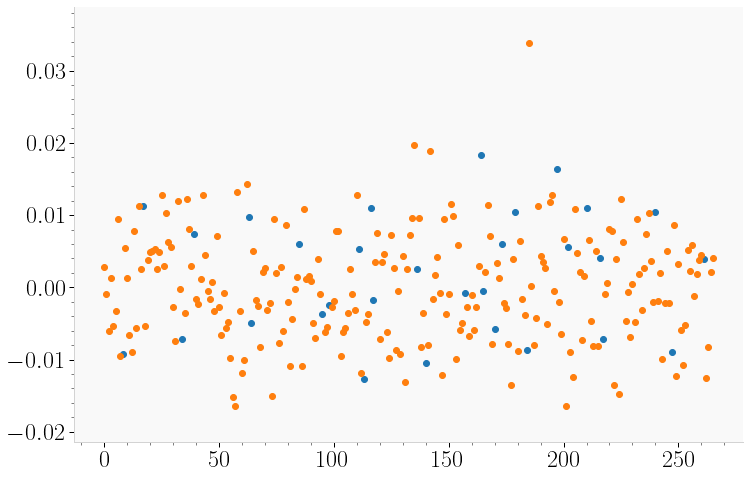

In [2234]:
inform = np.ma.masked_equal(noise_informative, 0)
fig, ax = plt.subplots(1,1,figsize=(12,8))

ax.scatter(noise_idxs, inform.mean(axis=0)[noise_idxs])
ax.scatter(np.setdiff1d(range(266), noise_idxs), inform.mean(axis=0)[np.setdiff1d(range(266), noise_idxs)])

In [2199]:
np.intersect1d(kmin(inform.mean(axis=0), 133, indices=True), noise_idxs)

masked_array(data=[  8,  39,  64,  95,  98, 136, 140, 157, 165, 170, 173,
                   184, 197, 202, 210, 216, 240, 247, 261],
             mask=False,
       fill_value=999999)

masked_array(data=[  0,   9,  22,  28,  32,  34,  44,  47,  49,  60,  62,
                    74,  75,  77,  79,  84,  87,  95,  98, 100, 112, 125,
                   126, 133, 140, 141, 147, 152, 157, 162, 165, 170, 173,
                   174, 175, 179, 180, 181, 182, 185, 189, 198, 203, 205,
                   206, 207, 212, 217, 235, 237, 238, 240, 242, 246, 247,
                   252, 262, 265],
             mask=False,
       fill_value=999999)

# Constructing animations

In [ ]:
small_cm = PCA(n_components=2).fit_transform(cm_mols)

for i in range(144):
    small_cm += np.random.standard_normal(small_cm.shape) * 1
    plt.ylim(-275,300)
    plt.xlim(-300,450)
    plt.scatter(small_cm[:,0], small_cm[:,1], edgecolor="k", s=20)
    plt.savefig(f"Images/test-{i}.png")
    plt.close()

# Example Visualisation

In [2237]:
X = np.random.randn(10,2)

## Data Shapley Fundamentals

<font size="4"> Given a particular performance metric, $P$ (such as $R^2$ or $RMSD$, the contribution of a particular datapoint, $x_i$ for a given coalition is:

<font size="4"> Contribution = $P(\text{Coalition} \cup x_i) - P(\text{Coalition})$

<font size="4"> Averaged over **all possible coalitions**

<font size="4"> For a dataset of 10 molecules, each coalition is defined by a binary vector with a 1 indicating that the molecule is in, and a 0 indicating it is not. 

<font size="4"> This means that there is $2^{10}$ coalitions, or more generally, $2^N$ coalitions when there are $N$ datapoints

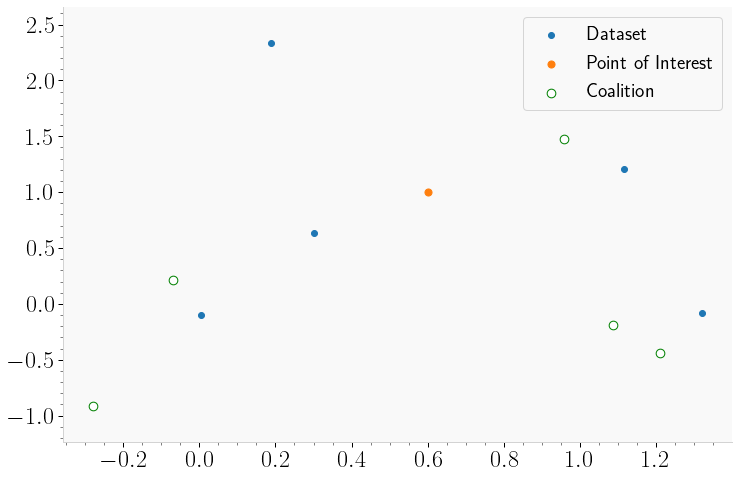

In [2257]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

ax.scatter(*X.T, label="Dataset")
ax.scatter(0.6,1.0,label="Point of Interest", s=50)

coalition = np.random.choice(range(10), size=(5,), replace=False)

ax.scatter(*X[coalition].T, label="Coalition", color="w", edgecolor="green", s=75)

plt.legend(fontsize=20)
plt.show()

## Monte Carlo Data Shapley

<font size="4">  $2^M$ is clearly impractical in all but the simplest cases, so we need an approximate way to compute it. To do this we can use Monte Carlo sampling.

<font size="4"> Integrating this into an active learning framework is quite simple. Active learning runs are essentially a series of steps with each adding a single new molecule to the dataset. So, considering two steps, $S$ and $S+1$, the only difference is the addition of a single molecule, which we'll refer to as $x$. </font>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


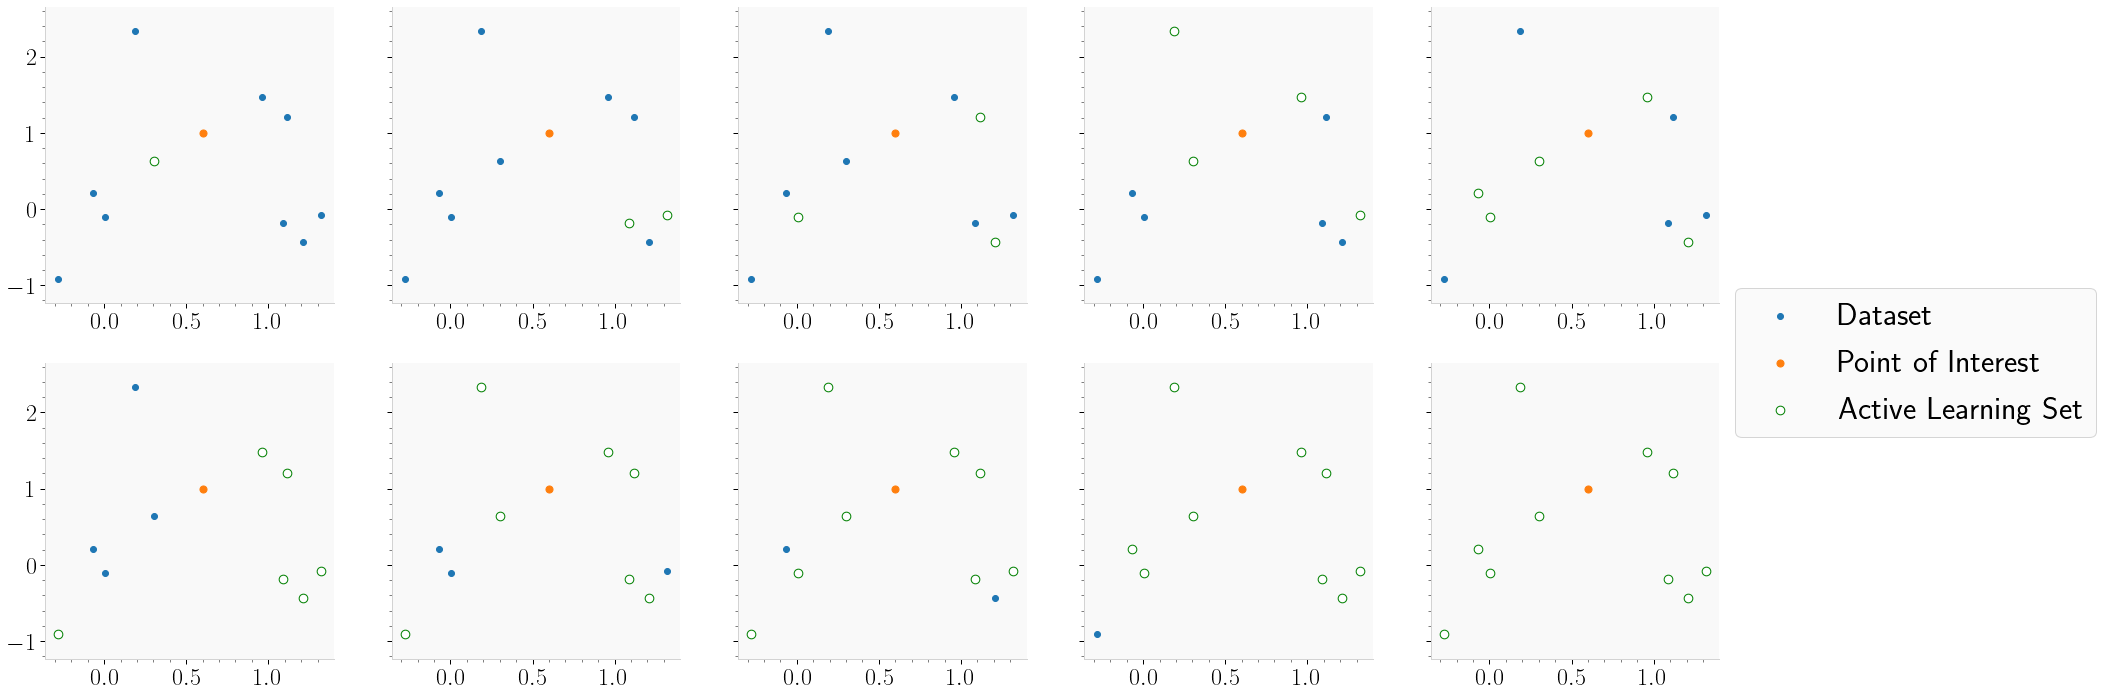

In [2335]:
cols, rows = 5,2 

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height), sharey=True)
coords = np.arange(rows * cols).reshape(rows,cols)

for idx in range(1,11):
    x,y = np.where(coords == idx-1)
    ax = axs[x[0],y[0]]

    ax.scatter(*X.T, label="Dataset")
    ax.scatter(0.6,1.0,label="Point of Interest", s=50)

    coalition = np.random.choice(range(10), size=(idx,), replace=False)

    ax.scatter(*X[coalition].T, label="Active Learning Set", color="w", edgecolor="green", s=75)

plt.legend(fontsize=32, loc="center left", bbox_to_anchor=(1,1))
plt.show()

<font size="4">  By taking the difference in performance between $S+1$ and $S$, we get the contribution of $x$ to the coalition at $S$, which is precisely equivalent a single value for the Data Shapley value. </font>

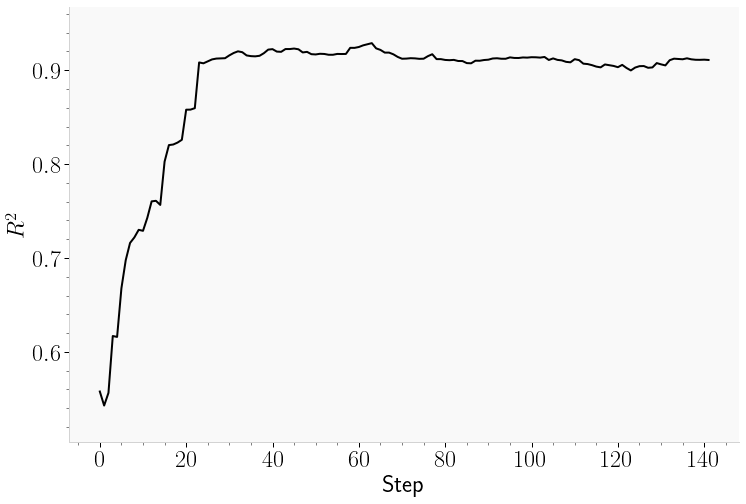

In [2312]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

plt.plot(range(len(kf_results["CM"]["Fold 1"]["Uncertainty"]["scores"][0])), kf_results["CM"]["Fold 1"]["Uncertainty"]["scores"][0], color="k")
ax.set_ylabel("$R^2$", fontsize=24)
ax.set_xlabel("Step", fontsize=24)
plt.show()

<font size="4">  So the differences for this one are just $[S_1 - S, S_2 - S_1, S_3 - S_2,...]$ </font>

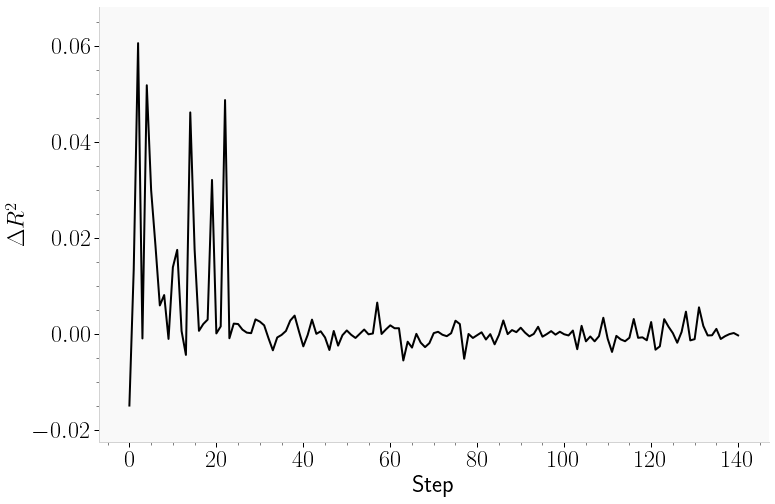

In [2310]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

plt.plot(range(len(kf_results["CM"]["Fold 1"]["Uncertainty"]["scores"][0])-1), np.diff(kf_results["CM"]["Fold 1"]["Uncertainty"]["scores"][0]), color="k")
ax.set_ylabel("$\Delta R^2$", fontsize=24)
ax.set_xlabel("Step", fontsize=24)
plt.show()

<font size="4">  By matching these contributions to the index of the molecule that was added at that point

In [2313]:
contributions = np.zeros((266,))
contributions[kf_results["CM"]["Fold 1"]["Uncertainty"]["idxs"][0][50:]] += np.diff(kf_results["CM"]["Fold 1"]["Uncertainty"]["scores"][0])

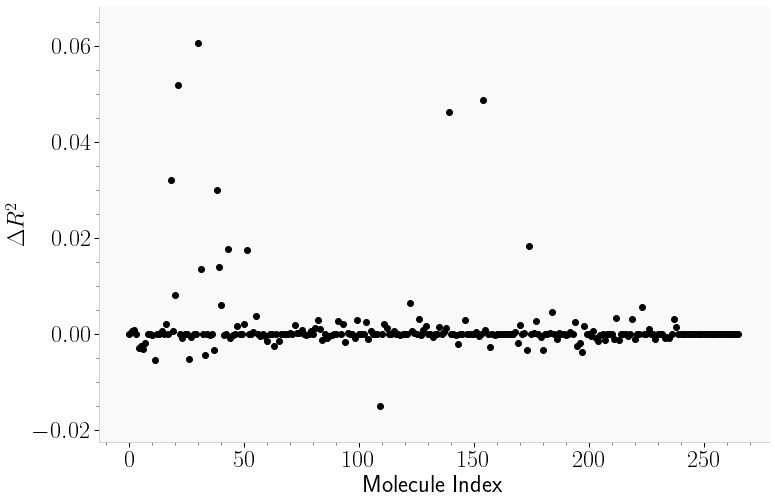

In [2311]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

plt.scatter(range(266), contributions, color="k")
ax.set_ylabel("$\Delta R^2$", fontsize=24)
ax.set_xlabel("Molecule Index", fontsize=24)
plt.show()

<font size="4">  So, what we can do now is take multiple active learning runs, and generate averages for the contribution of each molecule given all the coalitions it was added to. </font>

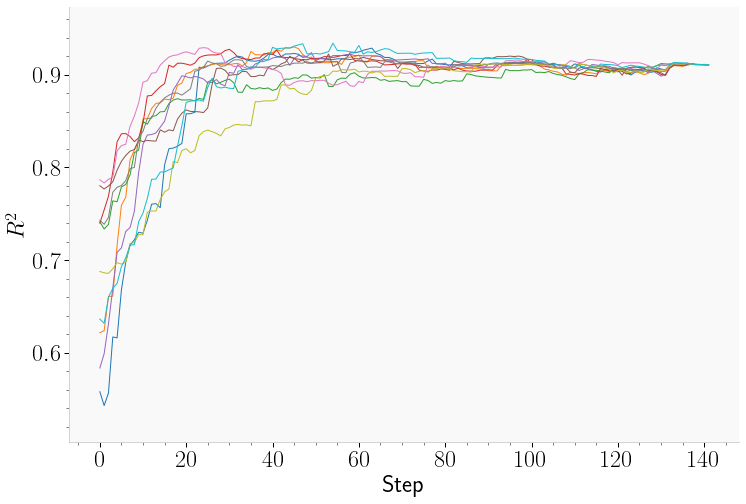

In [2318]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

for i in range(10):
    ax.plot(range(len(kf_results["CM"]["Fold 1"]["Uncertainty"]["scores"][i])), kf_results["CM"]["Fold 1"]["Uncertainty"]["scores"][i], linewidth=1)
    
ax.set_ylabel("$R^2$", fontsize=24)
ax.set_xlabel("Step", fontsize=24)
plt.show()

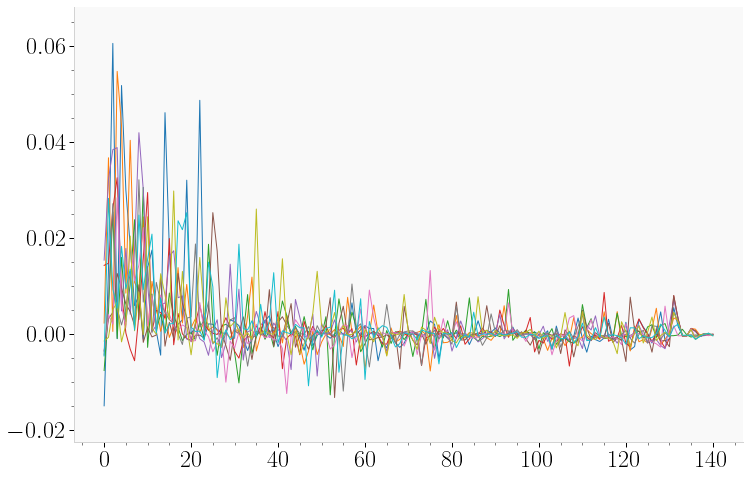

In [2321]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

for i in range(10):
    ax.plot(range(len(kf_results["CM"]["Fold 1"]["Uncertainty"]["scores"][i])-1), np.diff(kf_results["CM"]["Fold 1"]["Uncertainty"]["scores"][i]), linewidth=1)


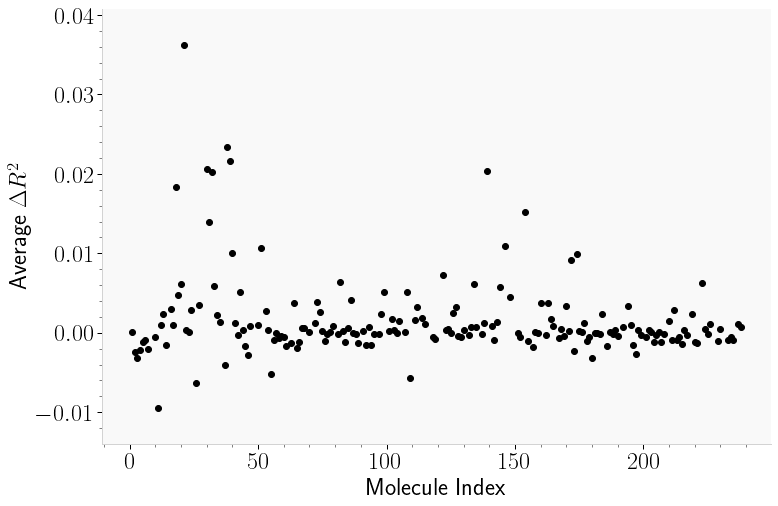

In [2327]:
contributions = np.zeros((10,266))

for i in range(10):
    contributions[i,kf_results["CM"]["Fold 1"]["Uncertainty"]["idxs"][i][50:]] += np.diff(kf_results["CM"]["Fold 1"]["Uncertainty"]["scores"][i])
    
contributions = np.ma.masked_equal(contributions, 0)

fig, ax = plt.subplots(1,1,figsize=(12,8))

plt.scatter(range(266), contributions.mean(axis=0), color="k")
ax.set_ylabel("Average $\Delta R^2$", fontsize=24)
ax.set_xlabel("Molecule Index", fontsize=24)
plt.show()

## Why use Active Learning?

The original method is to just do this randomly, so why use active learning? The core of the reason is that active learning biases the first few samples chosen based around either informativeness or representativeness. This is usually reflected as a higher overall importance in the $R^2$ as the model improves faster at the start. Thus, active learning biases it in a way that may prove to be useful. 

## Pros and Cons

<font size="4"> Obviously this is still expensive, but if it can identify the most useful molecules within a dataset in a fairly blind manner, then it is useful. So the natural question is does it work?

# Manuscript Figures

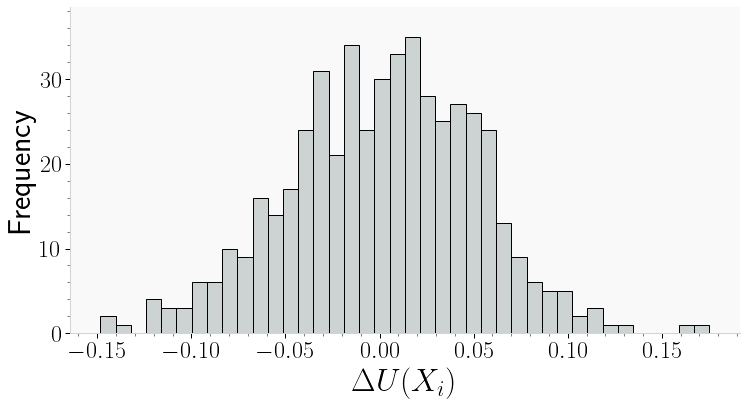

In [39]:
data_vals = np.random.randn(500,) * 0.05

fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.hist(data_vals, bins=40, color="#1a3c3c32", ec="black")
ax.set_xlabel("$\Delta U(X_i)$", fontsize=32)
ax.set_ylabel("Frequency", fontsize=32)
plt.savefig("Images/Distribution_of_differences.svg", bbox_inches="tight")
plt.show()

In [ ]:
fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(nrows=2, ncols=6)

ax11 = fig.add_subplot(gs[0, :2])
ax12 = fig.add_subplot(gs[1, 1:3])
if shareaxes:
    ax21 = fig.add_subplot(gs[0, 2:4], sharey=ax11)
    ax31 = fig.add_subplot(gs[0, 4:6], sharey=ax11)
    ax22 = fig.add_subplot(gs[1, 3:5], sharey=ax12)
else:
    ax21 = fig.add_subplot(gs[0, 2:4])
    ax31 = fig.add_subplot(gs[0, 4:6])
    ax22 = fig.add_subplot(gs[1, 3:5])

axs = [ax11,ax21,ax31,ax12,ax22]

if yaxis_label is not None:
    ax11.set_ylabel(yaxis_label, fontsize=32)
    ax12.set_ylabel(yaxis_label, fontsize=32)

if ylim is not None:
    [ax.set_ylim(*ylim) for ax in axs]

return fig, axs

# Thesis Figures

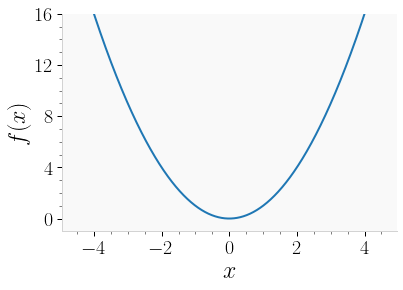

In [30]:
x = np.linspace(-4.5,4.5,1000)
y = np.square(x)

fig, ax = plt.subplots(1,1)

ax.plot(x,y)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

ax.set_yticks([0,4,8,12,16])
ax.set_xticks([-4,-2,0,2,4])

ax.set_ylim(-1,16)

ax.set_xlabel("$x$", fontsize=24)
ax.set_ylabel("$f(x)$", fontsize=24)
plt.savefig("Simple Quadratic.pdf", bbox_inches="tight")

In [ ]:
import matplotlib
import matplotlib.gridspec as gridspec

# Top Row

fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=2, ncols=4)

ax = fig.add_subplot(gs[0,0])
axs = [ax]
for idx in range(3):
    axs.extend([fig.add_subplot(gs[0, idx+1],sharey=ax)])

x = np.random.randn(2,10)
coalitions = [np.random.choice(10, size=(4,), replace=False) for x in range(4)]
idx_set = np.arange(10)

for i, coalition in enumerate(coalitions):
    axs[i].scatter(*x[:,np.setdiff1d(idx_set, coalition)],color="k", alpha=0.5, label="Unused Data")
    axs[i].scatter(0,0,color="green", label="$x_i$")
    axs[i].scatter(*x[:,coalition], color="orange", label="Coalition ($X$)")
    axs[i].set_title(f"$X_{i+1}$", fontsize=24)

axs[3].legend(markerscale=2, fontsize=24, loc="center left", bbox_to_anchor=(1,0.5))

# Bottom Row
maths = fig.add_subplot(gs[1, 0])
maths 

distribution = fig.add_subplot(gs[1,1:3])
final = fig.add_subplot(gs[1,3])

plt.tight_layout()
plt.savefig("Images/Coalitions.pdf", bbox_inches="tight")
plt.show()

# Old

## Consensus Scoring

In [1672]:
strategies = ["Active"  , 
              "Random"  , 
              "KMean"   ,
              "Density" ]

consensus_scores = {rep : {strategy : {key : [] for key in range(len(subset))} for strategy in strategies} for rep in representations.keys()}

for rep in representations.keys():
    for strategy in strategies:
        for fold in range(1,6):
            for run in kf_results["AvSOAP"][f"Fold {fold}"][strategy]["idxs"]:
                i = 212-30 #len(train_index) - seed_size
                for idx in run[seed_size:]:
                    consensus_scores[rep][strategy][idx].append(i)
                    i -= 1
                    


 20%|████████▊                                   | 2/10 [00:14<01:02,  7.76s/it]/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-20. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)
 40%|█████████████████▌                          | 4/10 [00:37<01:01, 10.20s/it]/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
 50%|██████████████████████                      | 5/10 [00:48<00:52, 10.46s/it]/home/acm/anaconda3/envs/rdkit/lib/python3.7/site-packages/sklearn/

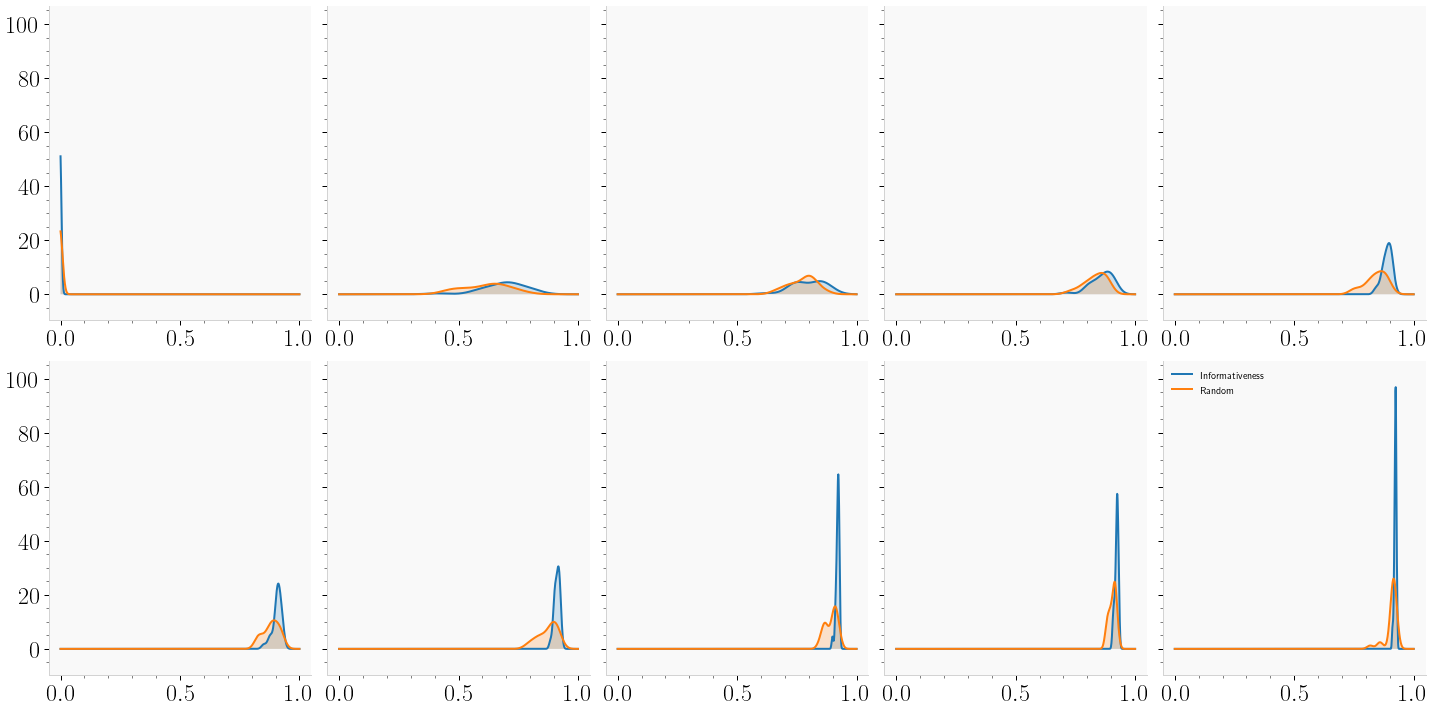

In [ ]:
cols, rows = 5, 2
cols_height = 5
rows_width = 4
sampling_runs = 25

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height), sharey=True)
coords = np.arange(rows * cols).reshape(rows,cols)

inform = fold_informativeness(kf_results["AvSOAP"],strategy="Information Density", seed_size=50, runs=100, subset_idxs=None, dset_size=239).mean(axis=0) * 250

sizes = np.linspace(50,190,cols*rows)

for idx,size in enumerate(tqdm.tqdm(sizes)):
    x,y = np.where(coords == idx)
    ax = axs[x,y][0]
                             
    informative = []
    for i in range(sampling_runs):
        train_idxs = np.random.choice(inner_mols, size=(int(size),) ,replace=False, p=softmax(informativeness_score))))
        check_invalid_selection(train_idxs, outer_mols)
        informative.append(test_gpr(avsoap_mols, Y, train_idxs, outer_mols))

    random_control = []
    for i in range(sampling_runs):
        idxs = np.random.choice(inner_mols, size=(int(size),),replace=False)
        check_invalid_selection(idxs, outer_mols)
        random_control.append(test_gpr(avsoap_mols, Y, idxs, outer_mols))
    
    gaussian_kde_plot(informative, vals=np.linspace(0,1,1000), ax=ax, label="Informativeness")
    gaussian_kde_plot(random_control, vals=np.linspace(0,1,1000), ax=ax,label="Random")

ax.legend(frameon=False)

plt.tight_layout()
plt.show()

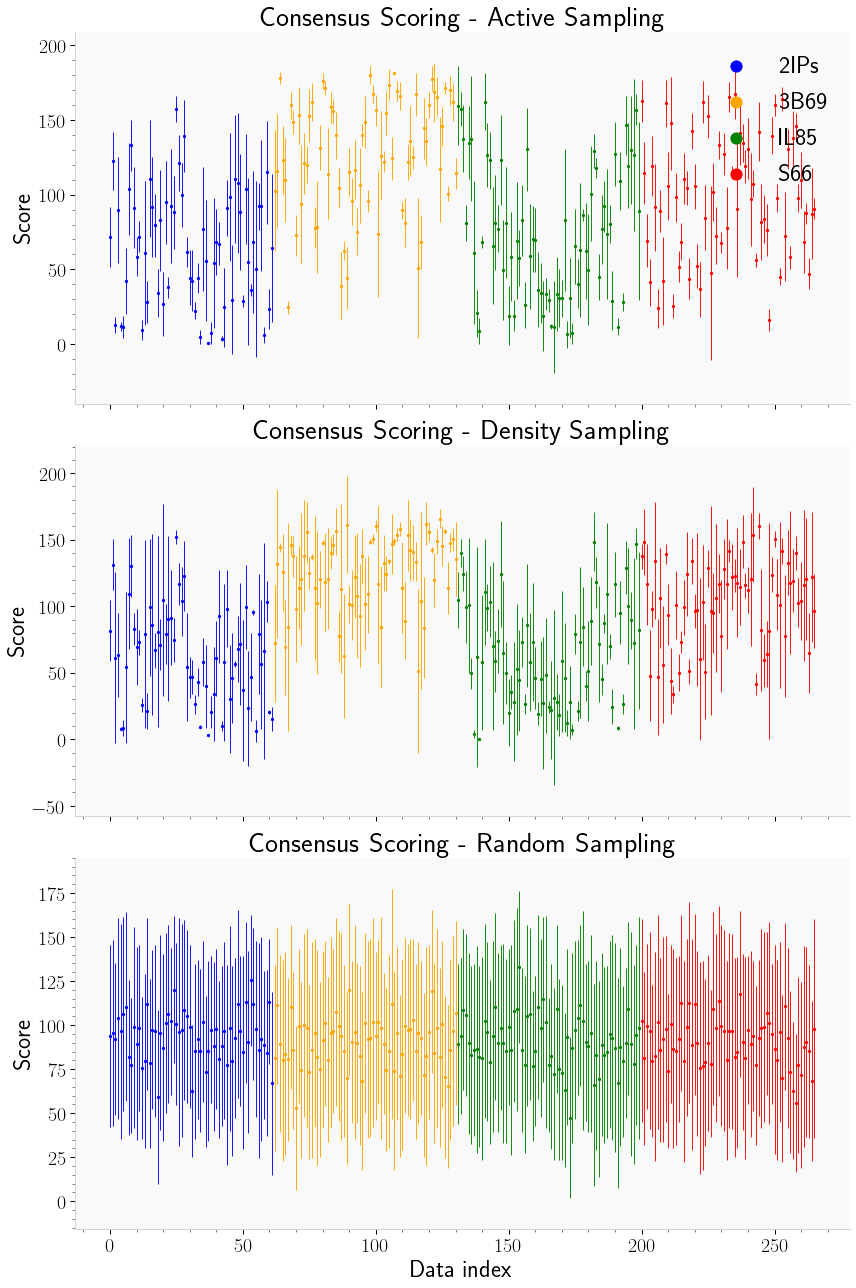

In [1960]:
fig, axs = plt.subplots(3,1,figsize=(12,18), sharex=True)
ax = axs[0]

datasets = {"2IPs" : "blue",
            "3B69" : "orange",
            "IL85" : "green",
            "S66" : "red"}

consensus_data = {"μ" : [],
                  "σ" : []}

for idx,item in enumerate(consensus_scores["AvSOAP"]["Active"].items()):
    point, scores = item
    dset_ = subset.iloc[idx]["Dataset"]
    ax.scatter(point, np.mean(scores), s=5, c=datasets[dset_], label=dset_)
    ax.errorbar(point, np.mean(scores), yerr=np.sqrt(np.var(scores)), linewidth=0.9, c=datasets[dset_])

handles, labels = ax.get_legend_handles_labels()
unique_idxs = np.unique(labels, return_index=True)[1]

handles = [handles[idx] for idx in unique_idxs]

ax.legend(handles=handles, loc='upper right', frameon=False, fontsize=24, markerscale=5)

ax.set_title("Consensus Scoring - Active Sampling",fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel("Score", fontsize=24)

ax = axs[1]

for idx,item in enumerate(consensus_scores["AvSOAP"]["Density"].items()):
    point, scores = item
    dset_ = subset.iloc[idx]["Dataset"]
    ax.scatter(point, np.mean(scores), s=5, c=datasets[dset_], label=dset_)
    ax.errorbar(point, np.mean(scores), yerr=np.sqrt(np.var(scores)), linewidth=0.9, c=datasets[dset_])
    consensus_data["σ"].append(np.sqrt(np.var(scores)))
    consensus_data["μ"].append(np.mean(scores))

ax.set_title("Consensus Scoring - Density Sampling",fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel("Score", fontsize=24)

ax = axs[2]

datasets = {"2IPs" : "blue",
            "3B69" : "orange",
            "IL85" : "green",
            "S66" : "red"}

for idx,item in enumerate(cm_scores["Random"].items()):
    point, scores = item
    dset_ = subset.iloc[idx]["Dataset"]
    ax.scatter(point, np.mean(scores), s=5, c=datasets[dset_])
    ax.errorbar(point, np.mean(scores), yerr=np.sqrt(np.var(scores)), linewidth=0.9, c=datasets[dset_])
    
ax.set_title("Consensus Scoring - Random Sampling",fontsize=28)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel("Data index", fontsize=24)
ax.set_ylabel("Score", fontsize=24)

plt.tight_layout()
#plt.savefig("Images/Consensus_Scoring.pdf", bbox_inches="tight")
plt.show()

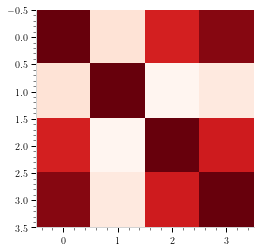

In [590]:
scores_arr = np.array([list(cm_scores[strat].values()) for strat in strategies])

plt.imshow(np.corrcoef(scores_arr), cmap="Reds", vmin=0,vmax=1)

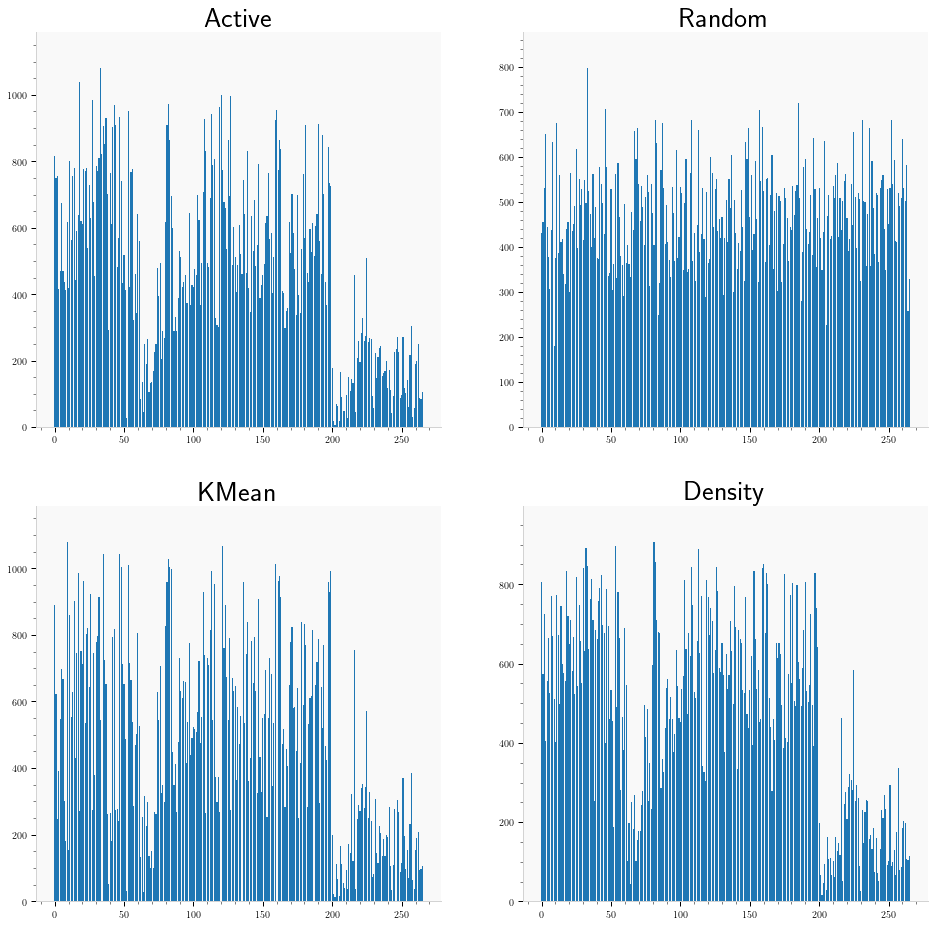

In [424]:
cols, rows = 2,2
cols_height = rows_width = 8

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height))
coords = np.arange(rows * cols).reshape(rows,cols)

for idx,item in enumerate(cm_scores.items()):
    x,y = np.where(coords == idx)
    ax = axs[x,y][0]
    
    strategy, scores = item
    ax.bar(range(len(scores)),np.array(list(scores.values()))/random_runs)
    ax.set_title(strategy, fontsize=28)

plt.show()

In [328]:
np.corrcoef(list(cm_scores["Active"].values()),list(cm_scores["KMean"].values()))

array([[1.000, 0.720],
       [0.720, 1.000]])

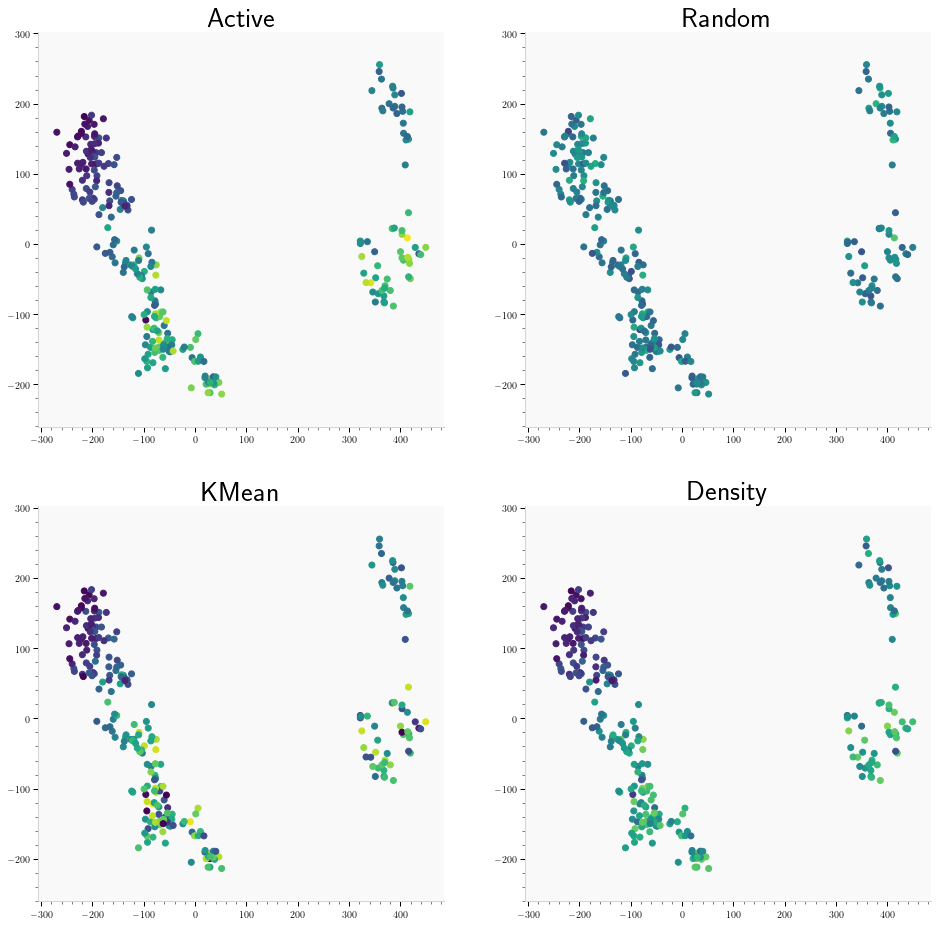

In [333]:
cols, rows = 2,2
cols_height = rows_width = 8

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height))
coords = np.arange(rows * cols).reshape(rows,cols)

for idx,item in enumerate(cm_scores.items()):
    x,y = np.where(coords == idx)
    ax = axs[x,y][0]
    
    strategy, scores = item
    ax.scatter(small_cm[:,0], small_cm[:,1], c=list(cm_scores[strategy].values()), vmin=0, vmax=2200)
    ax.set_title(strategy, fontsize=28)
    
plt.show()

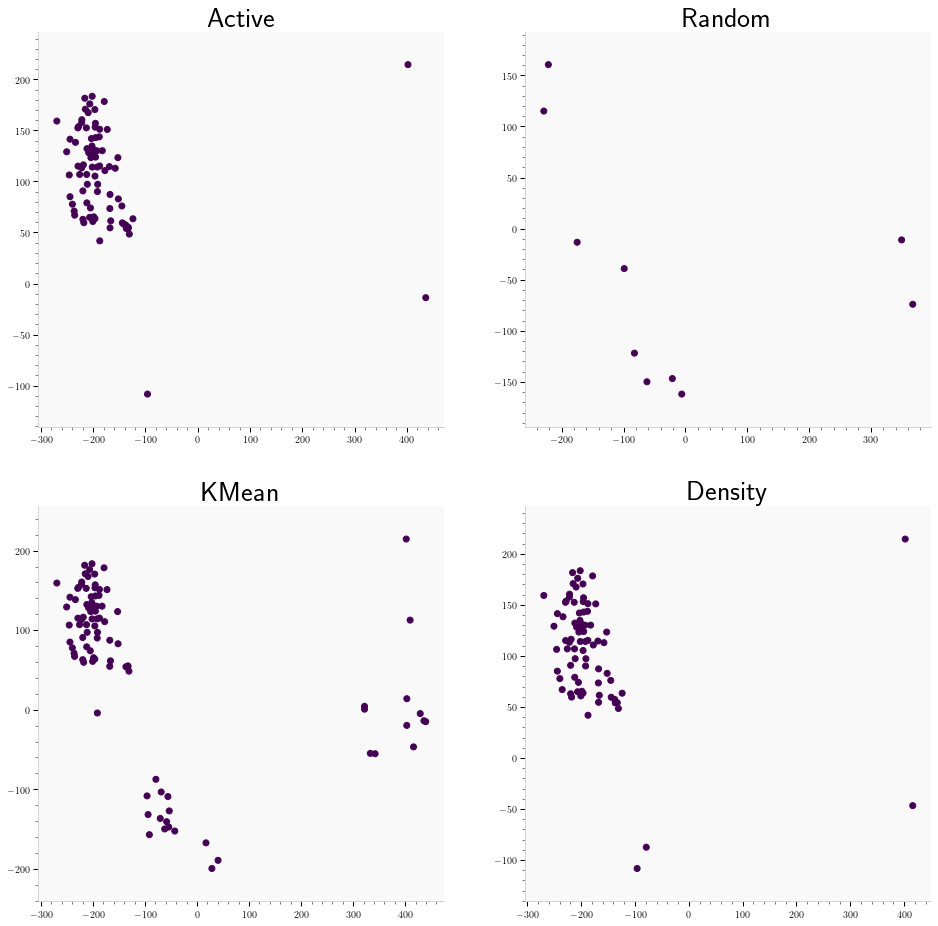

In [376]:
cols, rows = 2,2
cols_height = rows_width = 8

fig, axs = plt.subplots(rows,cols,figsize=(cols*rows_width,rows*cols_height))
coords = np.arange(rows * cols).reshape(rows,cols)

for idx,item in enumerate(cm_scores.items()):
    x,y = np.where(coords == idx)
    ax = axs[x,y][0]
    
    strategy, scores = item
    cutoff = 600
    consensus = np.array(list(cm_scores[strategy].values()))
    
    
    ax.scatter(small_cm[cutoff > consensus,0], small_cm[cutoff > consensus,1], c=consensus[cutoff > consensus], vmin=cutoff, vmax=2200)
    ax.set_title(strategy, fontsize=28)
    
plt.show()

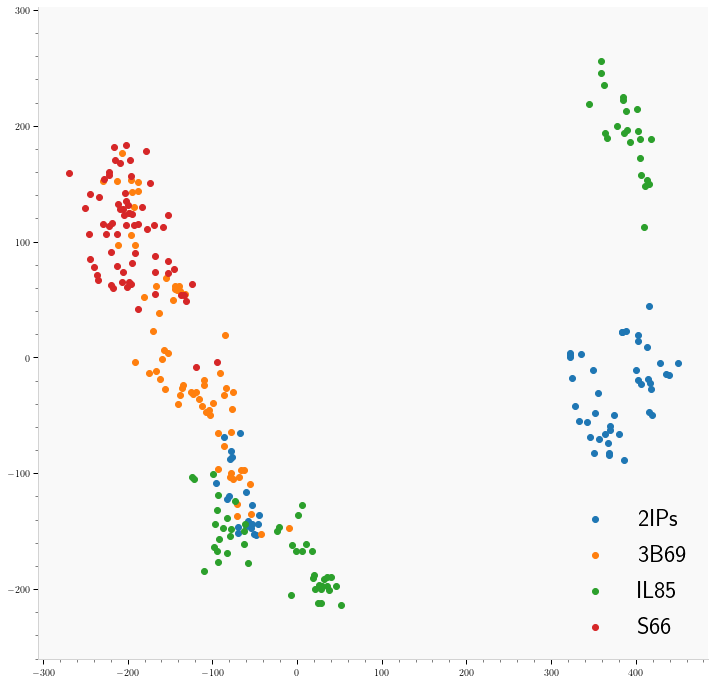

In [356]:
fig, ax = plt.subplots(figsize=(12,12))

for dset in dsets.keys():
    dset_len = len(subset[subset["Dataset"] == dset].index)
    if dset == "X23" or dset == "4IPs":
        continue
    ax.scatter(small_cm[df[df["Dataset"] == dset].index, 0], small_cm[df[df["Dataset"] == dset].index, 1], label=dset)

plt.legend(fontsize=24,frameon=False,loc="lower right")
plt.show()

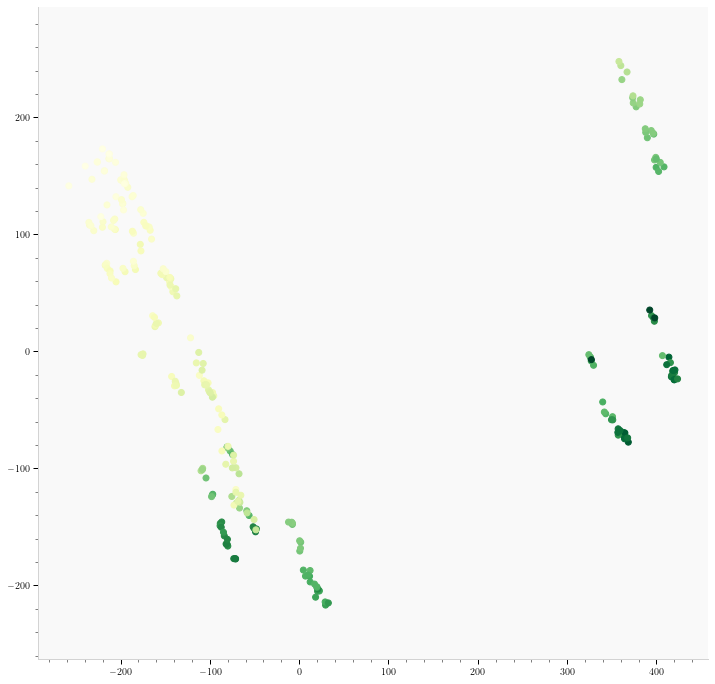

In [539]:
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(small_cm[:,0], small_cm[:,1], c=-subset["dINT_BLYP_ref_cp"], cmap="YlGn")
plt.show()

In [533]:
subset

Complex  dINT_BLYP_ref_cp  dINT_B3LYP_ref_cp  \
0         c4mim-ac-2-p2             -65.2              -43.6   
1         c4mim-ac-2-p4             -63.9              -49.8   
2         c4mim-ac-2-p7             -83.5              -58.8   
3         c4mim-ac-3-p4            -156.0             -119.9   
4         c4mim-ac-4-p2            -143.9              -87.5   
..                  ...               ...                ...   
261    62_Pentane-AcNH2             -24.5              -19.9   
262     63_Benzene-AcOH             -23.6              -19.2   
263   64_Peptide-Ethene             -16.2              -12.7   
264  65_Pyridine-Ethyne              -5.6               -3.7   
265   66_MeNH2-Pyridine             -17.7              -14.5   

     dINT_M062X_ref_cp  dINT_PBE_ref_cp Dataset  
0            20.267909       -18.044256    2IPs  
1            10.850084       -27.240597    2IPs  
2            20.934319       -30.089175    2IPs  
3            13.806976       -91.104089    2IPs  
4             9.343976       -82.055240    2IPs  
..                 ...              ...     ...  
261          -1.059632       -13.700000     S66  
262          -0.445806       -14.000000     S66  
263          -0.725776        -8.600000     S66  
264          -1.959910        -1.600000     S66  
265          -1.451535        -9.900000     S66  

[266 rows x 6 columns]

## Conclusions

The model is biased away from regions with low errors, effectively removing a large amount of the data diversity. This does naturally improve performance, as the model doesn't waste time examining regions which will not substantially lower its error, and many would argue that this is the desired behaviour, but it is an important thing to be aware of.

## Statistical Significance of different active learning methods

One of the difficulties of active learning is that the method often looks better, but, what you want to know is, when compared to a random sample, how statistically significant is the result. My current thinking is the active learning 'path' is a series of samples. Each of these is a random variable recording the performance of the model as an R squared value. If this random variable is assumed to be normally distributed with the mean defined by the centre and the standard deviation estimated by multiple runs, then you can compute how likely the performance difference between them is at that point using a z-test. The only question then becomes how you can use multiple z tests for sequential data?

A basic example of this framework is provided below.

In [582]:
# This data array is for fold 5, and this selects for the random variable associated with the first sample drawn.

from statsmodels.stats.weightstats import ztest as ztest

N1 = random_data[:,75]
N2 = density_data[:,75]
N3 = active_data[:,75]

ztest(N2, N3, value=0)


(0.5497232975690436, 0.5825091748132127)

## Most informative points

In [774]:
repeats = 100
size = len(big_idxs)

idx_random_results = [[] for key in idx_results.keys()]

for _ in range(repeats):
    current_results = test_idx_parameterisation(np.random.choice(kf_results["CM"]["Fold 1"]["Active"]["idxs"][0], size=(size,), replace=False),kf_results["CM"]["Fold 1"]["Test indexes"], R=1, bootstrap_off=True)
    for idx,key in enumerate(current_results.keys()):
        idx_random_results[idx].append(current_results[key])

idx_random_results = np.array(idx_random_results)

In [762]:
idx_random_results[:,np.argmin(np.abs(idx_random_results[3,:]))]

array([-0.150, 0.966, 3.098, 7.291, 7.290, 0.184, 17.788, -17.788, 15.156])

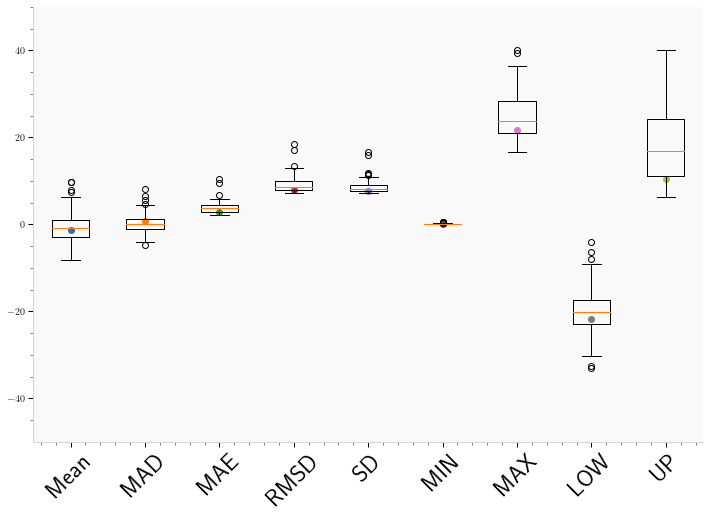

In [775]:
idx_results

fig, ax = plt.subplots(figsize=(12,8))

ax.boxplot(idx_random_results.T)

for idx,item in enumerate(idx_results.items()):
    name, val = item
    ax.scatter(idx+1, val, label=name)

ax.set_xticklabels(idx_results.keys(),fontsize=24, rotation=45)
plt.ylim(-50,50)
plt.show()

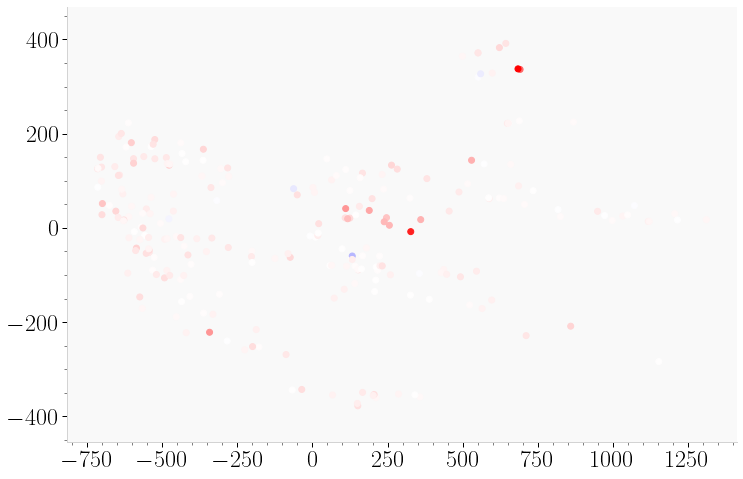

In [745]:
averages = np.mean(rep_informativeness(kf_results,strategy="Information Density", seed_size=50, runs=30, subset_idxs=None, dset_size=239), axis=0) * T

fig = plt.figure(figsize=(12,8))
plt.scatter(small_soap[inner_mols,0], small_soap[inner_mols,1], c=averages, cmap="bwr", vmin=-np.max(averages))
plt.show()

## ReMatch Kernel

In [ ]:
"""from sklearn.preprocessing import normalize
from dscribe.kernels import REMatchKernel

def rematch(re_kernel, soap_mols):
    norm_soap_mols = [normalize(soap_mol) for soap_mol in soap_mols]
    re_kernel = np.zeros((len(soap_mols), len(soap_mols)))

    for i,mol_i in enumerate(tqdm.tqdm(norm_soap_mols)):
        for j,mol_j in zip(range(i+1,len(soap_mols)),norm_soap_mols[i+1:]):
            re_kernel[i,j] = re.create([mol_i, mol_j])[0,1]

    re_kernel = re_kernel + re_kernel.T
    np.fill_diagonal(re_kernelT, 1)
    
    return re_kernel

re = REMatchKernel(metric="rbf", gamma=0.5, alpha=1, threshold=1e-6)
re_kernel = rematch(re, soap_mols)"""


'from sklearn.preprocessing import normalize\nfrom dscribe.kernels import REMatchKernel\n\ndef rematch(re_kernel, soap_mols):\n    norm_soap_mols = [normalize(soap_mol) for soap_mol in soap_mols]\n    re_kernel = np.zeros((len(soap_mols), len(soap_mols)))\n\n    for i,mol_i in enumerate(tqdm.tqdm(norm_soap_mols)):\n        for j,mol_j in zip(range(i+1,len(soap_mols)),norm_soap_mols[i+1:]):\n            re_kernel[i,j] = re.create([mol_i, mol_j])[0,1]\n\n    re_kernel = re_kernel + re_kernel.T\n    np.fill_diagonal(re_kernelT, 1)\n    \n    return re_kernel\n\nre = REMatchKernel(metric="rbf", gamma=0.5, alpha=1, threshold=1e-6)\nre_kernel = rematch(re, soap_mols)'

## Visualising Molecular Systems

In [ ]:
import ase.visualize

idx = 5

system = Atoms(positions=mols[idx].positions, symbols=mols[idx].symbols)
#x3d
ase.visualize.view(system, viewer="x3d")

## Animations

In [20]:
density_seed = np.random.choice(train_index, size=(seed_size,), replace=False)
density_idxs, density_scores = active_test(density_seed, X̂, train_index, test, queries=queries, kernel=kernel, query=GP_density_regression_std)

In [25]:
for idx in range(1,len(density_idxs)-seed_size):

    fig, ax = plt.subplots(figsize=(12,12))
    # Plot all data
    ax.scatter(small_cm[:,0], small_cm[:,1], edgecolor="k", s=40,alpha=0.25)
    # Plot the seed set
    ax.scatter(small_cm[density_idxs[:seed_size],0], small_cm[density_idxs[:seed_size],1], edgecolor="k", s=40)
    # Plot the points as they are selected
    ax.scatter(small_cm[density_idxs[seed_size:seed_size+idx],0],small_cm[density_idxs[seed_size:seed_size+idx],1], edgecolor="k", s=40)
    
    ax.axvline(small_cm[density_idxs[seed_size+idx-1],0],linewidth=0.5,color='k')
    ax.axhline(small_cm[density_idxs[seed_size+idx-1],1],linewidth=0.5,color="k")
    
    plt.savefig(f"Images/active-test-{str(idx).zfill(3)}.png",bbox_inches="tight")
    plt.close()

## Notes

It does make sense that the random active would be likely to start with higher performance than an unsupervised seeded method. The reason for this would be that the unsupervised method is intentionally trying to capture diverse points, and, as a result the problem is substantially harder, however it is more informed about what points are needed to build a better model, and, as such, its performance improves far more rapidly.

I wonder how the different clustering methods would handle this?

It does cement this idea that active learning is really only going to help you in the low data regimes, but, that being said, it does do quite an impressive job at each point. Particularly the unsupervised seeded method undergoes a precipitous increase in performance.

The current problem is that the pool is not redefined, while it is unlikely to be completely dominating the results, it means that some models have effectively a more limited pool, and, beyond that, that there are certain points that the model just is not allowed to touch.

## GPR Validation

In [ ]:
repeats = 10
test_runs = [x for x in range(50,190,5)]

gpr_validation_results = {rep : {} for rep,strat in zip(representations.keys(),strategies.keys())}

for i, rep in enumerate(representations.keys()):
    randoms = []
    for size in  tqdm.tqdm(test_runs):
        random_repeats = []
        for _ in range(repeats):
            random_repeats.append(test_gpr(representations[rep], df["dINT_BLYP_ref_cp"].to_numpy(), np.random.choice(inner_mols, size=size, replace=False), outer_mols))
        randoms.append(random_repeats)

    randoms = np.array(randoms)
    randoms[randoms < 0] = 0
    
    for j, strat in enumerate(strategies.keys()):
        true = []
        inform = fold_informativeness(kf_results[rep], strategy=strat, runs=100, folds=5, scaler=None, seed_size=50, dset_size=dset_size, subset_idxs=inner_mols)
        averages = inform.mean(axis=0)
        
        for size in tqdm.tqdm(test_runs):
            true.append(test_gpr(representations[rep], Y, inner_mols[np.argsort(averages[~averages.mask])[::-1]][:size], outer_mols))
            assert len(np.intersect1d(inner_mols[np.argsort(averages[~averages.mask])][:size], outer_mols)) == 0, "Failed."
        
        true = np.array(true)
        true[true < 0] = 0
        
        bad = []
        for size in tqdm.tqdm(test_runs):
            bad.append(test_gpr(representations[rep], Y, inner_mols[np.argsort(averages[~averages.mask])][:size], outer_mols))
            assert len(np.intersect1d(inner_mols[np.argsort(averages[~averages.mask])][:size], outer_mols)) == 0, "Failed."
        
        bad = np.array(bad)
        bad[bad < 0] = 0
        
        gpr_validation_results[rep][strat] = [true, randoms, bad]

## Notes of using stats to assess performance 

Each performance metric is sampled from a Gaussian distribution, so the overall performance metric is sampled from a multivariate Gaussian distribution. If each metric does indeed conform to a Gaussian, then we can work out the p value of how significant the difference is for 

The null hypothesis is that the difference between performance of the 'most informative' dataset and a randomly selected one is zero. The hypothesis is that the difference in magnitude of these errors is not zero.

The issue, I think, is that this assumes that the multivariate Gaussians are not correlated, whereas, in truth they are. If you choose the lowest value for Mean error, then all other errors decrease substantially. I think I can estimate the covariance matrix and then use that to define the multivarate gaussian that is being sampled from. Then it should be a fair estimation of how likely this is.
